In [1]:
import gym
import tensorflow as tf
from collections import deque
import numpy as np
seed = 0

# Helper Function for Visualization

In [8]:
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display
from matplotlib import pyplot as plt

def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    display(display_animation(anim, default_mode='loop'))

# Replay Buffer : PCL style

In [3]:
class ReplayBuffer(object):
    def __init__(self, max_len=100000, alpha=1):
        self.max_len = max_len
        self.alpha = alpha
        self.buffer = []
        self.weight = np.array([])

    def add(self, episode):
        self.buffer.append(episode)
        self.weight = np.append(self.weight, np.exp(self.alpha*episode['rewards'].sum()))
        if len(self.buffer) > self.max_len:
            delete_ind = np.random.randint(len(self.buffer))
            del self.buffer[delete_ind]
            self.weight = np.delete(self.weight, delete_ind)

    def sample(self):
        return np.random.choice(self.buffer, p=(self.weight)/np.sum(self.weight))

    def get_length(self):
        return len(self.buffer)

# PCL Agent

### Path Consistency Learning : $-V_{\phi}(s_{t})+\gamma^{d} V_{\phi}(s_{t+d}) + \sum_{k=0}^{d-1}\gamma^{k}[r_{t+k} - \tau \log(\pi_{\theta}(a_{t+k}|s_{t+k}))]$

### Dimension of placeholders

### $\{\{s_{i},s_{i+1},s_{i+2},\cdots,s_{i+d-1},s_{i+d}\}_{i}\}$ : (B x d+1 x dimension of observation)
### $\{\{a_{i},r_{i+1},a_{i+2},\cdots,a_{i+d-1}\}_{i}\}$ : (B x d+1) (discrete action)
### $\{\{r_{i},r_{i+1},r_{i+2},\cdots,r_{i+d-1}\}_{i}\}$ : (B x d+1)

In [4]:
class PCLAgent(object):
    def __init__(self, obs_dim, n_act, hdim=64, training_start=32, n_off_policy_learning=5,
            pol_lr=7e-4,val_lr=3.5e-4, ent_coeff=0.5, rollout_d=20, gamma=0.99):
        
        self.obs_dim = obs_dim
        self.n_act = n_act
        
        self.hdim = hdim
        
        self.replay_buffer = ReplayBuffer()
        self.training_start = training_start
        
        self.n_off_policy_learning = n_off_policy_learning
        self.pol_lr = pol_lr
        self.val_lr = val_lr
        
        self.ent_coeff = ent_coeff
        self.rollout_d = rollout_d
        
        self.gamma = gamma
        
        tf.reset_default_graph()
        self.build_graph()
        self.init_sess()

    def build_graph(self):
        
        # One sample is a seuqnce of observation and action pairs with length d
        # obervations : B x d+1 x observation dimension
        # rewards : B x d
        # actions (discrete) : B x d
        # discount factor list : 1 x d
        
        self.obs_ph = tf.placeholder(tf.float32, shape=(None, None, self.obs_dim), name='observations')
        self.rew_ph = tf.placeholder(tf.float32, shape=(None, None), name='rewards')
        self.act_ph = tf.placeholder(tf.int32, shape=(None, None), name='actions')
        self.discount = tf.placeholder(tf.float32, shape=(1, None), name='discounts')

        self.value = self.build_value_nn(self.obs_ph, reuse=False)
        self.policy, self.logits = self.build_policy_nn(self.obs_ph[:,:-1,:], reuse=False)
        
        self.pol_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="policy")
        self.val_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="value")
        
        v_s_t = self.build_value_nn(self.obs_ph[:, 0, :], reuse=True) # V(s_t)
        v_s_t_d = self.build_value_nn(self.obs_ph[:, -1, :], reuse=True) # V(s_t_d)
        
        one_hot = tf.one_hot(self.act_ph,self.n_act,axis=-1)
        log_pi = tf.reduce_sum(tf.log(self.policy + 1e-8)*one_hot,axis=2) # Log( `\pi(a_t_k|s_t_k) )
        
        d = tf.cast(tf.shape(self.obs_ph)[1], tf.float32) # Length of segment
        C = 0.5 * tf.square(-v_s_t + self.gamma ** d * v_s_t_d + 
                            tf.reduce_sum(self.discount * (self.rew_ph - self.ent_coeff * log_pi) , axis=1)) # Consistency Error
        self.loss =  tf.reduce_mean(C)
        
        pol_optim = tf.train.AdamOptimizer(learning_rate=self.pol_lr).minimize(self.loss,var_list=self.pol_var_list) # Optimizer for policy network
        val_optim = tf.train.AdamOptimizer(learning_rate=self.val_lr).minimize(self.loss,var_list=self.val_var_list) # Optimizer for value network
        self.optim = [pol_optim, val_optim]
                                    
    def build_policy_nn(self, obs, reuse=False):
        hdim = self.hdim
        with tf.variable_scope("policy"):
            out = tf.layers.dense(obs, hdim, activation=tf.nn.relu,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                                  reuse=reuse,
                                  name="h1")
            out = tf.layers.dense(out, hdim, activation=tf.nn.relu,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                                  reuse=reuse,
                                  name="h2")
            logits = tf.layers.dense(out, self.n_act,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                                  reuse=reuse,
                                  name="logits")
            policy = tf.nn.softmax(logits,name="policy")
        return policy, logits
        
    def build_value_nn(self, obs, reuse=False):
        hdim = self.hdim
        with tf.variable_scope("value"):
            out = tf.layers.dense(obs, hdim, activation=tf.nn.relu,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                                  reuse=reuse,
                                  name="h1")
            out = tf.layers.dense(out, hdim, activation=tf.nn.relu,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                                  reuse=reuse,
                                  name="h2")
            value = tf.layers.dense(out, 1,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                                  reuse=reuse,
                                  name="value")
        return value
    
    def init_sess(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True        
        self.sess = tf.Session(config=config)
        self.sess.run(tf.global_variables_initializer())
                            
    def update(self, episode):
        if len(episode['rewards']) < self.rollout_d: # If the length of episode is shorter than the lenght of the segment, then
            rollout_d = len(episode['rewards'])
        else:
            rollout_d = self.rollout_d
        
        discount = np.array([[self.gamma**i for i in range(rollout_d)]], dtype=np.float32)
        observes = []
        actions = []
        rewards = []
        # Generate Batch
        for i in range(len(episode['rewards'])-rollout_d+1):
            observes.append(episode['observes'][i:i+rollout_d+1])
            actions.append(episode['actions'][i:i+rollout_d])
            rewards.append(episode['rewards'][i:i+rollout_d])
            
        feed_dict = {self.obs_ph: observes, self.act_ph: actions, self.rew_ph: rewards, self.discount: discount}
        self.sess.run(self.optim, feed_dict=feed_dict)
        loss = self.sess.run(self.loss, feed_dict=feed_dict)

        return loss

    def get_action(self, obs):
        pi = self.sess.run(self.policy, feed_dict={self.obs_ph: [[obs,obs]]})[0][0]
        action = np.random.choice(self.n_act, p=pi)
        return action
    
    def control(self, obs):
        pi = self.sess.run(self.policy, feed_dict={self.obs_ph: [[obs,obs]]})[0][0]
        best_action = np.argmax(pi)
        return best_action        
    
    def train(self,episode):
        loss_list = []
        
        loss = self.update(episode)
        loss_list.append(loss)
        
        self.replay_buffer.add(episode)

        if self.replay_buffer.get_length() > self.training_start:
            for _ in range(self.n_off_policy_learning):
                replay_episode = self.replay_buffer.sample()
                loss = self.update(replay_episode)
                loss_list.append(loss)

        return np.mean(loss_list)

# Helper Function for Training

In [5]:
def run_episode(env, agent): # Run policy and collect (state, action, reward) pairs
    observes = []
    actions = []
    rewards = []
    infos = []
    
    obs = env.reset()
    done = False
    while not done:
        
        action = agent.get_action(obs)
        next_obs, reward, done, info = env.step(action)
        
        observes.append(obs)
        rewards.append(reward)
        actions.append(action)
        infos.append(info)
        obs = next_obs
    observes.append(obs)
    return dict(observes=np.array(observes),actions=np.array(actions),rewards=np.array(rewards),infos=np.array(infos))

# Training

In [6]:
env = gym.make('CartPole-v1')
# env.seed(seed=seed)
# np.random.seed(seed)
# tf.set_random_seed(seed)

obs_dim = env.observation_space.shape[0]
n_act = env.action_space.n

agent = PCLAgent(obs_dim,n_act)

avg_return_list = deque(maxlen=10)
avg_loss_list = deque(maxlen=10)
nupdates = 3000
for update in range(nupdates+1):
    episode = run_episode(env, agent)
    avg_loss = agent.train(episode)
    
    avg_return_list.append(np.sum(episode['rewards']))
    avg_loss_list.append(avg_loss)
    
    if (update%100) == 0:
        print('[{}/{}] PCL loss : {:.3f}, return : {:.3f}'.format(update, nupdates, np.mean(avg_loss_list), np.mean(avg_return_list)))
        
    if (np.mean(avg_return_list) > 490): # Threshold return to success cartpole
        print('[{}/{}] PCL loss : {:.3f}, return : {:.3f}'.format(update,nupdates, np.mean(avg_loss_list), np.mean(avg_return_list)))
        print('The problem is solved with {} episodes'.format(update))
        break    

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[0/3000] PCL loss : 300.614, return : 37.000
[100/3000] PCL loss : 262.361, return : 120.000
[200/3000] PCL loss : 99.503, return : 433.300
[225/3000] PCL loss : 42.368, return : 500.000
The problem is solved with 225 episodes


# Evaluation

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Total Reward : 500.00



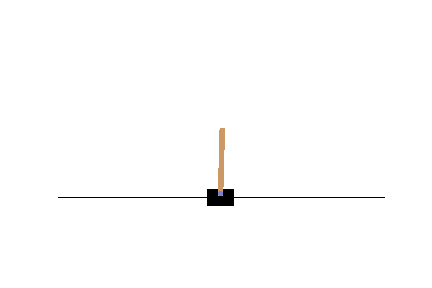
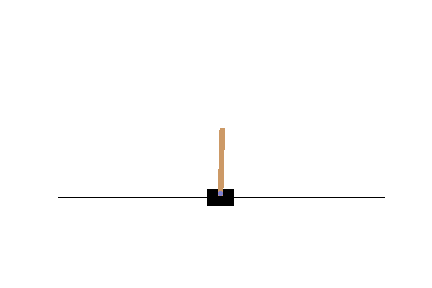
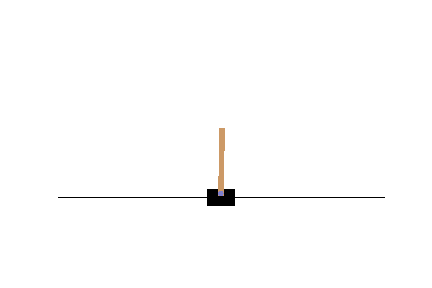
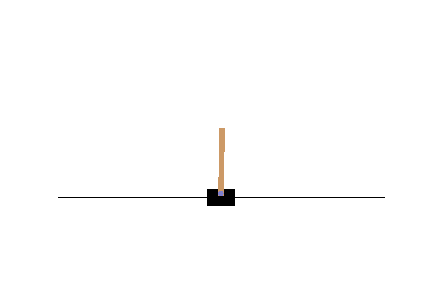
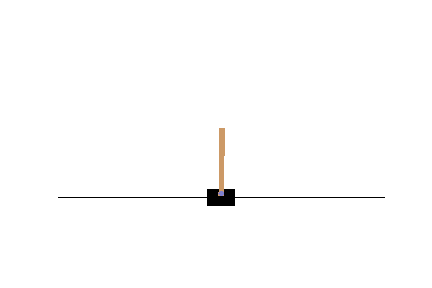
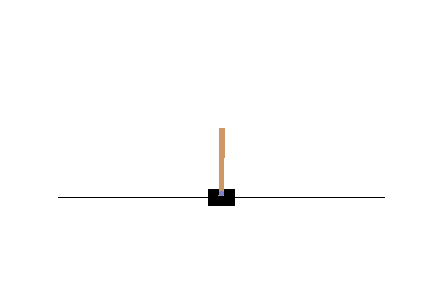
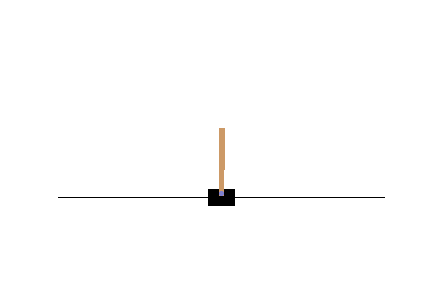
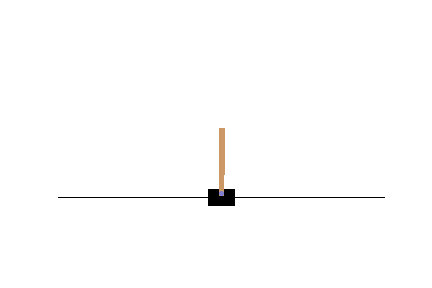
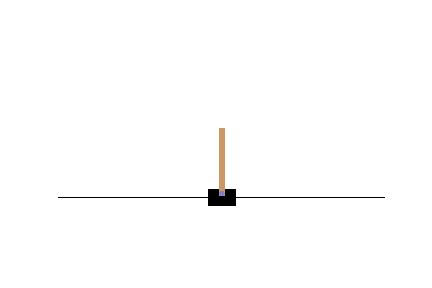
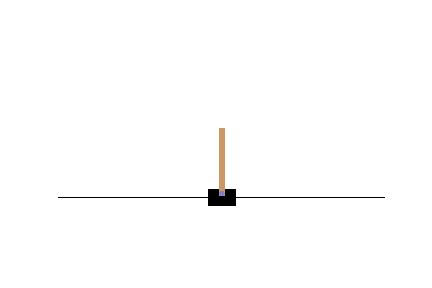
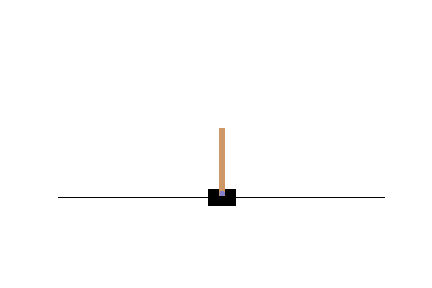
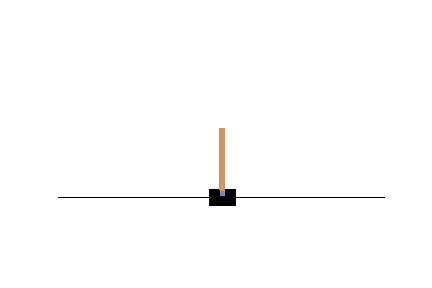
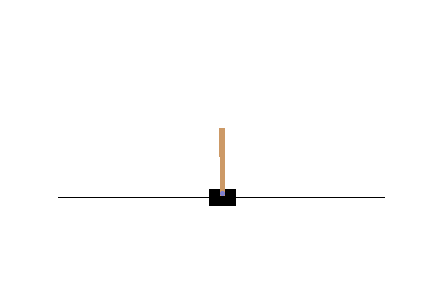
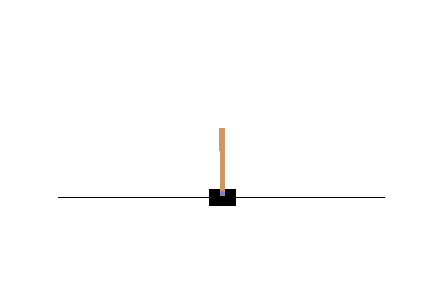
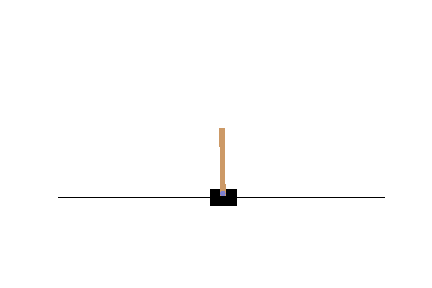
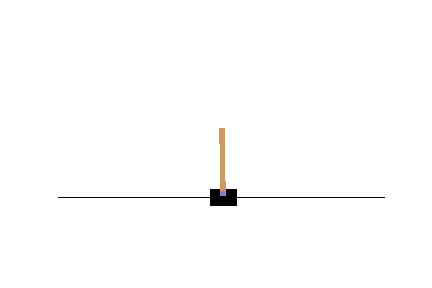
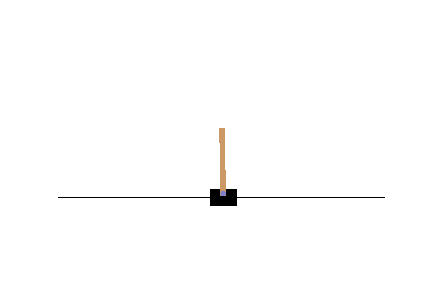
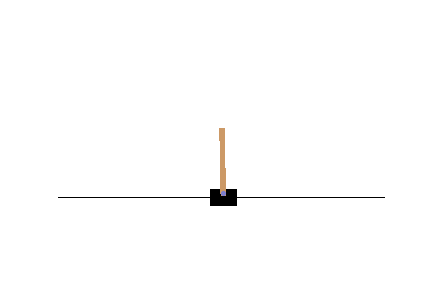
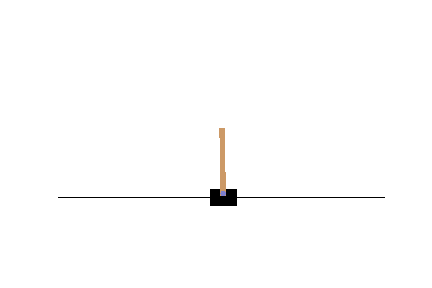
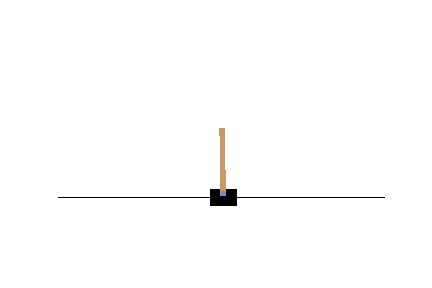
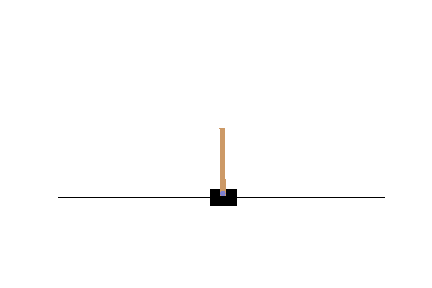
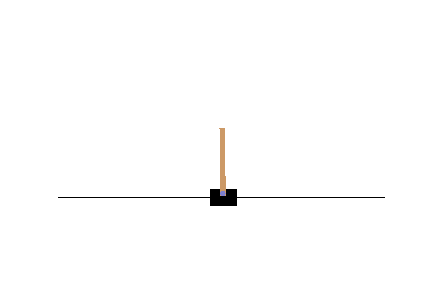
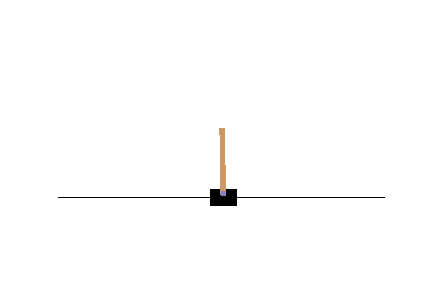
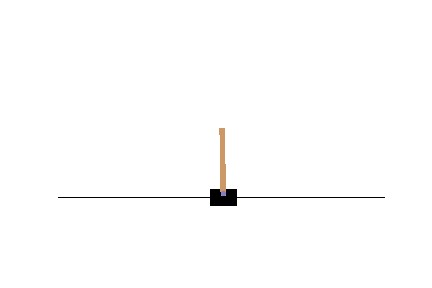
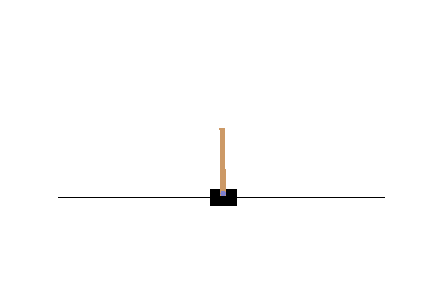
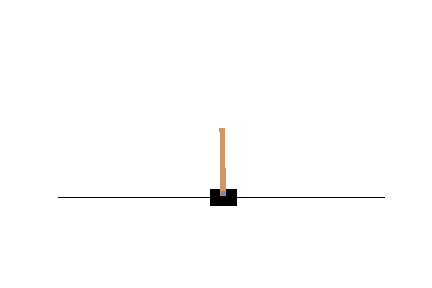
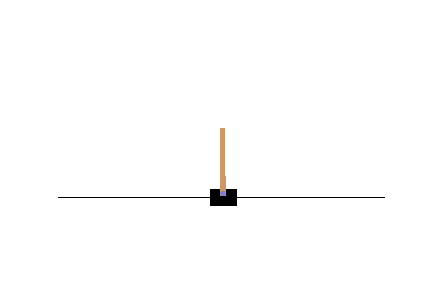
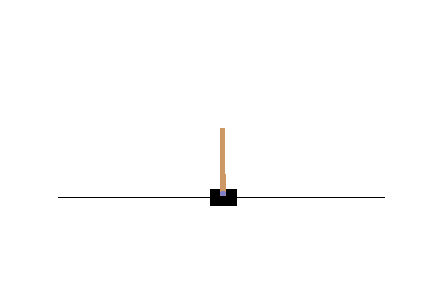
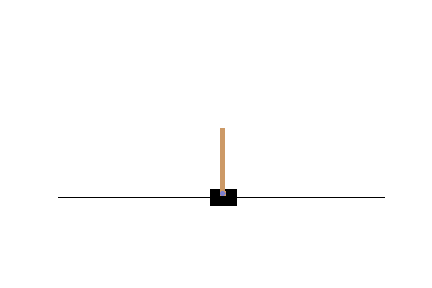
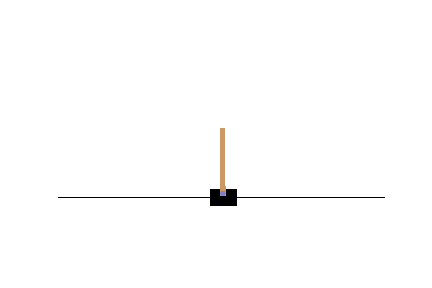
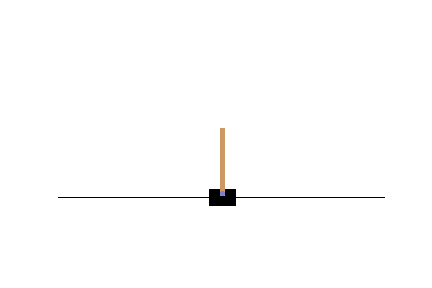
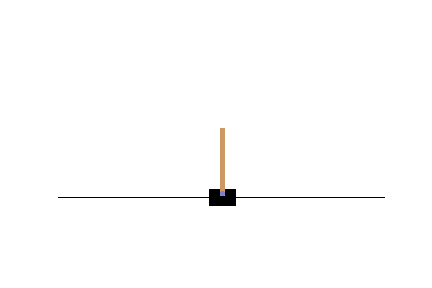
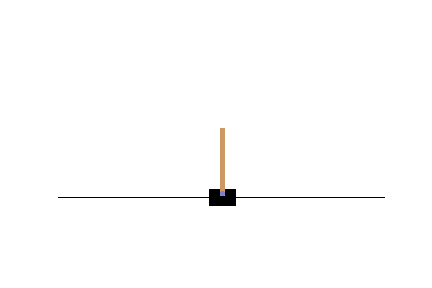
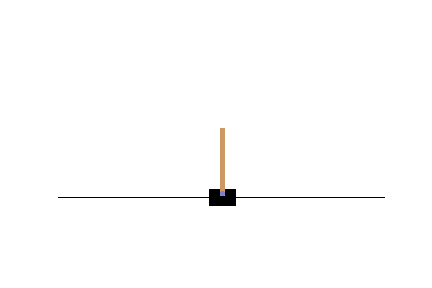
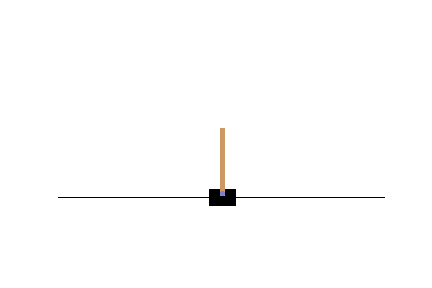
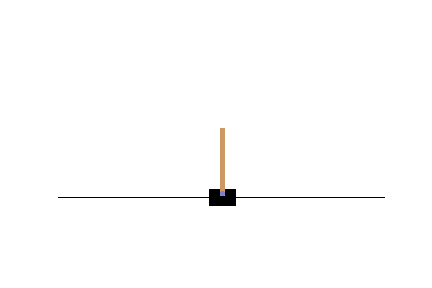
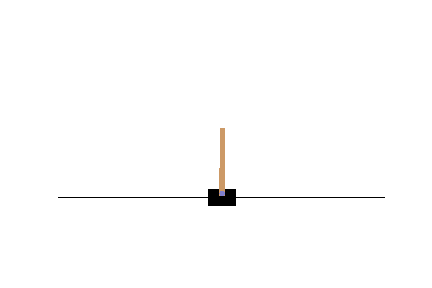
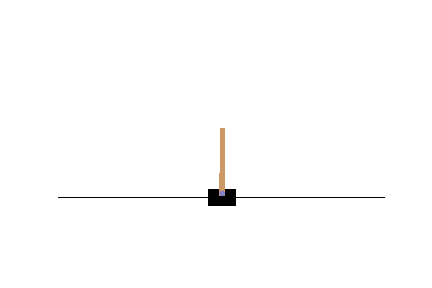
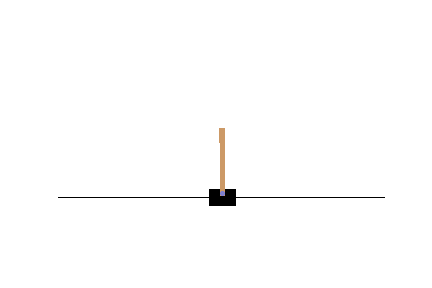
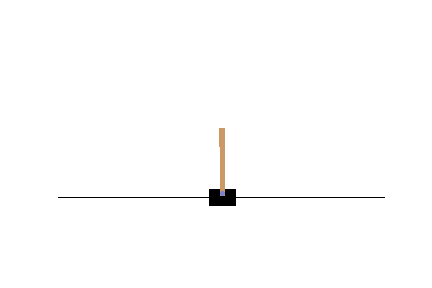
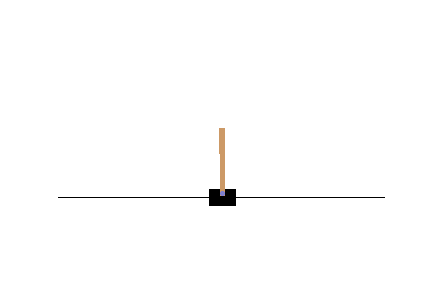
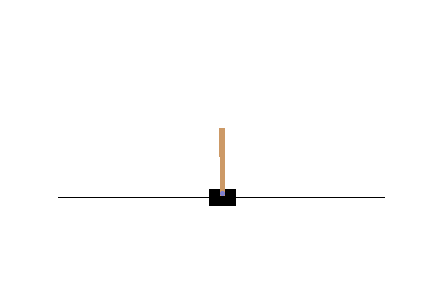
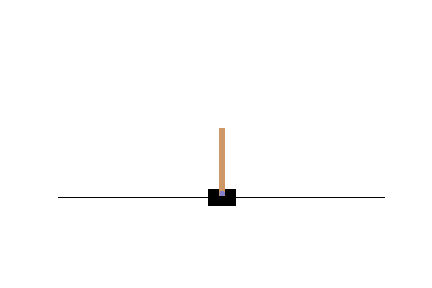
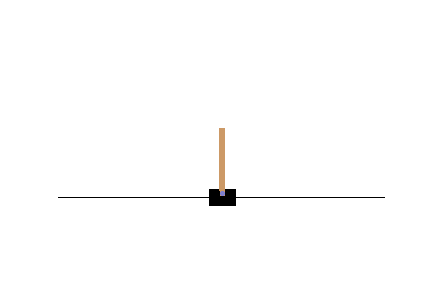
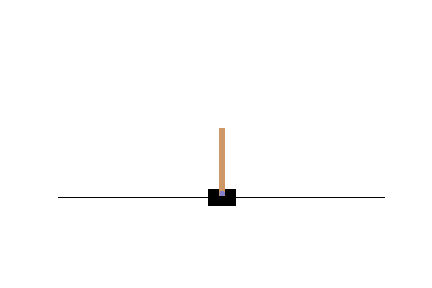
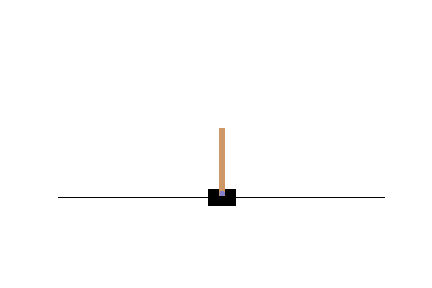
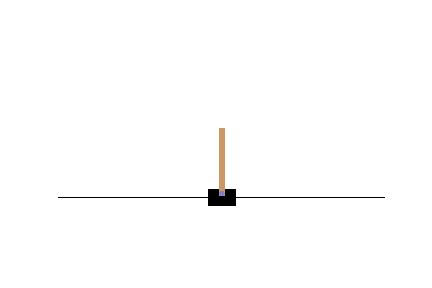
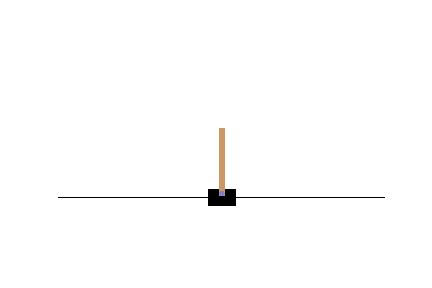
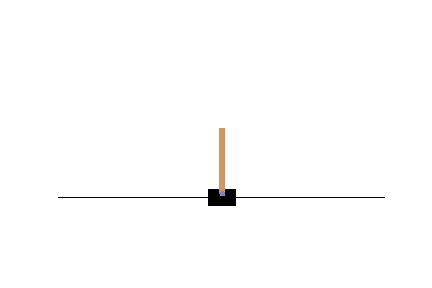
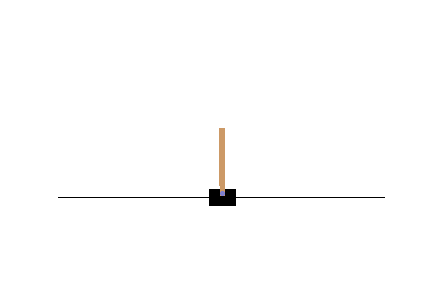
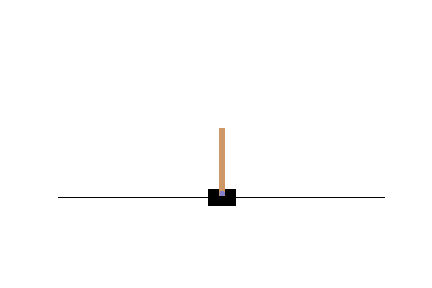
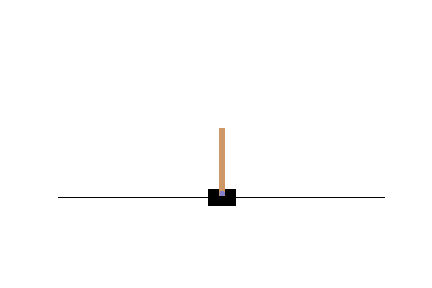
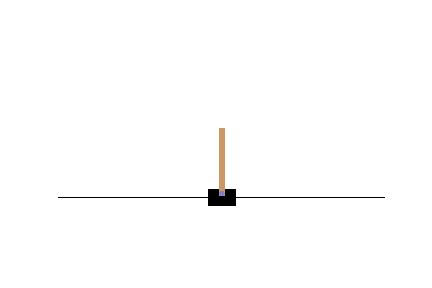
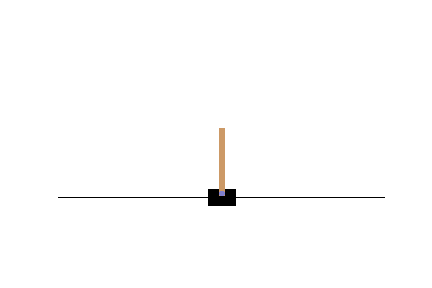
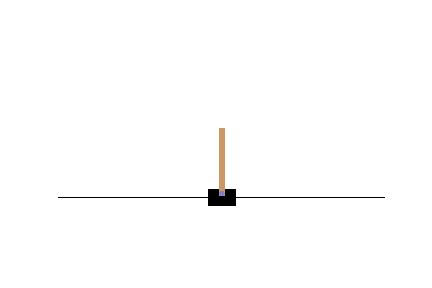
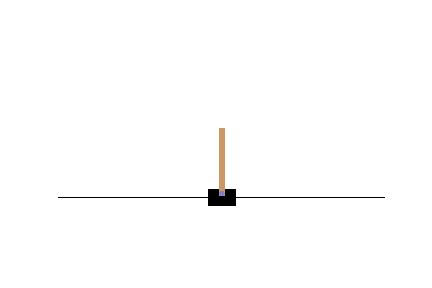
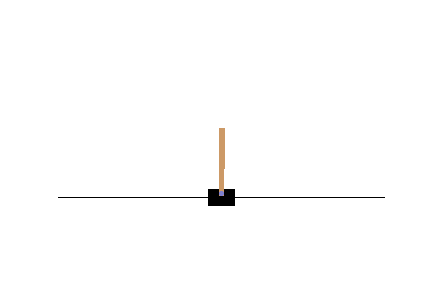
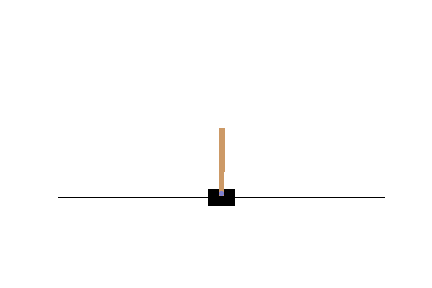
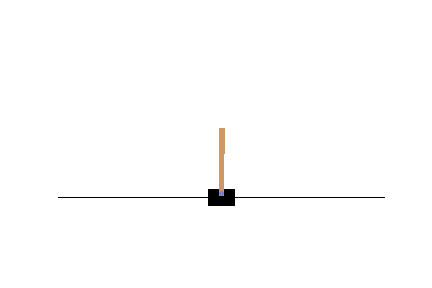
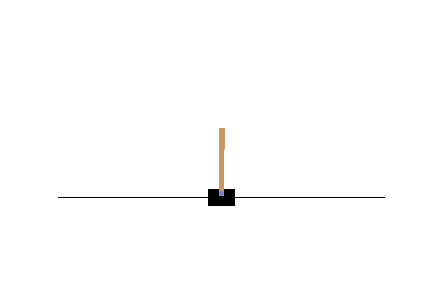
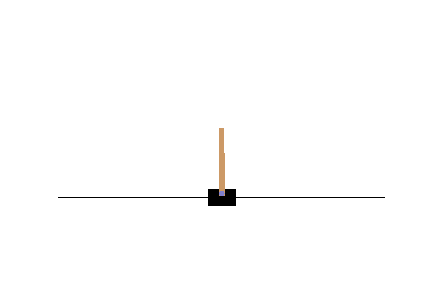
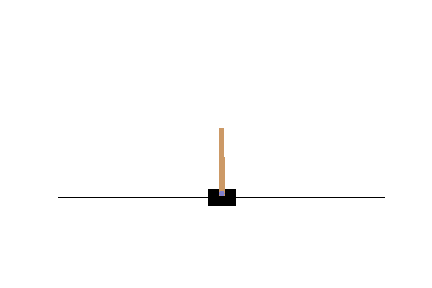
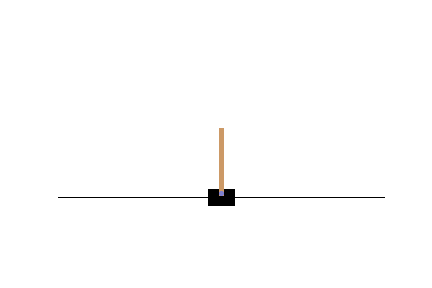
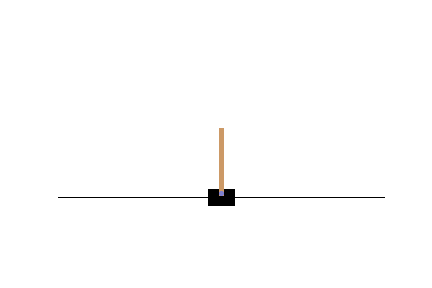
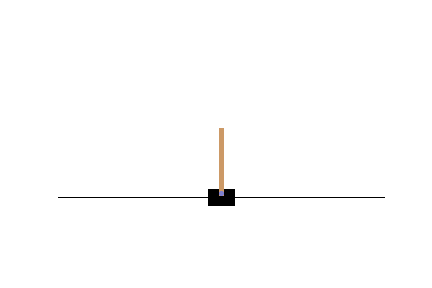
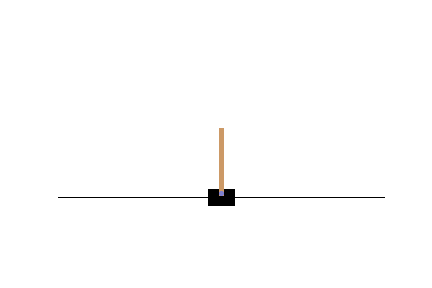
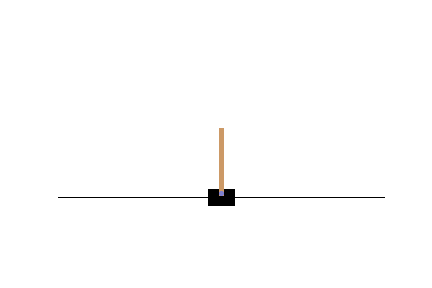
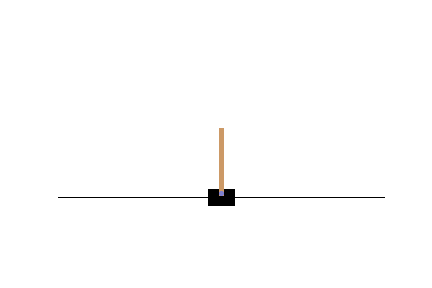
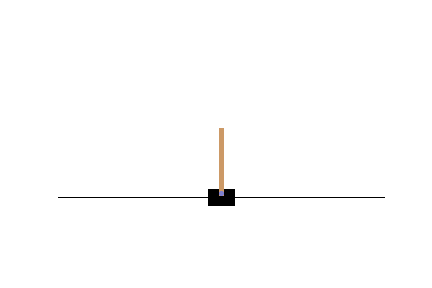
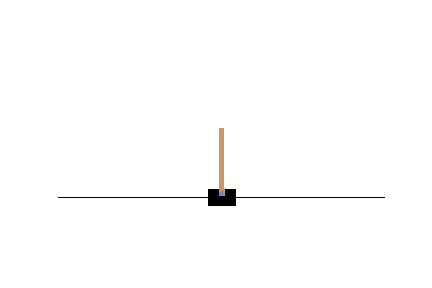
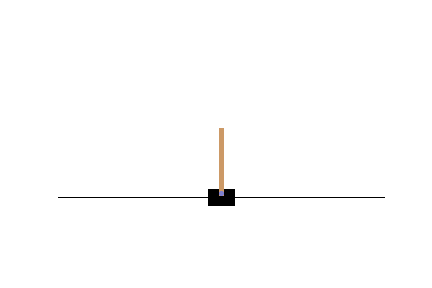
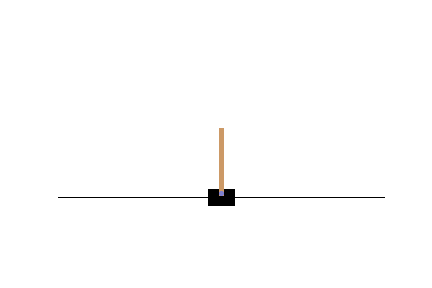
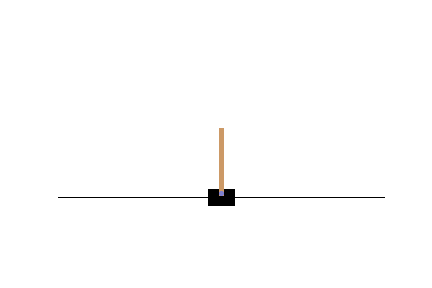
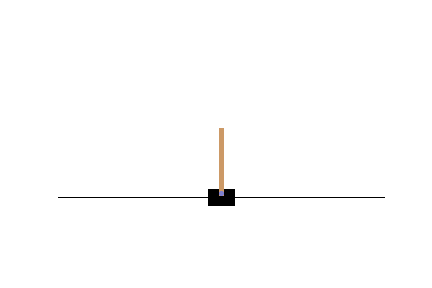
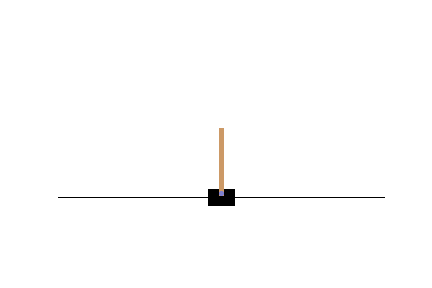
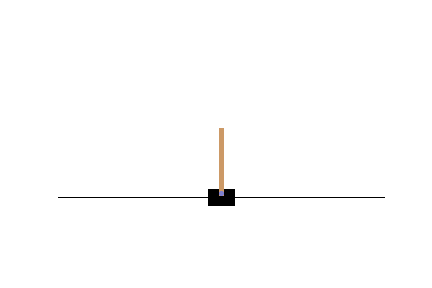
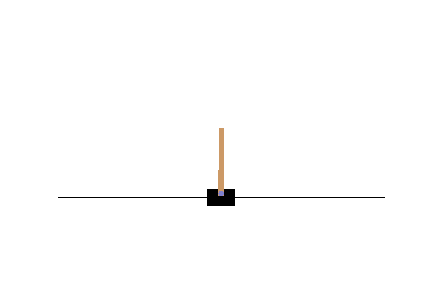
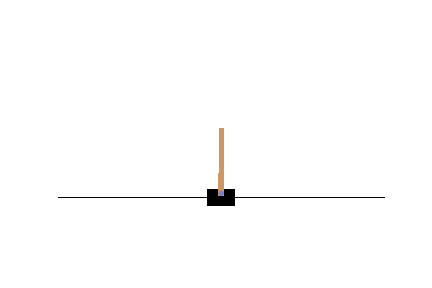
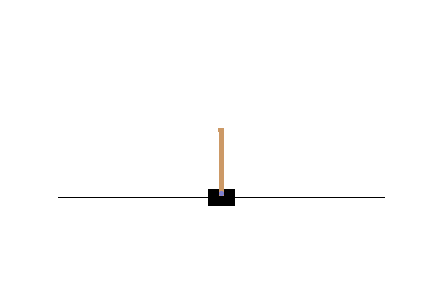
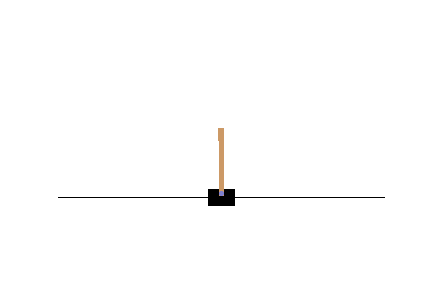
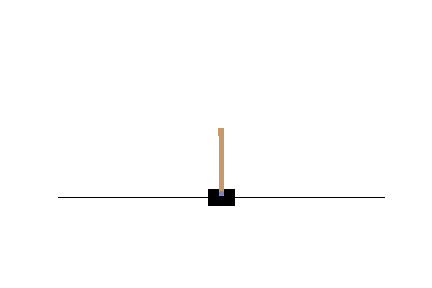
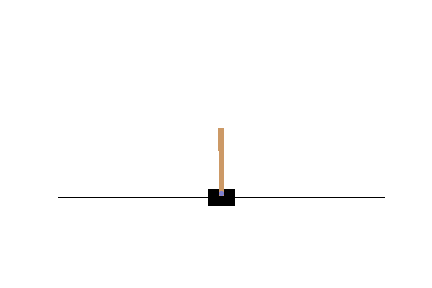
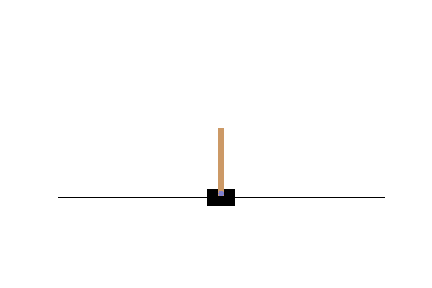
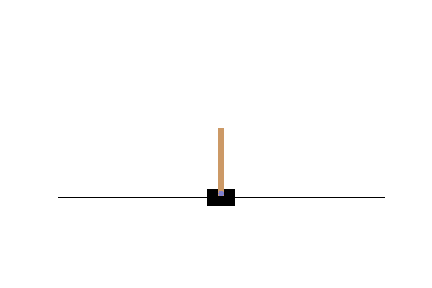
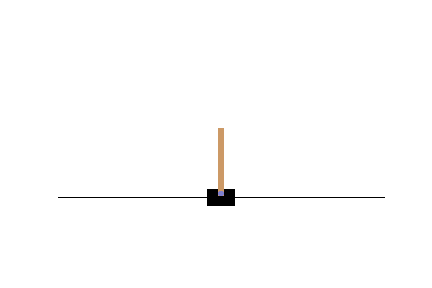
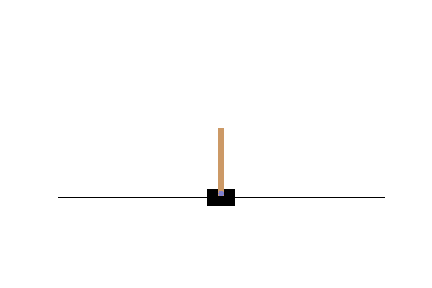
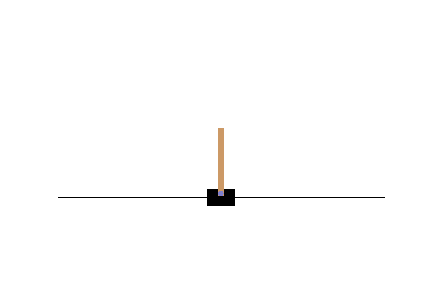
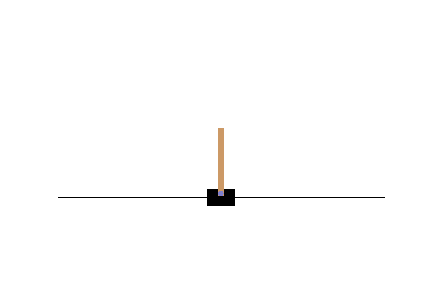
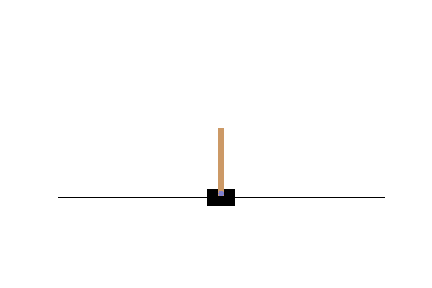
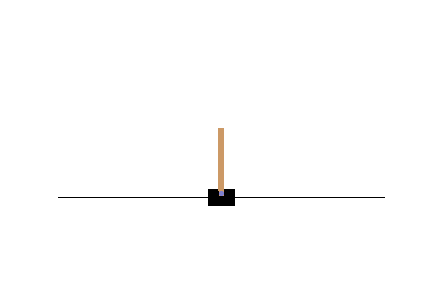
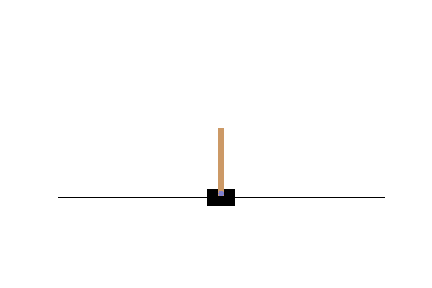
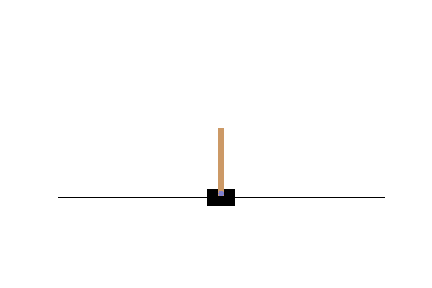
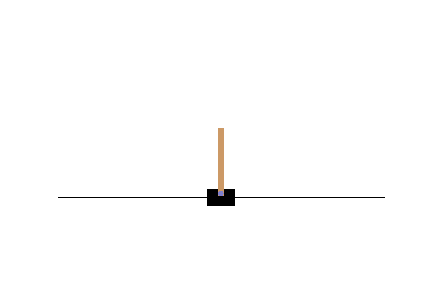
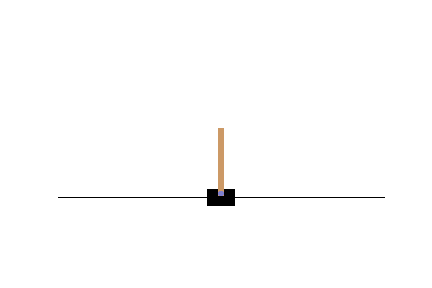
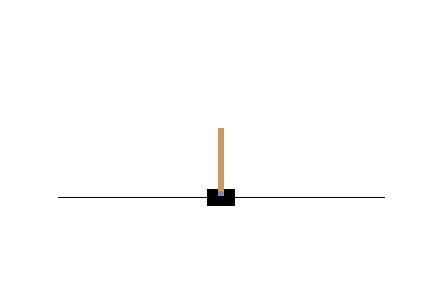
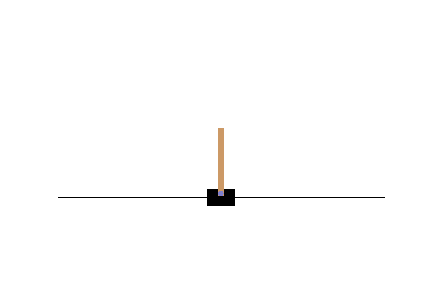
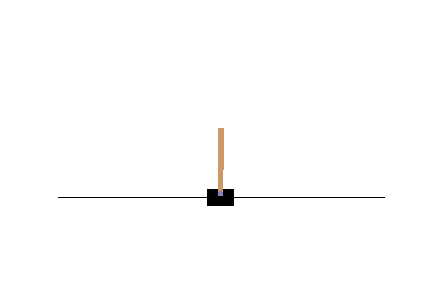
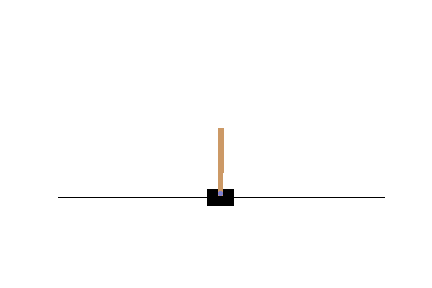
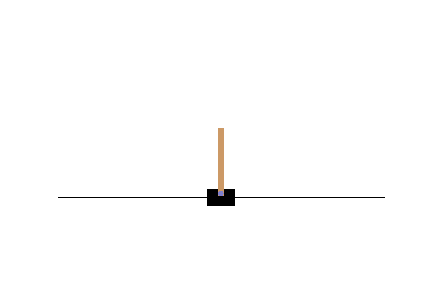
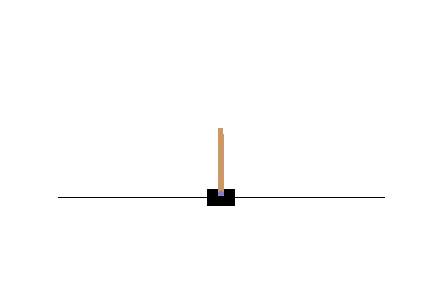
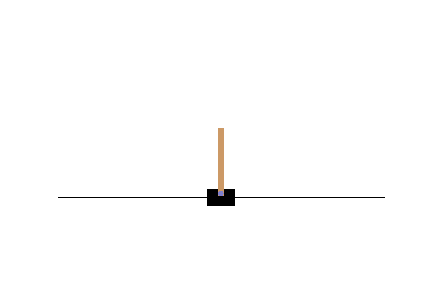
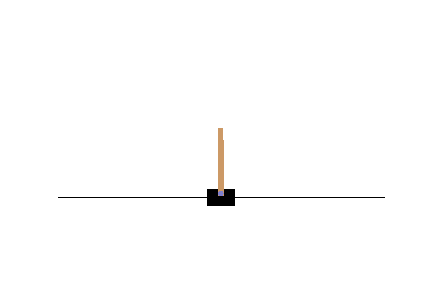
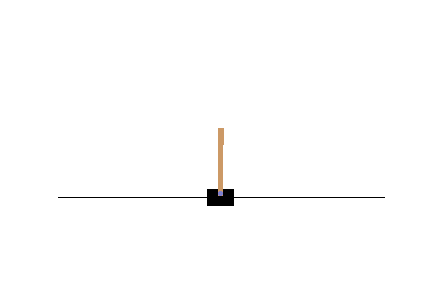
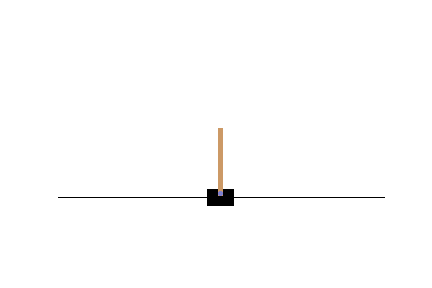
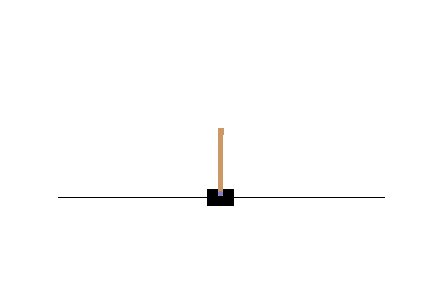
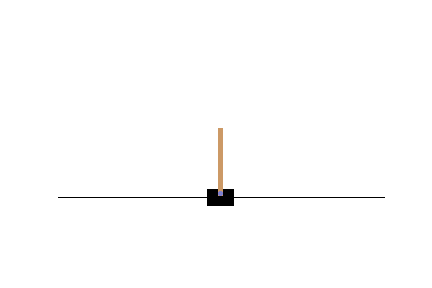
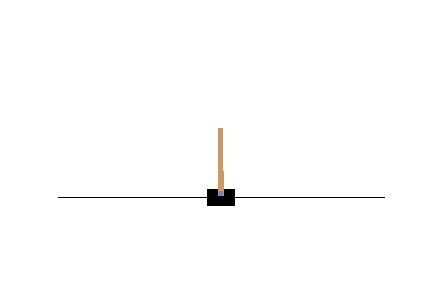
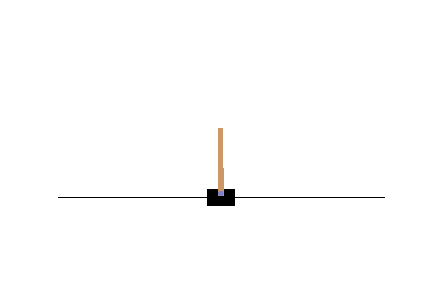
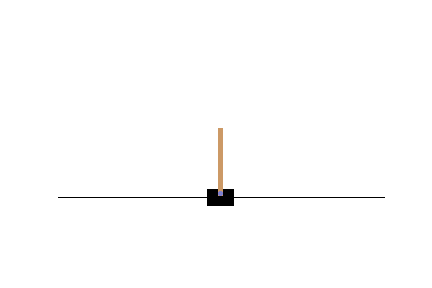
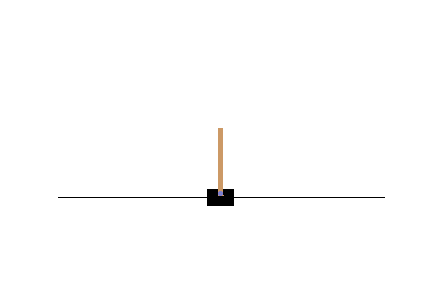
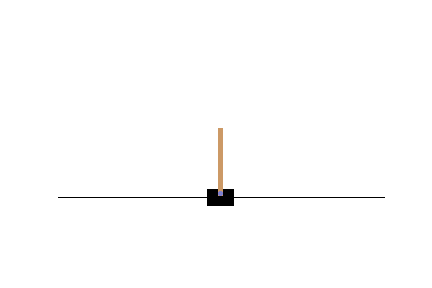
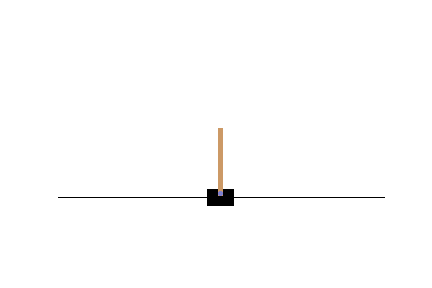
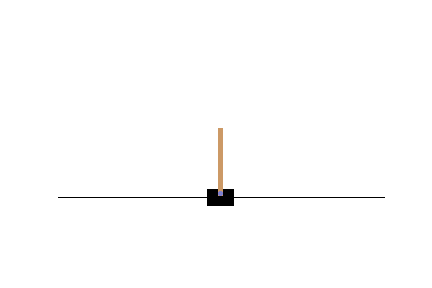
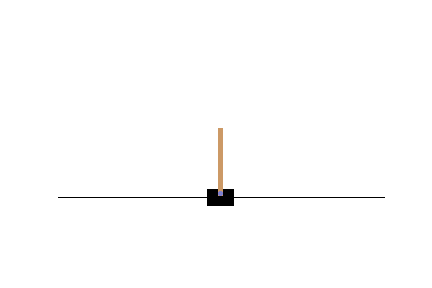
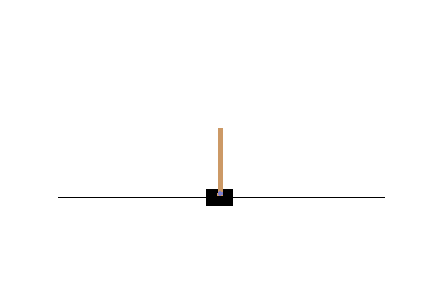
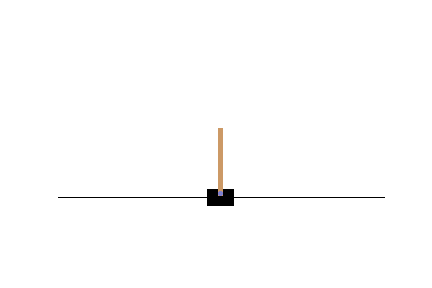
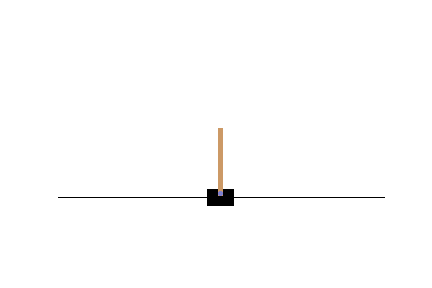
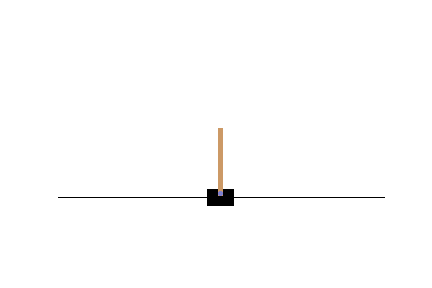
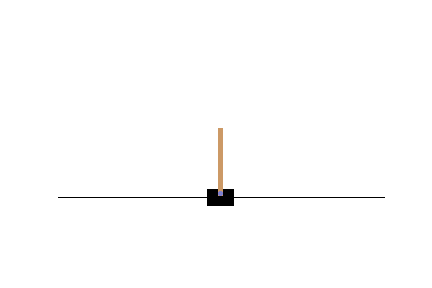
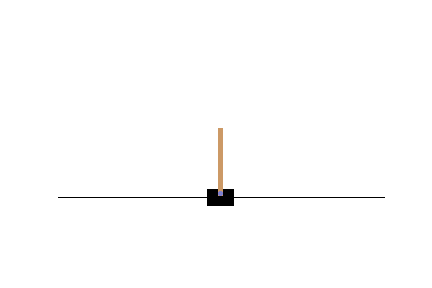
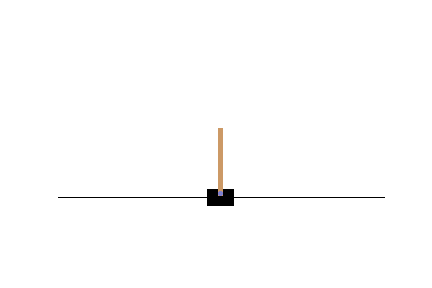
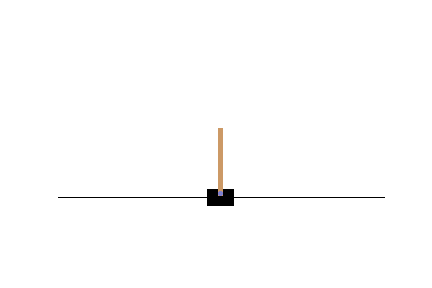
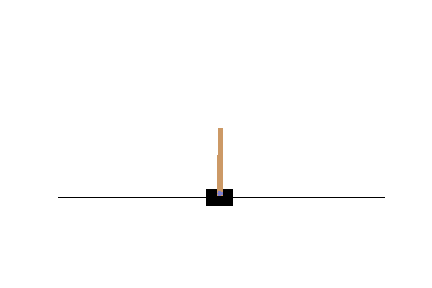
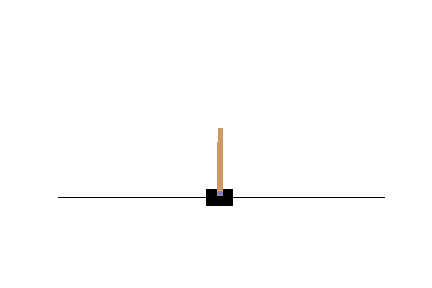
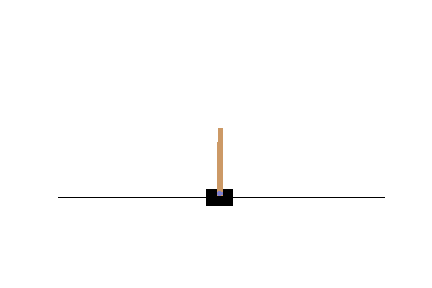
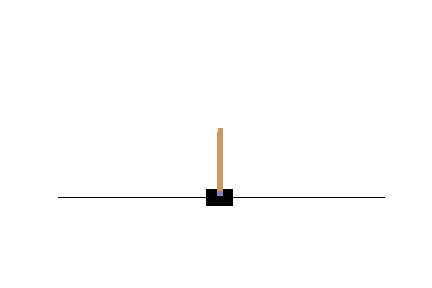
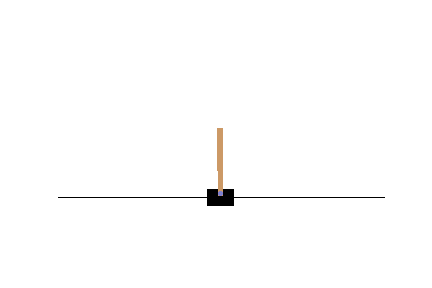
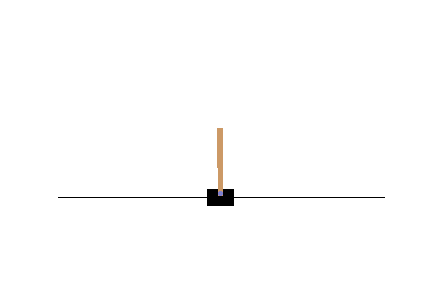
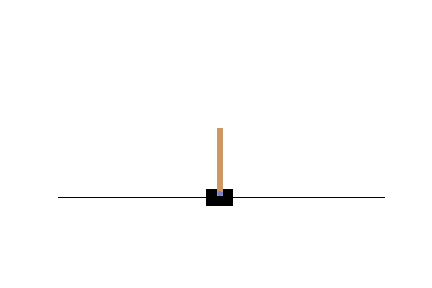
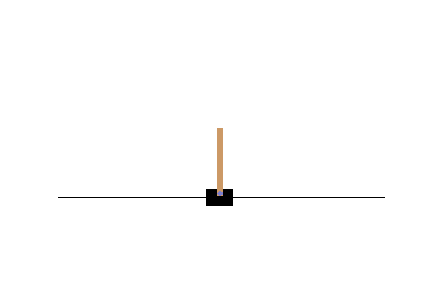
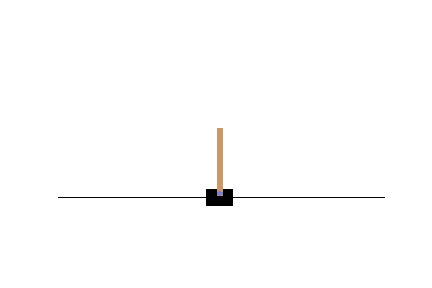
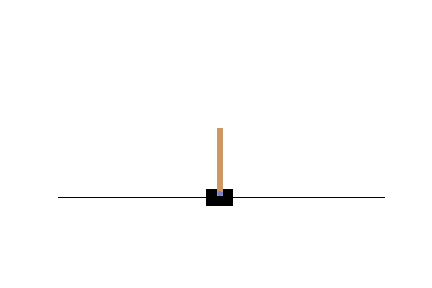
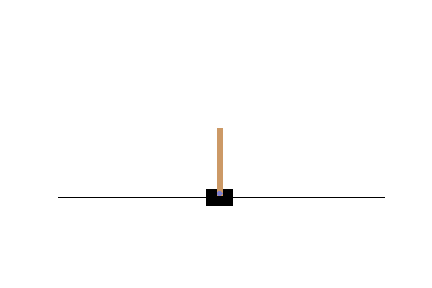
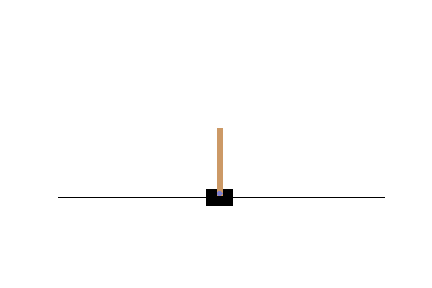
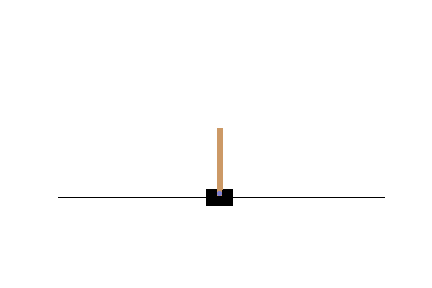
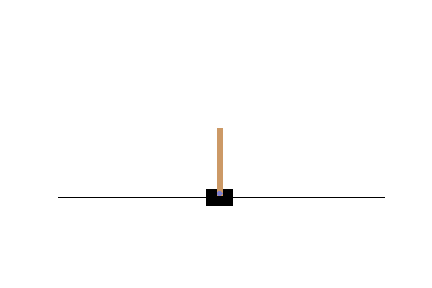
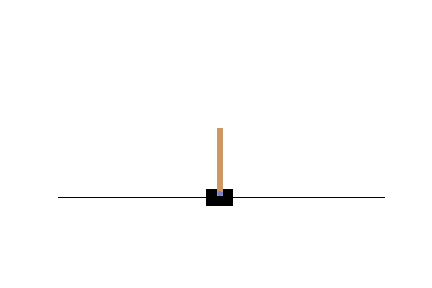
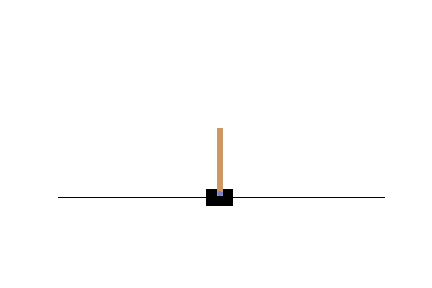
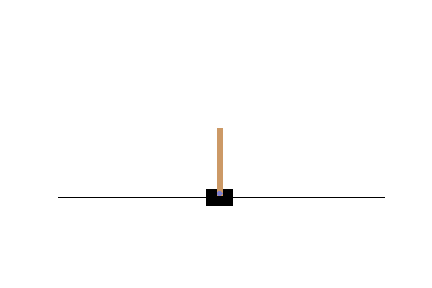
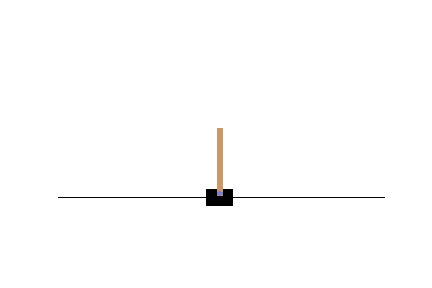
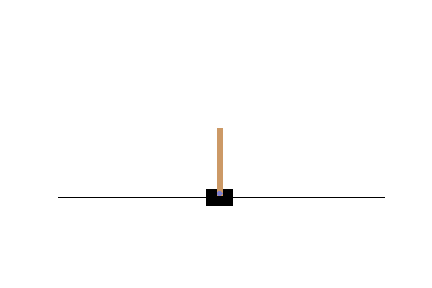
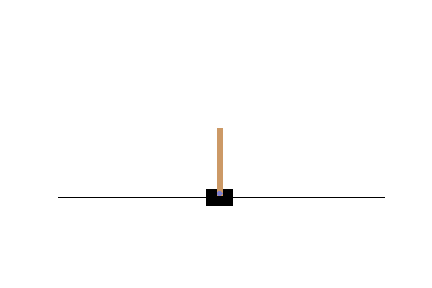
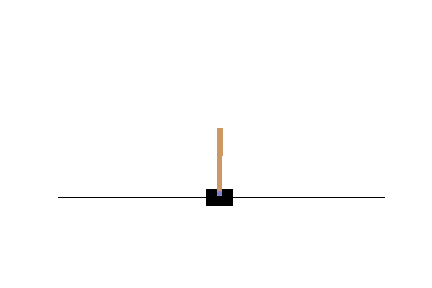
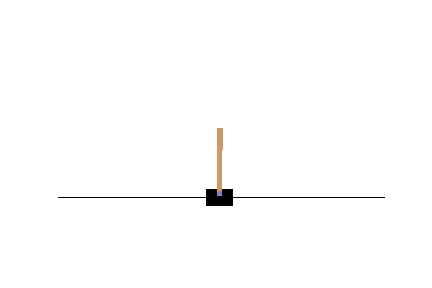
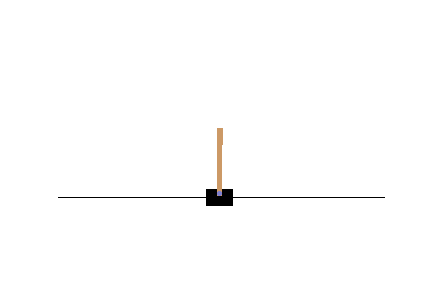
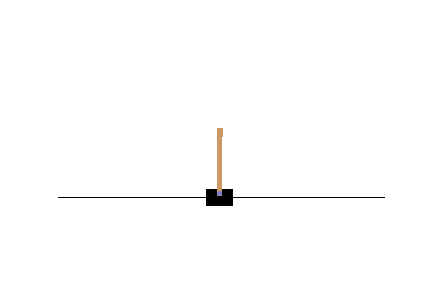
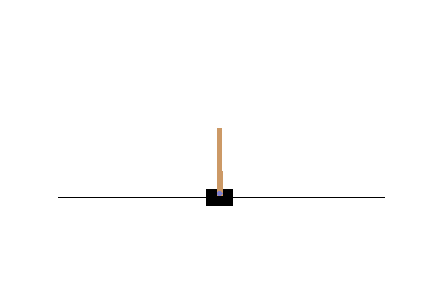
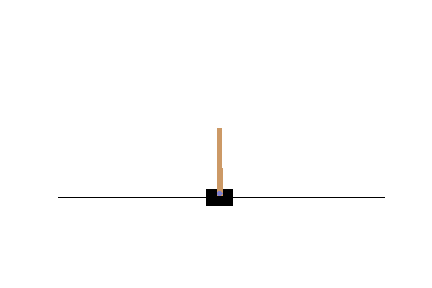
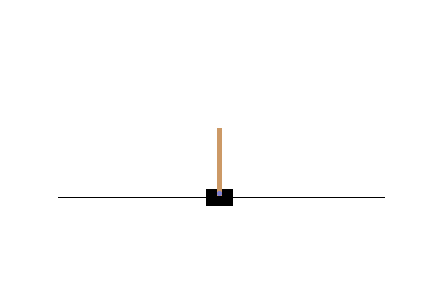
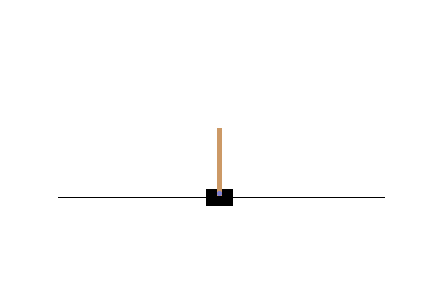
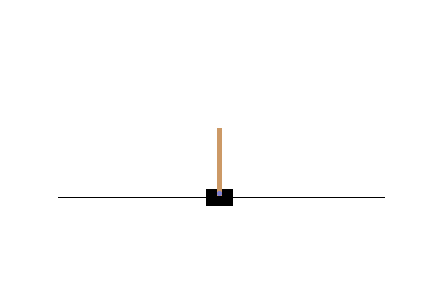
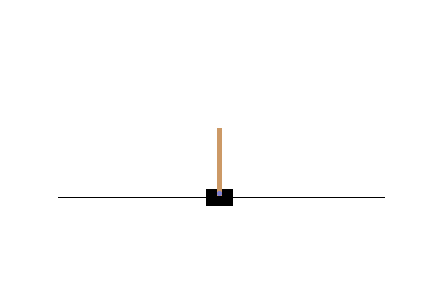
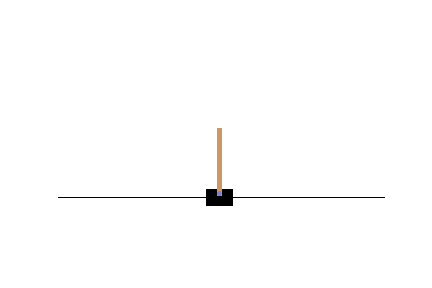
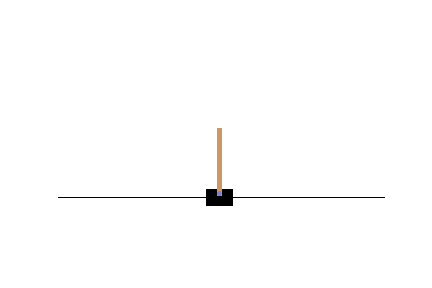
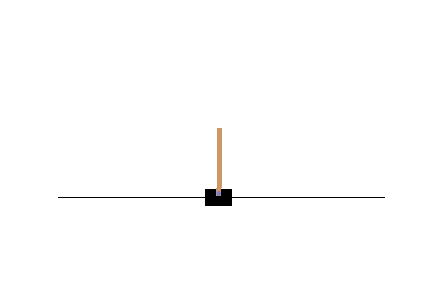
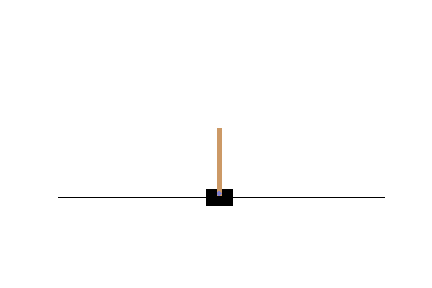
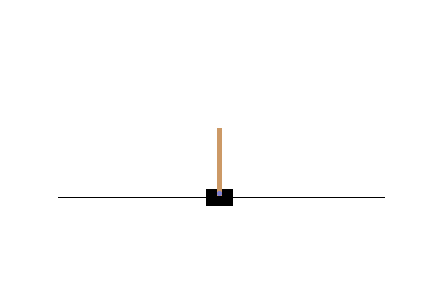
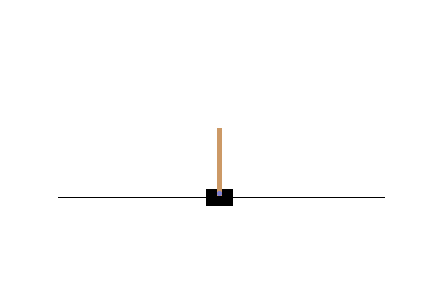
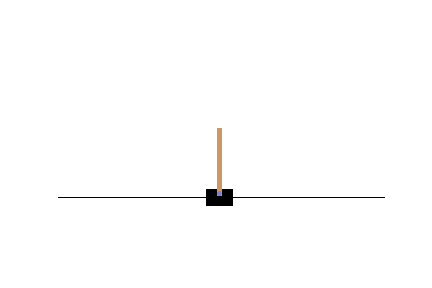
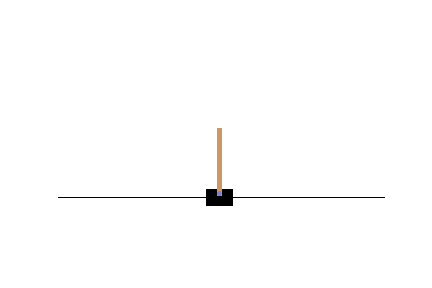
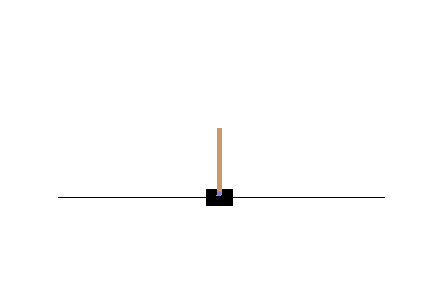
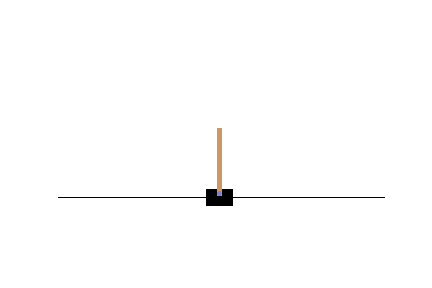
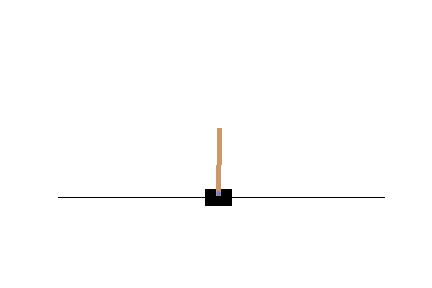
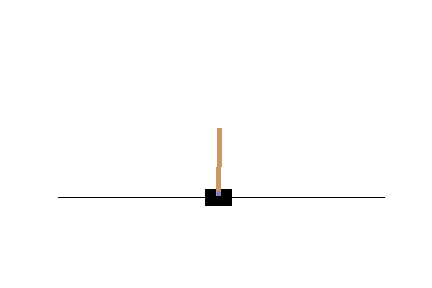
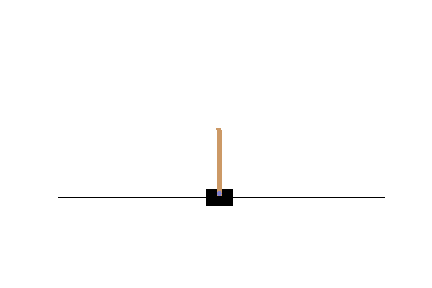
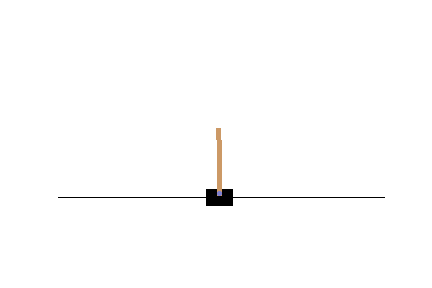
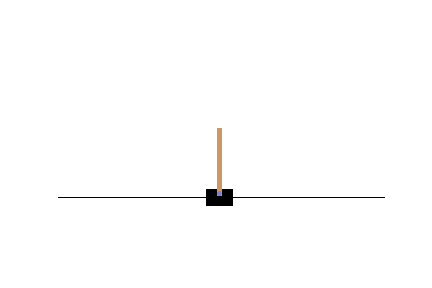
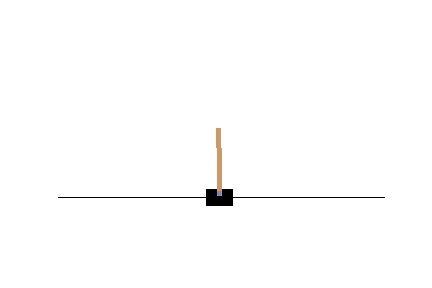
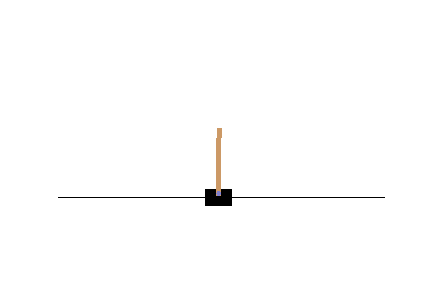
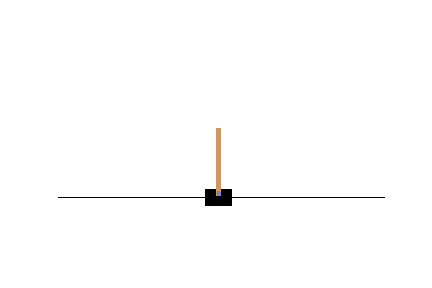
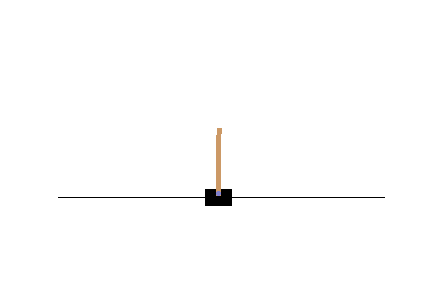
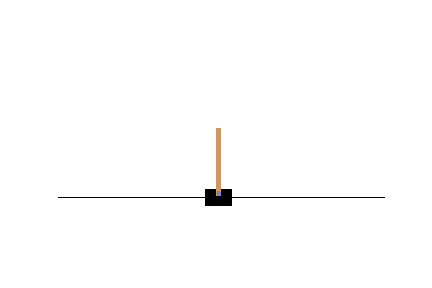
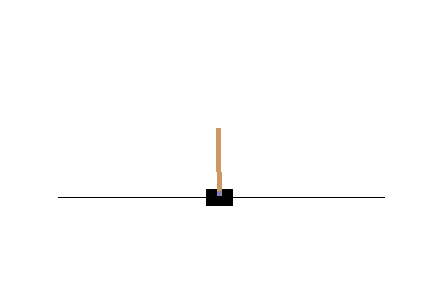
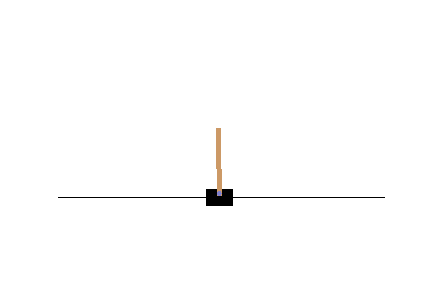
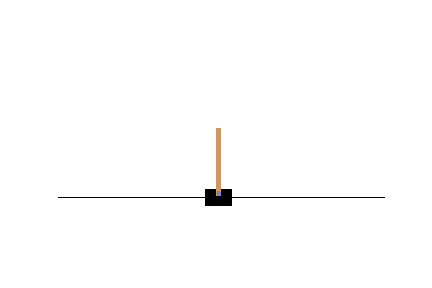
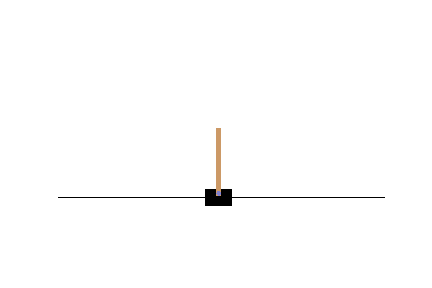
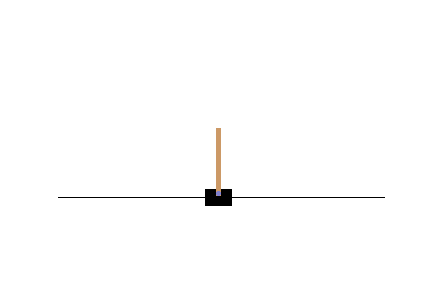
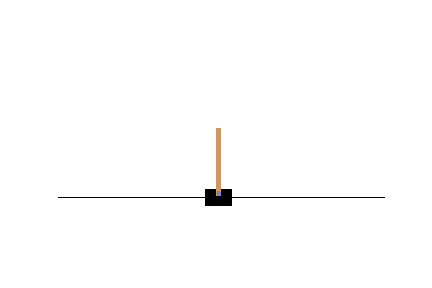
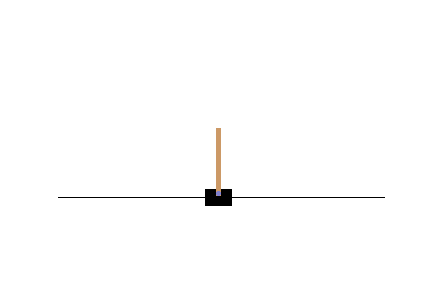
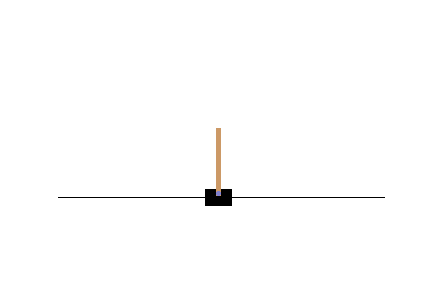
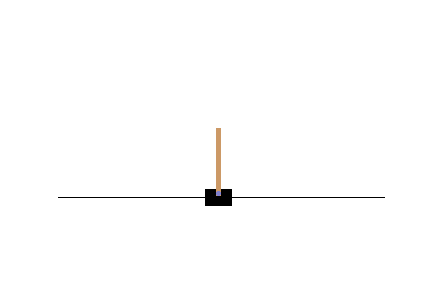
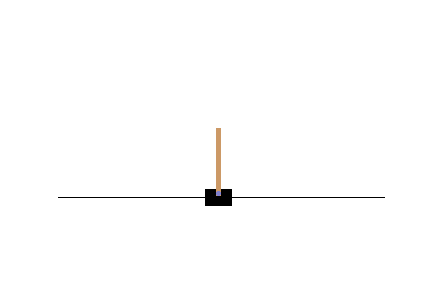
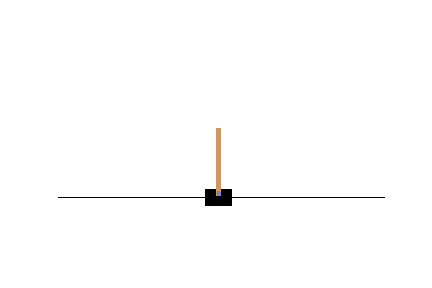
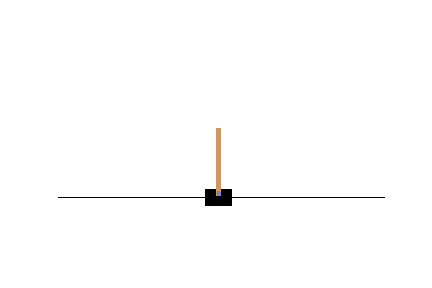
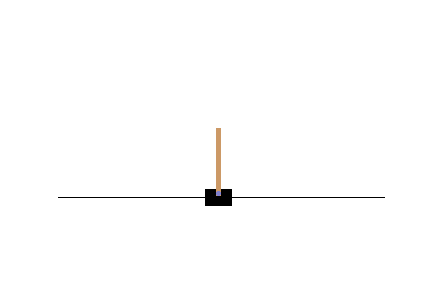
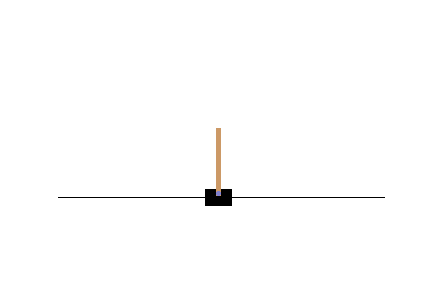
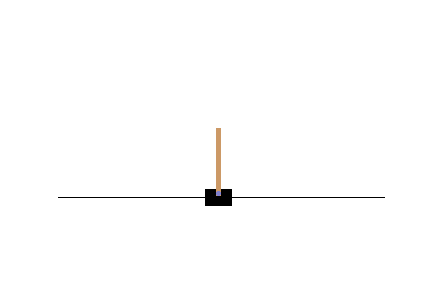
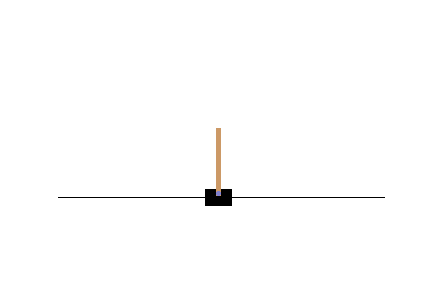
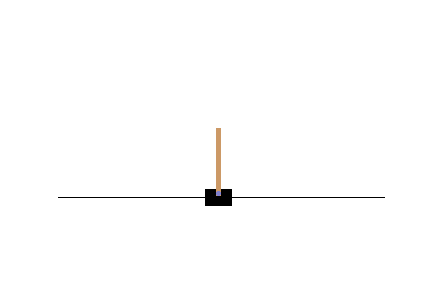
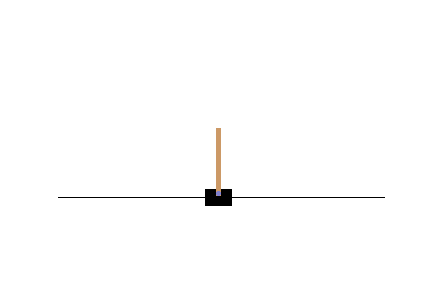
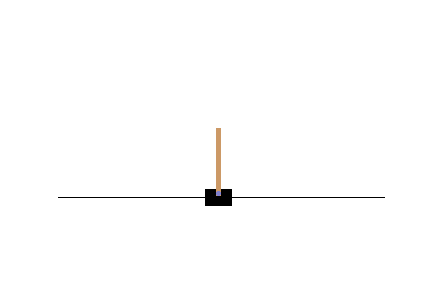
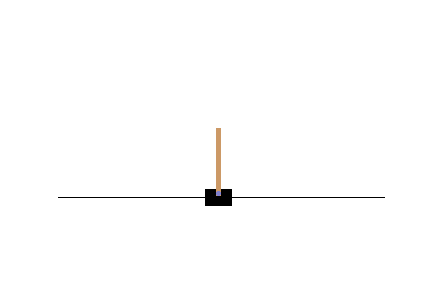
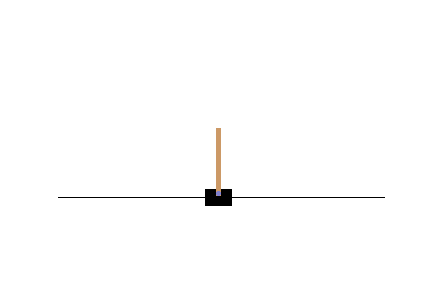
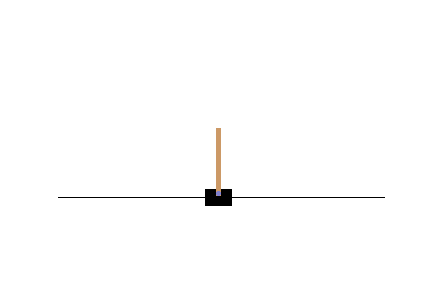
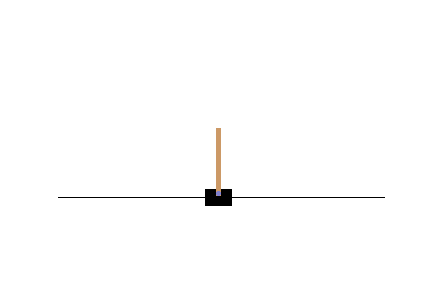
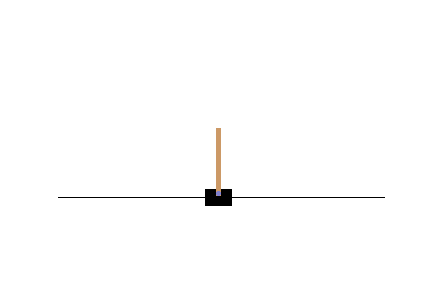
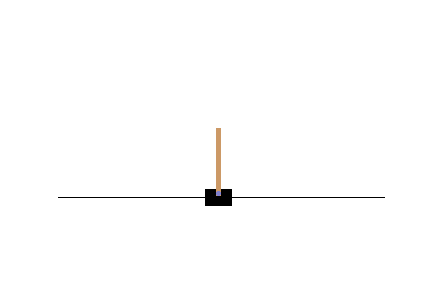
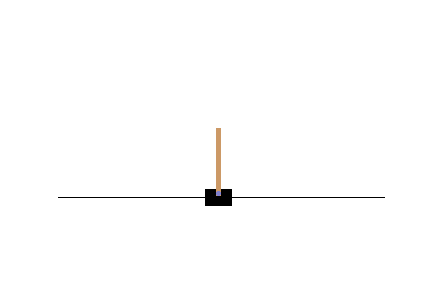
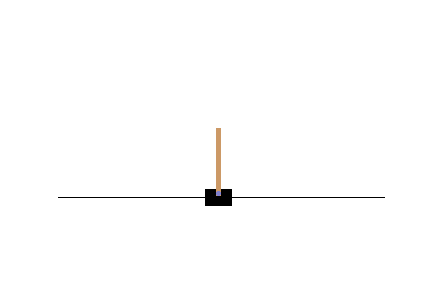
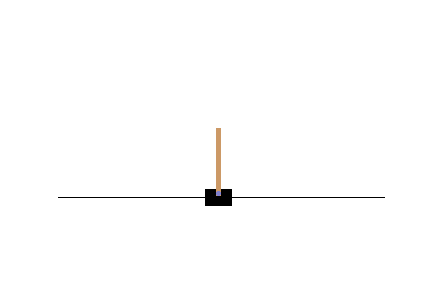
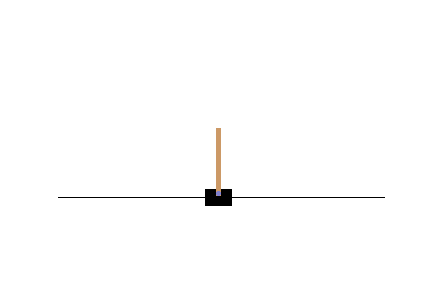
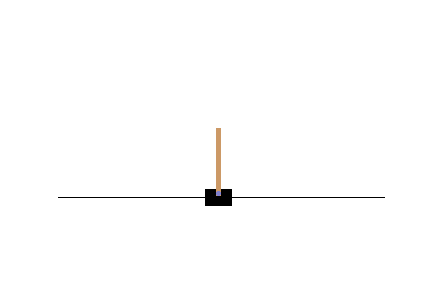
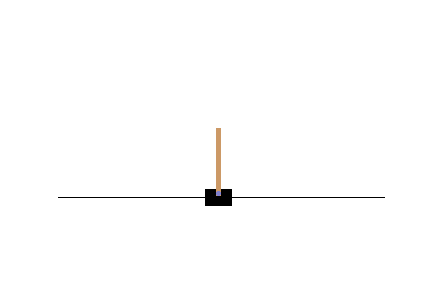
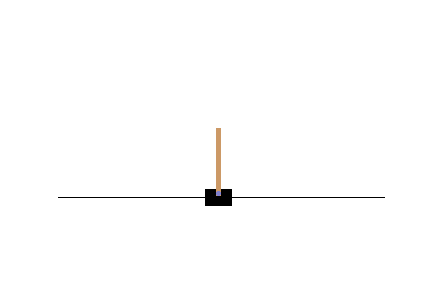
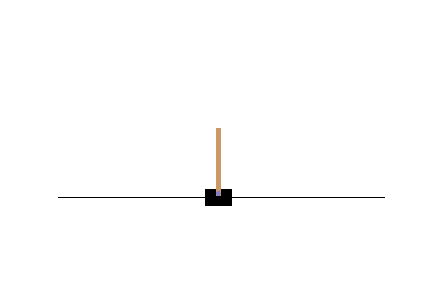
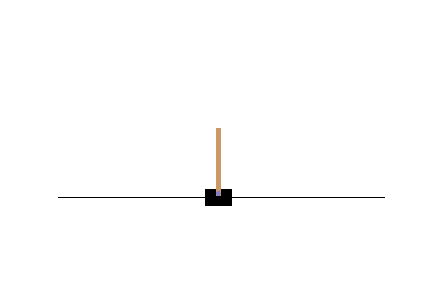
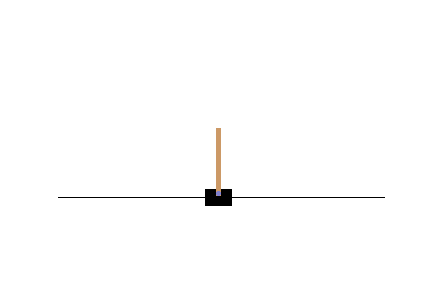
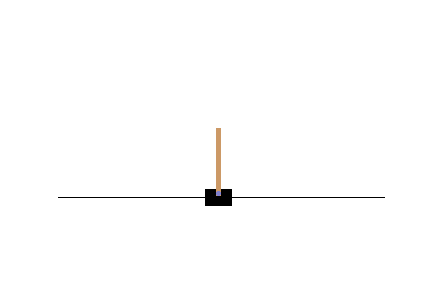
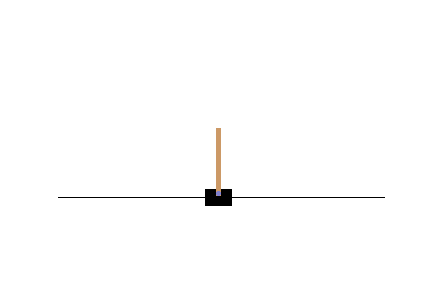
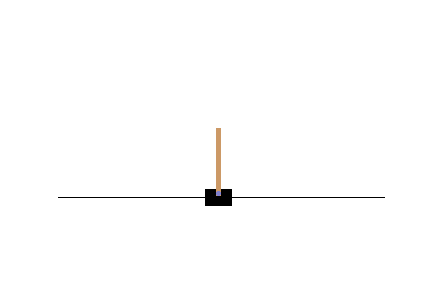
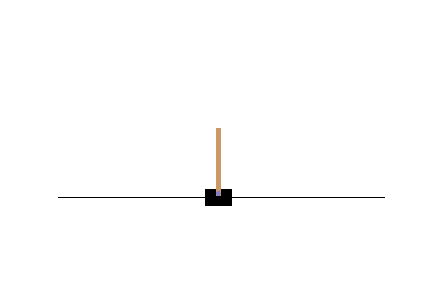
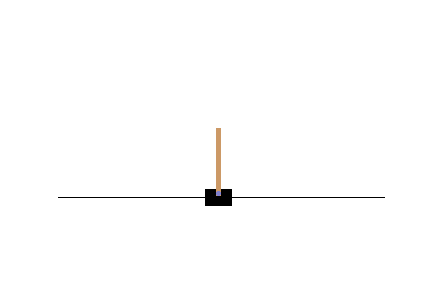
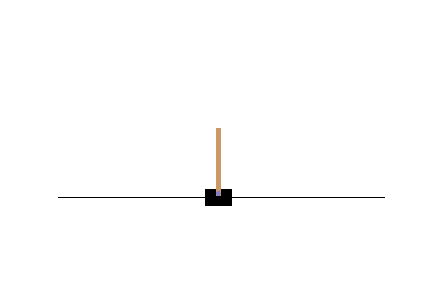
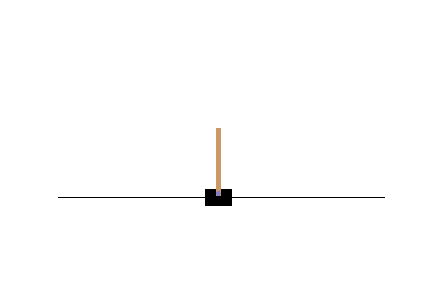
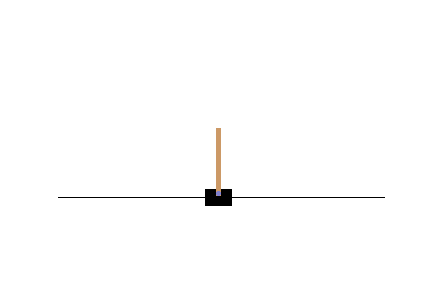
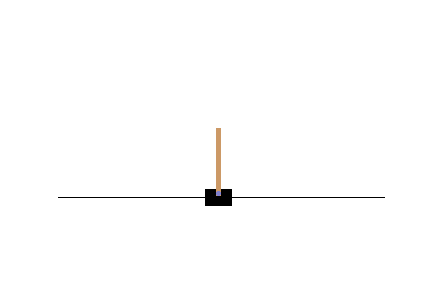
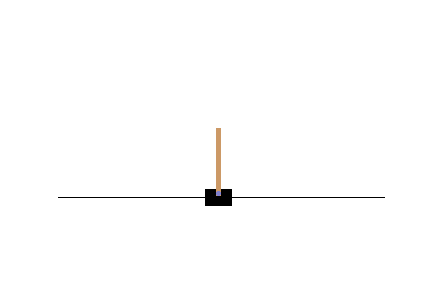
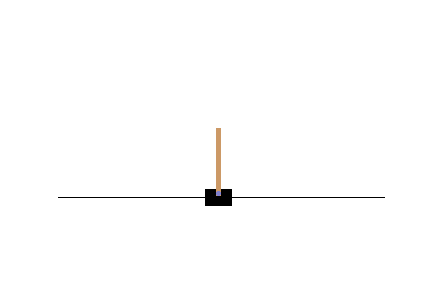
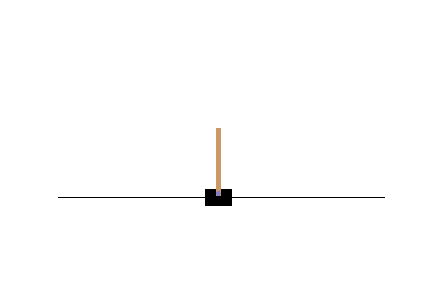
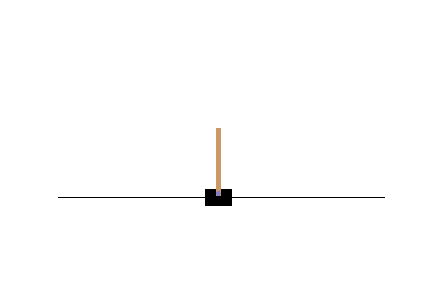
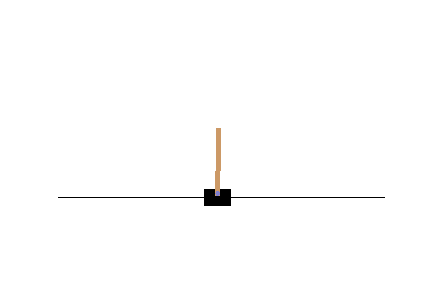
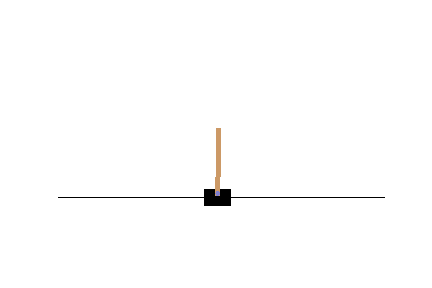
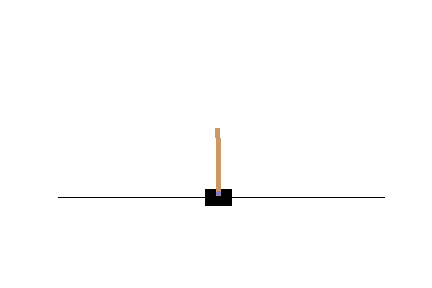
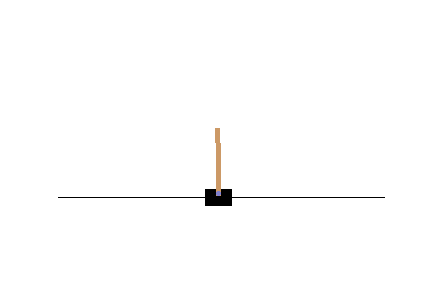
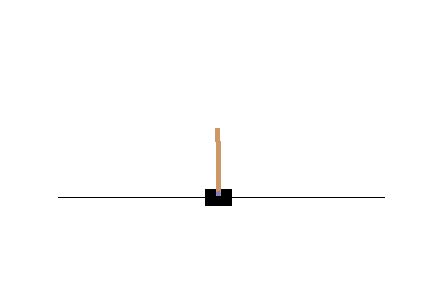
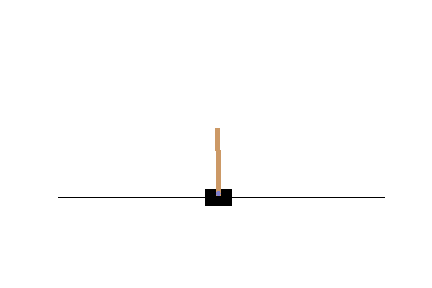
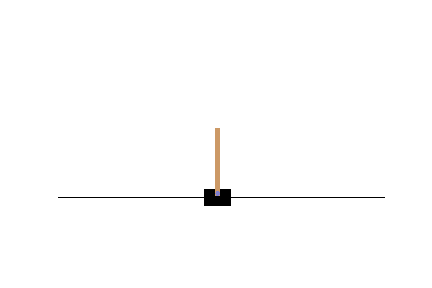
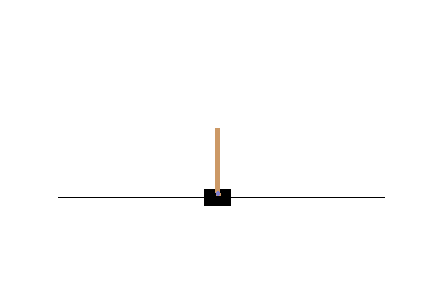
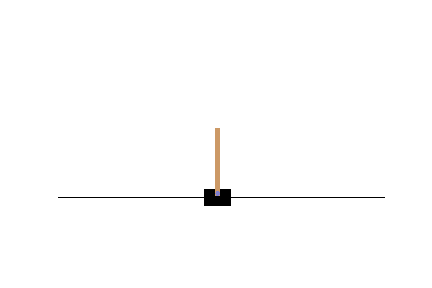
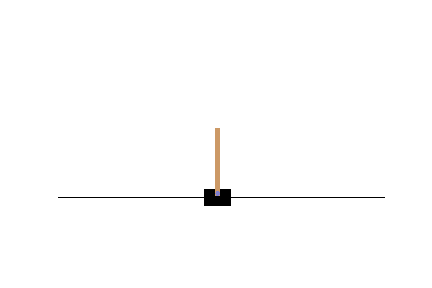
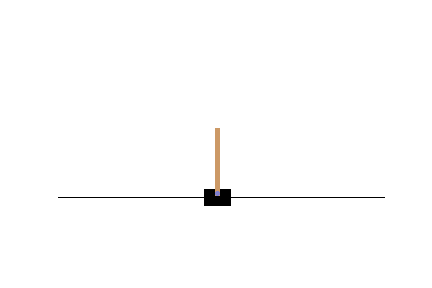
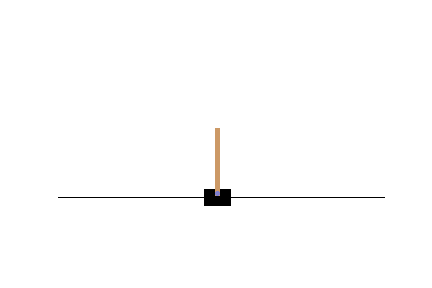
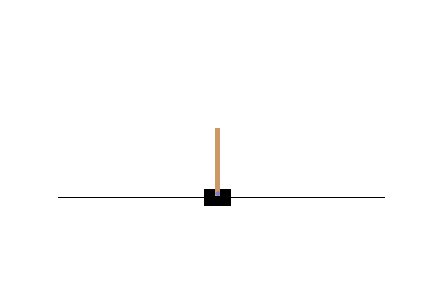
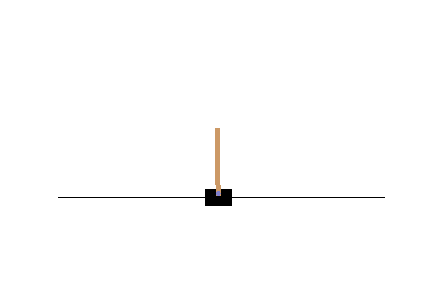
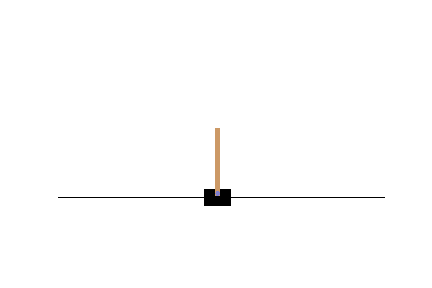
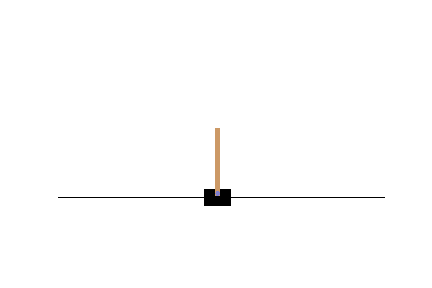
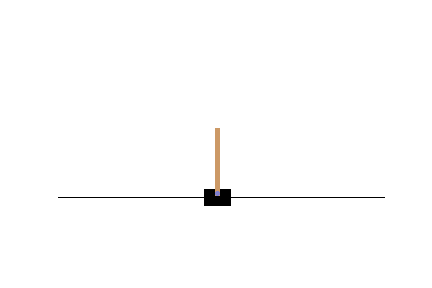
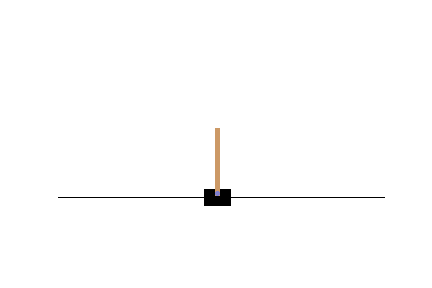
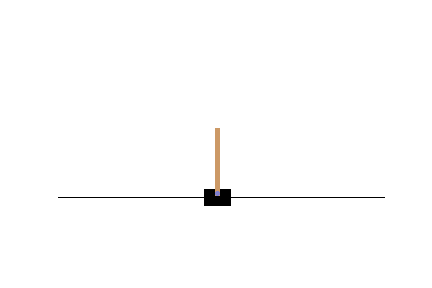
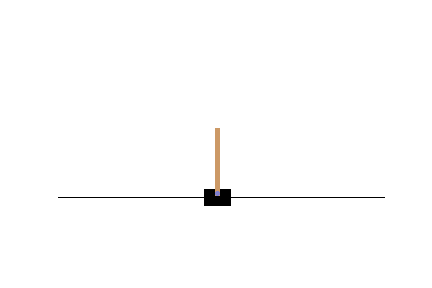
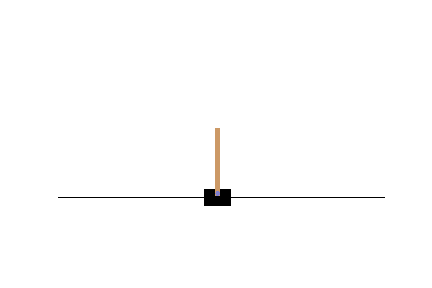
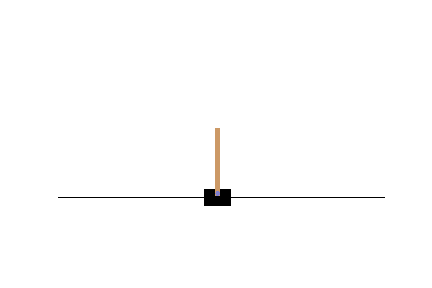
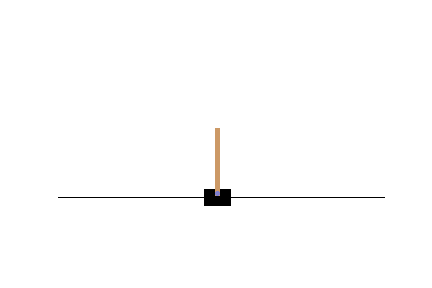
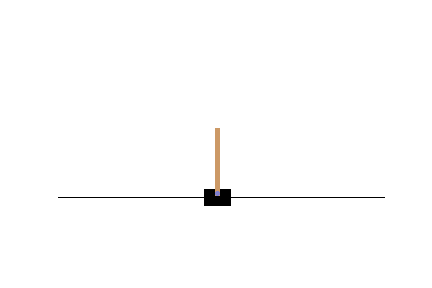
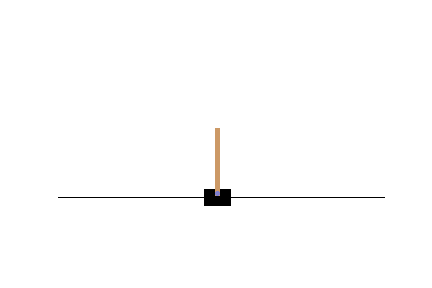
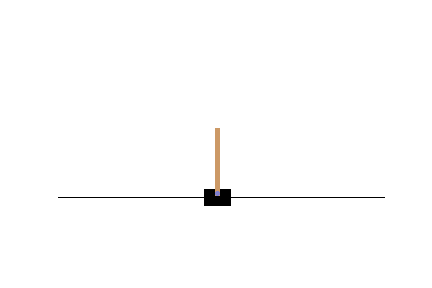
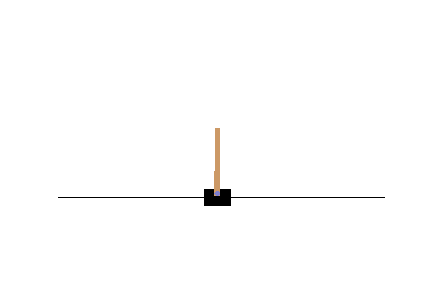
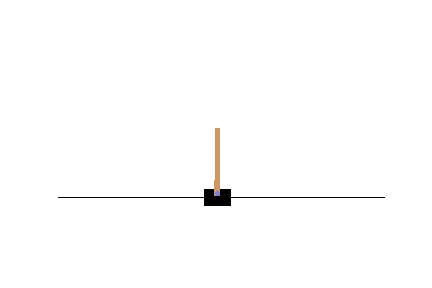
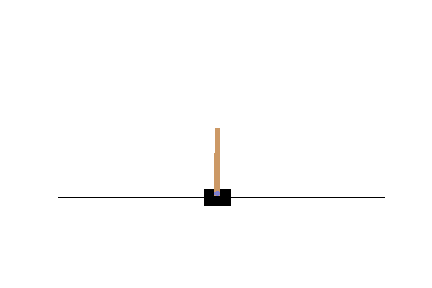
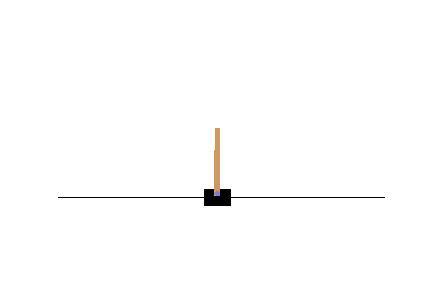
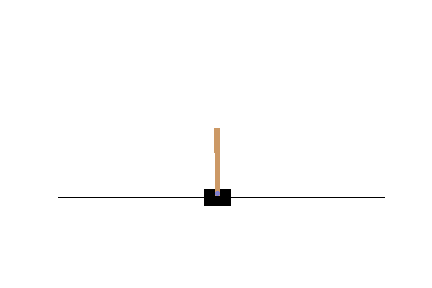
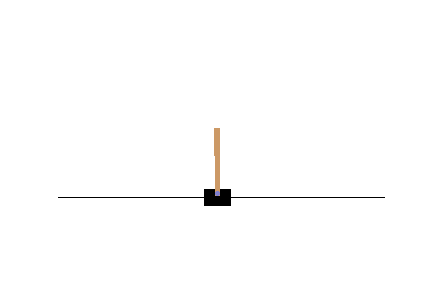
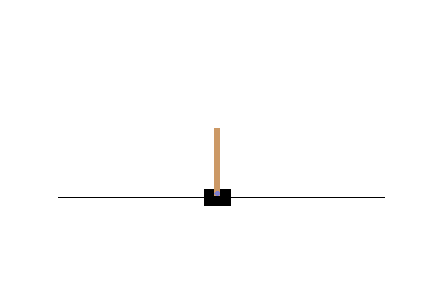
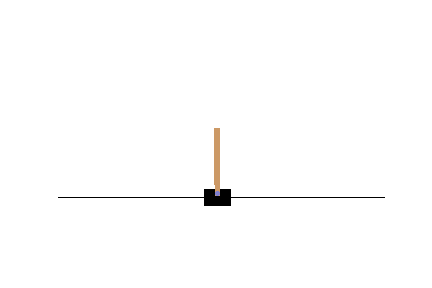
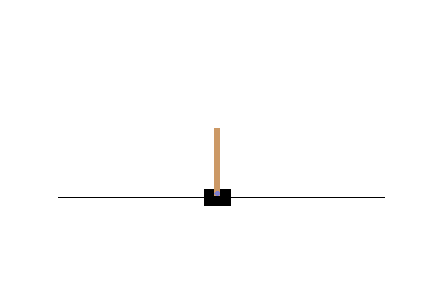
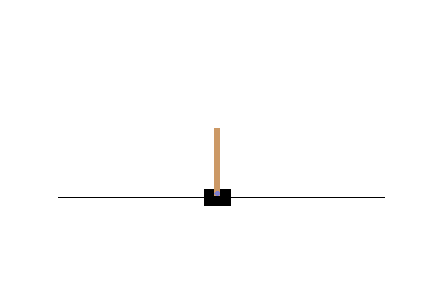
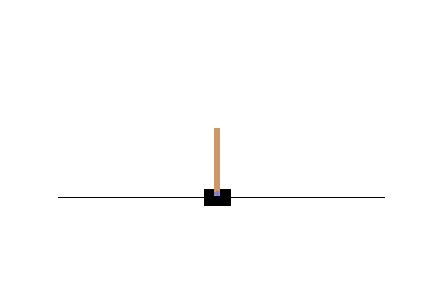
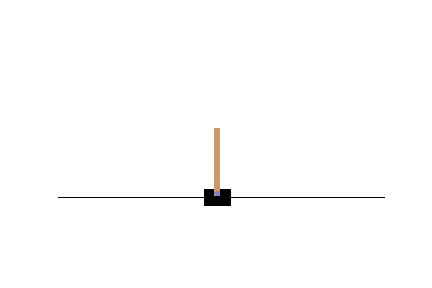
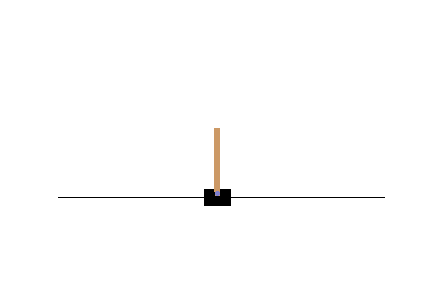
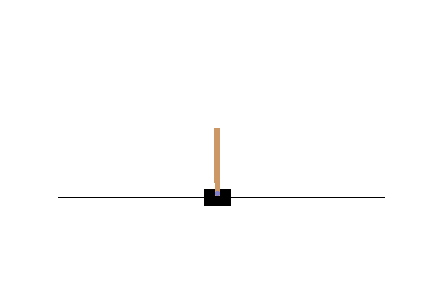
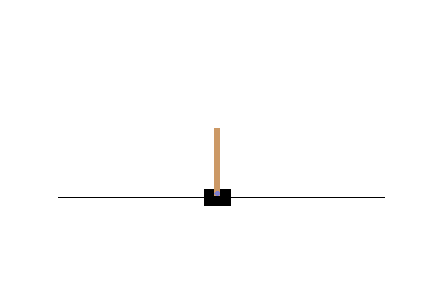
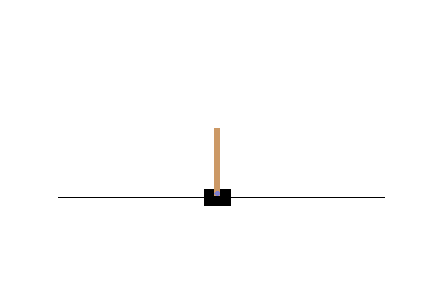
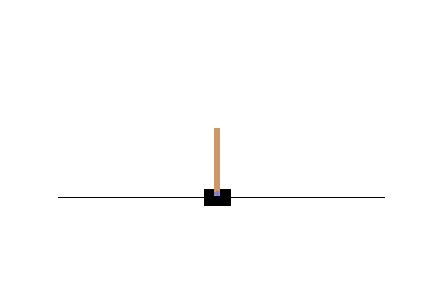
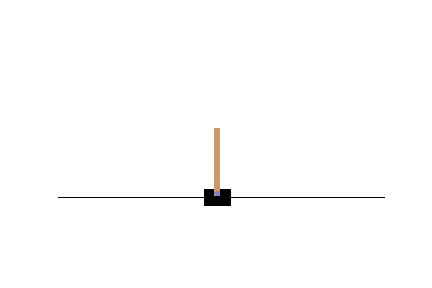
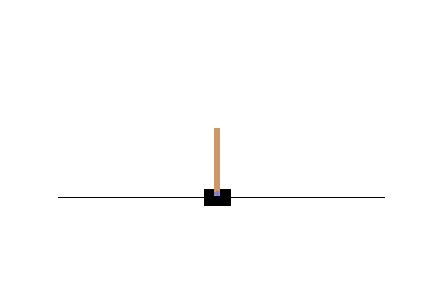
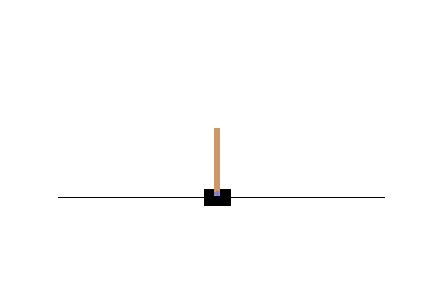
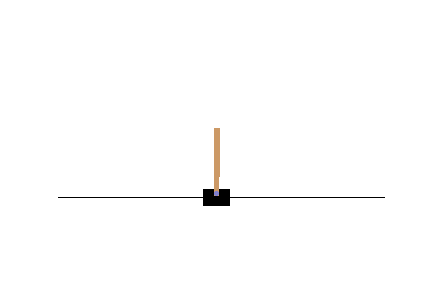
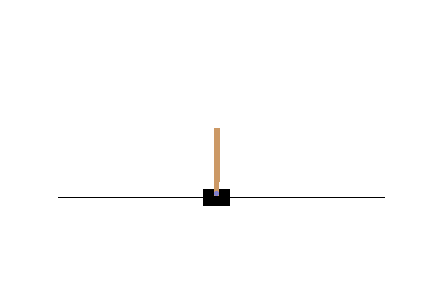
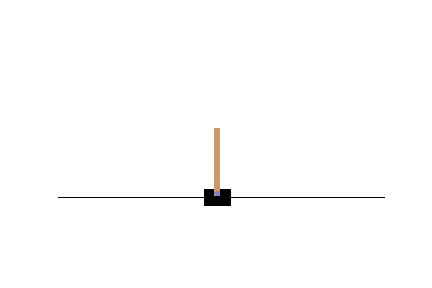
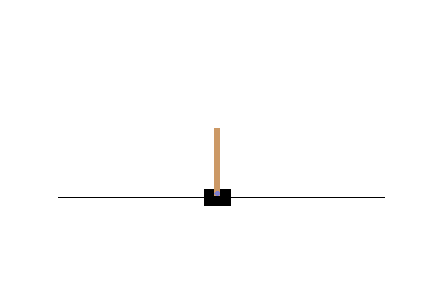
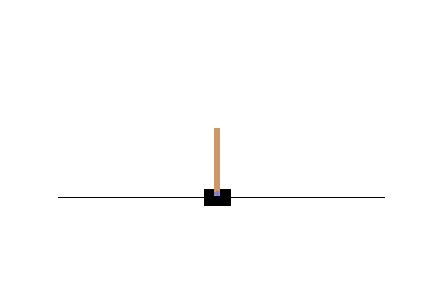
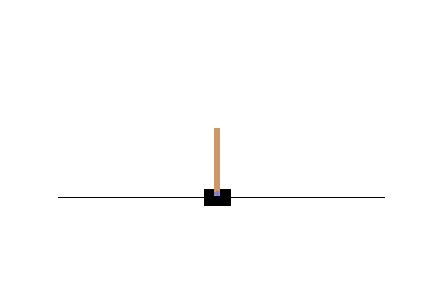
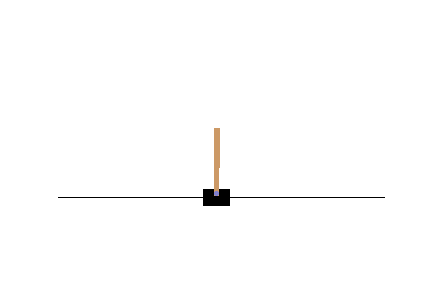
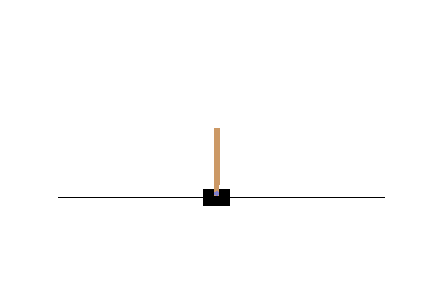
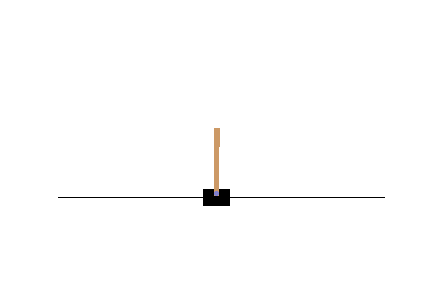
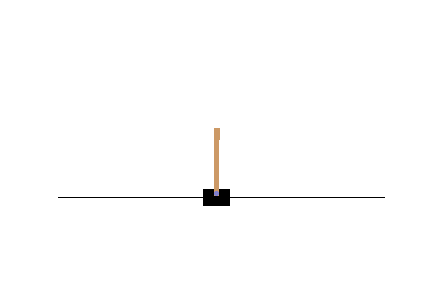
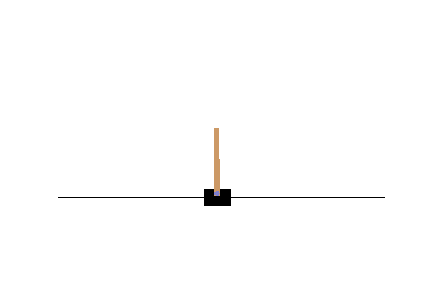
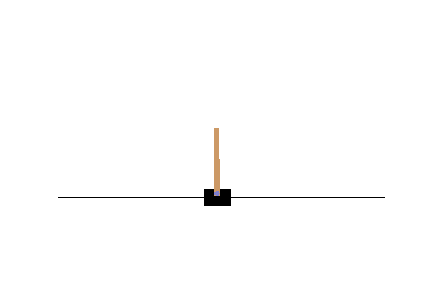
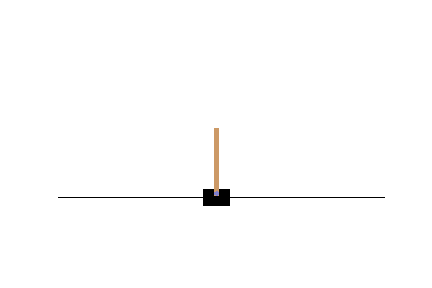
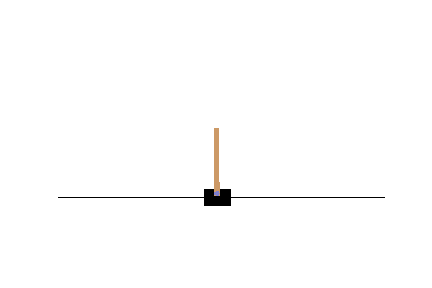
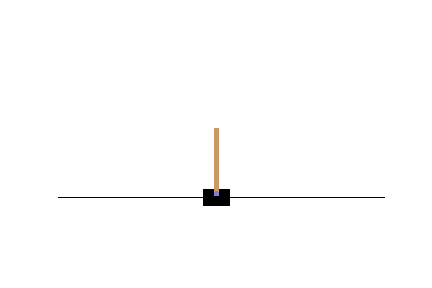
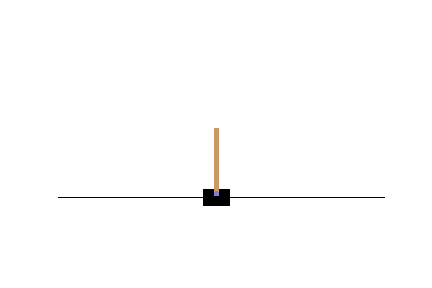
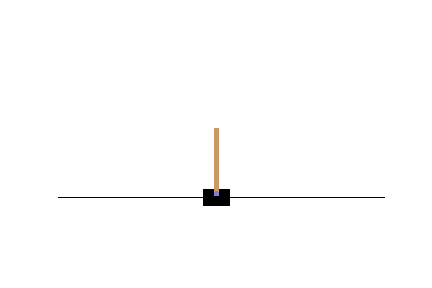
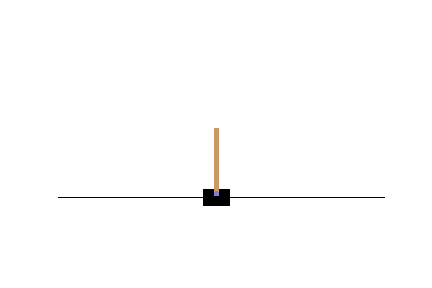
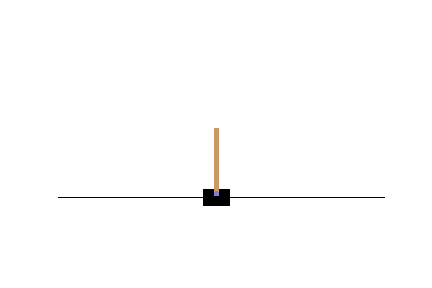
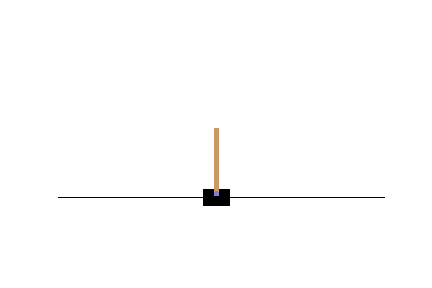
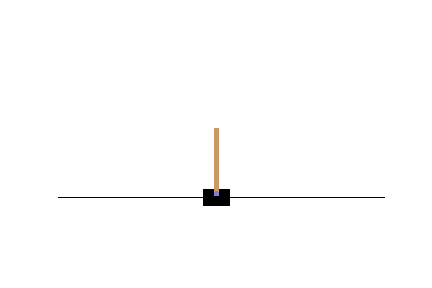
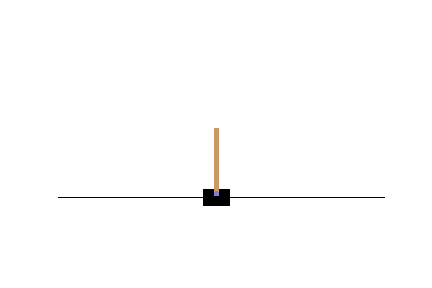
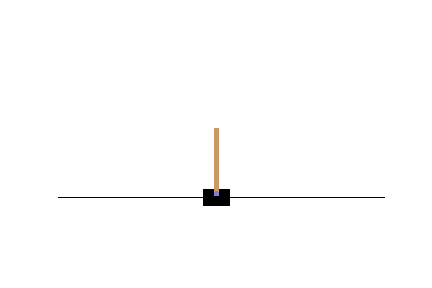
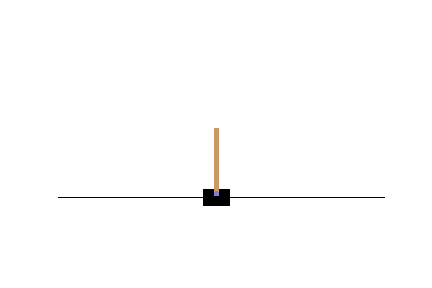
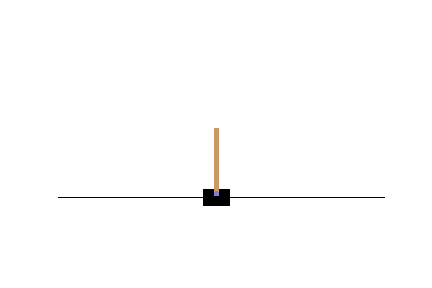
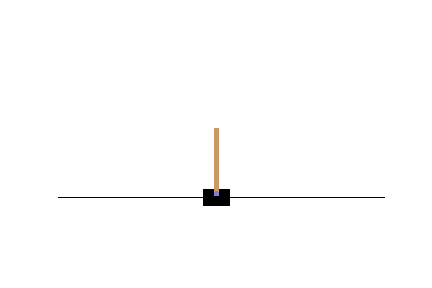
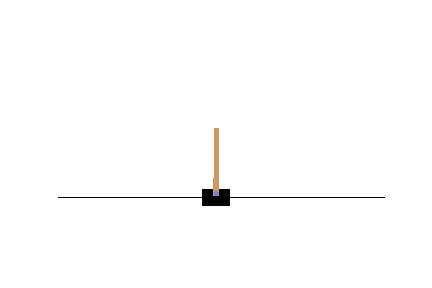
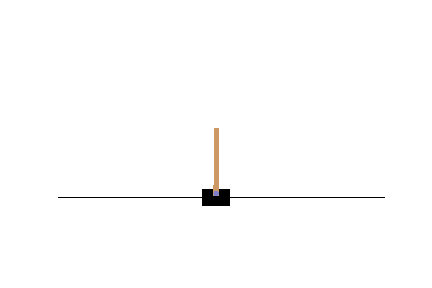
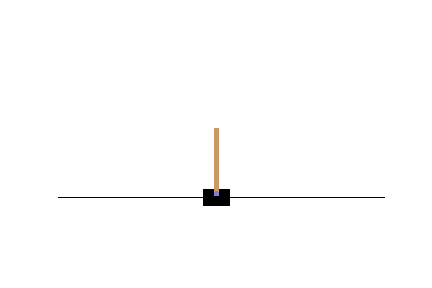
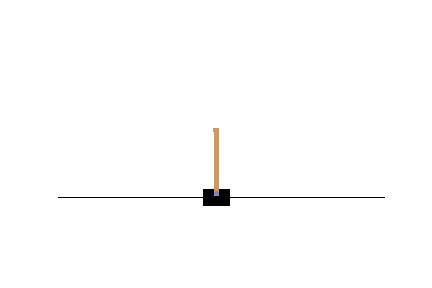
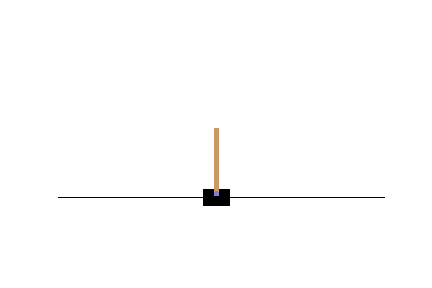
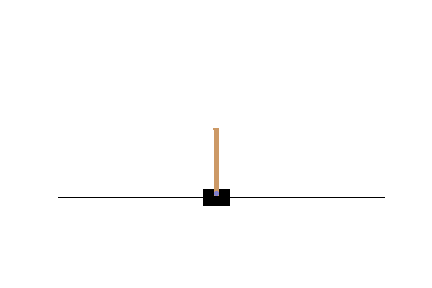
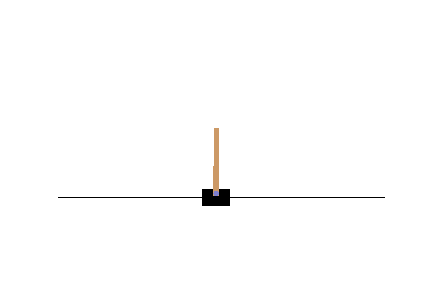
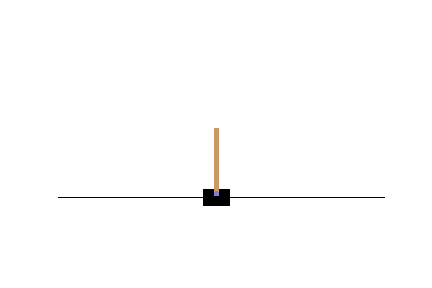
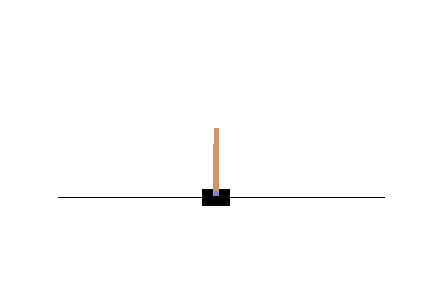
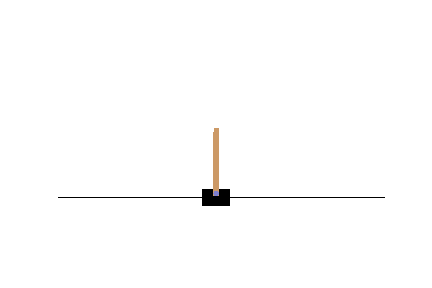
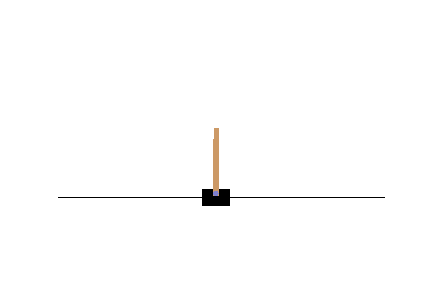
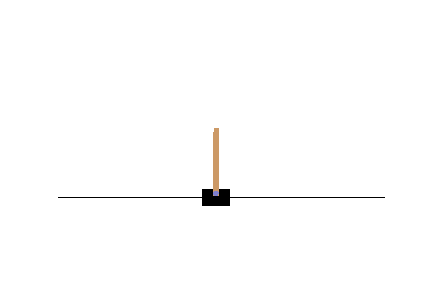
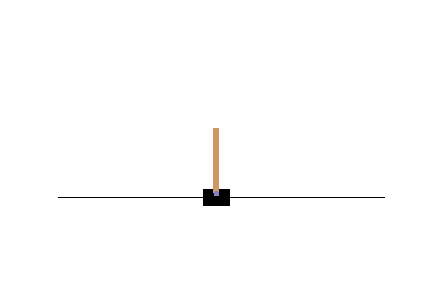
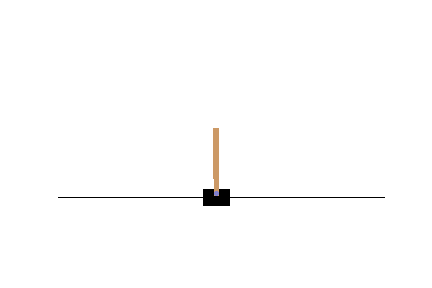
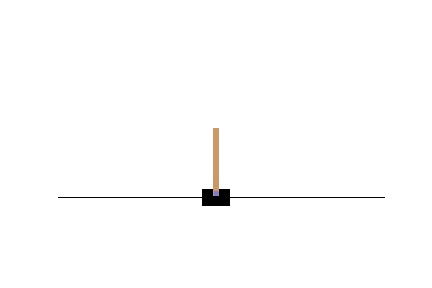
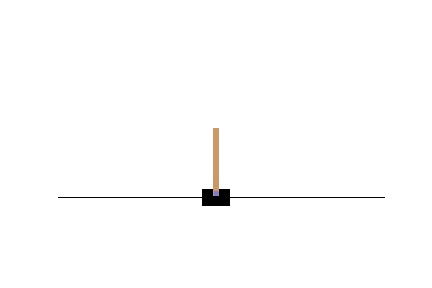
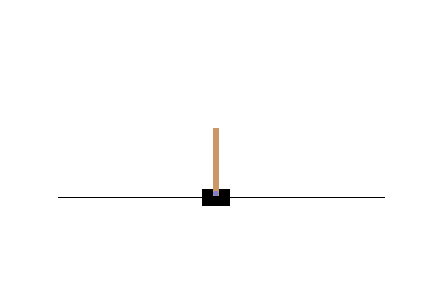
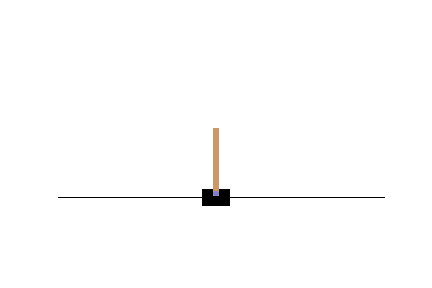
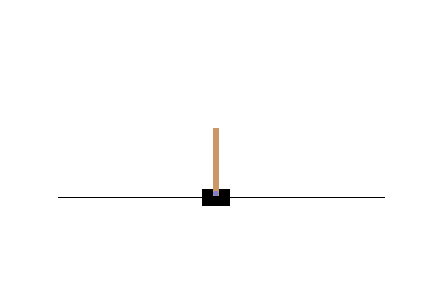
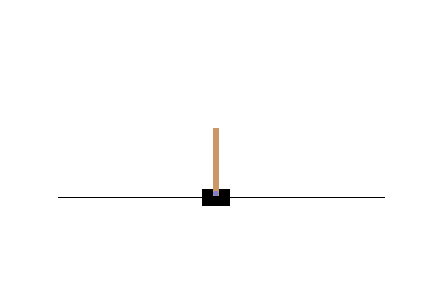
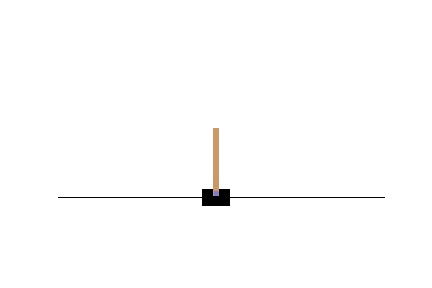
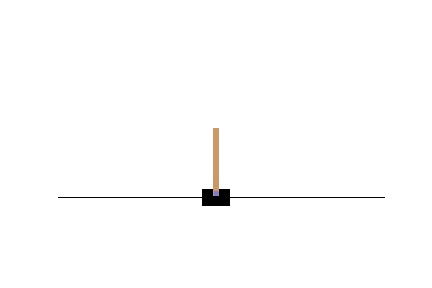
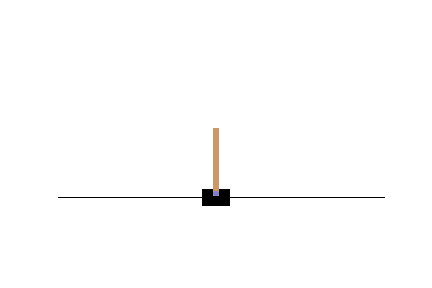
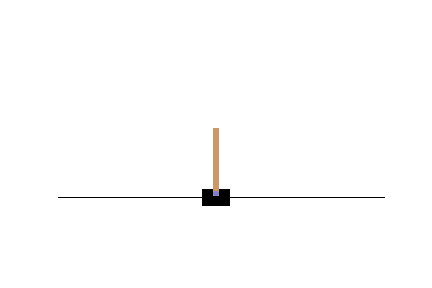
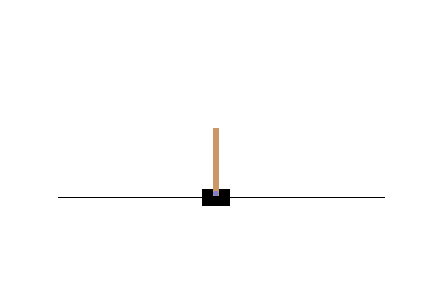
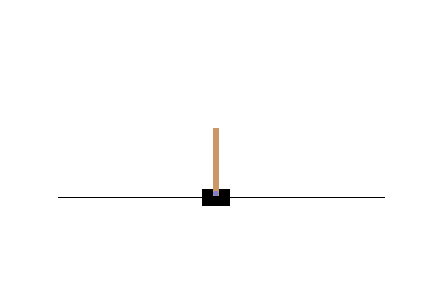
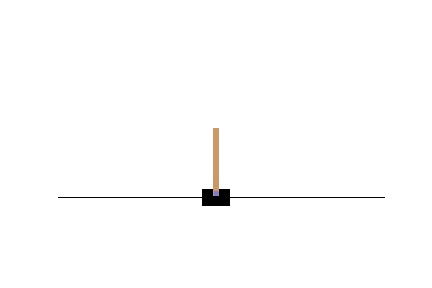
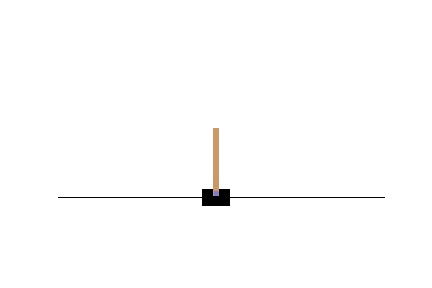
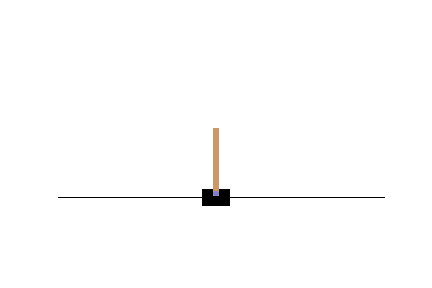
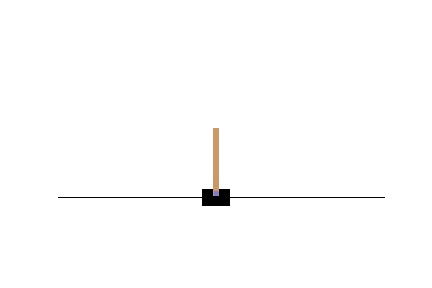
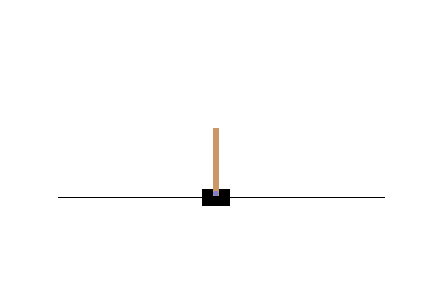
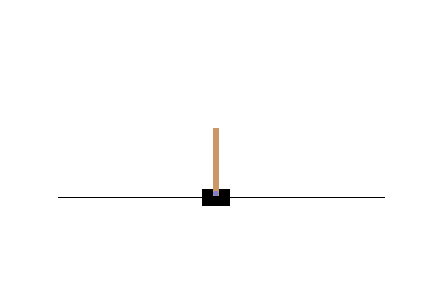
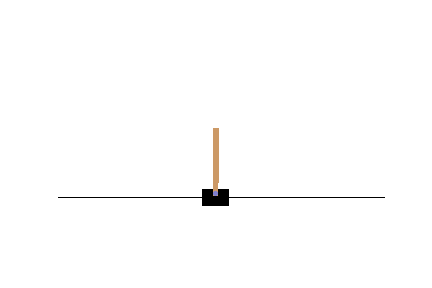
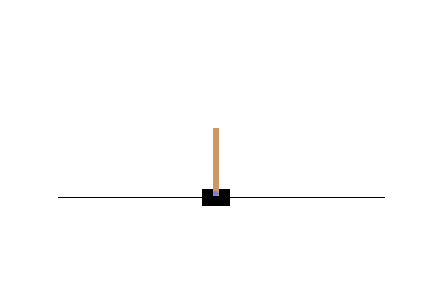
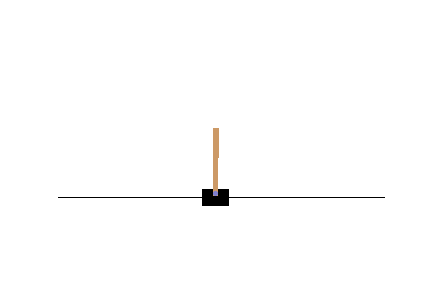
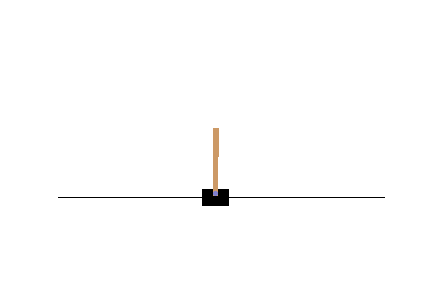
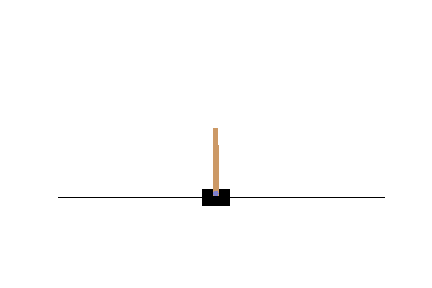
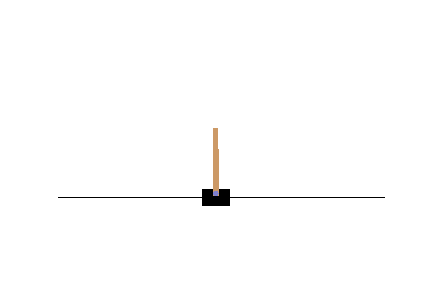
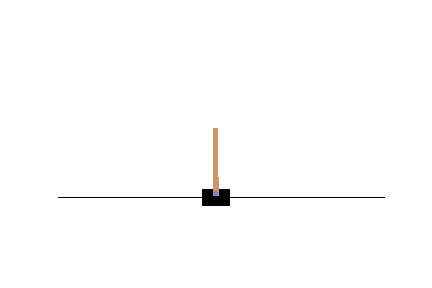
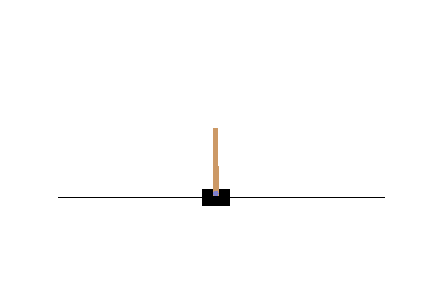
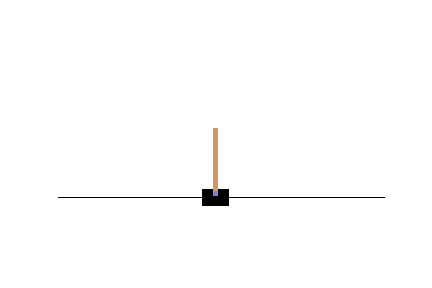
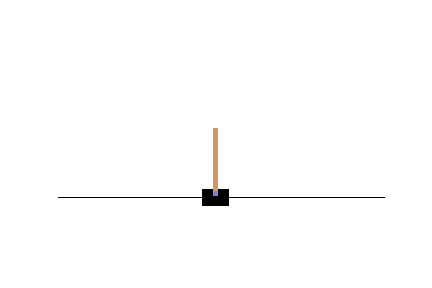
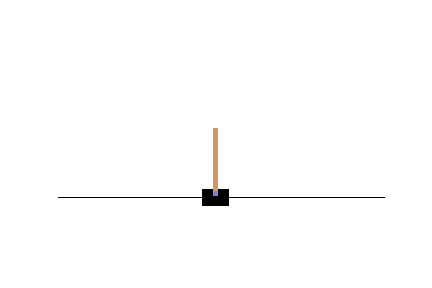
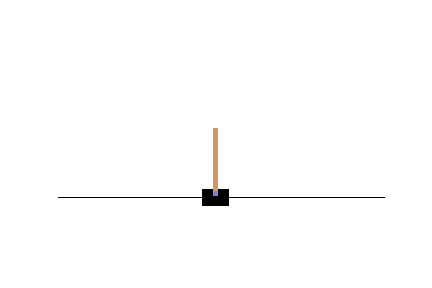
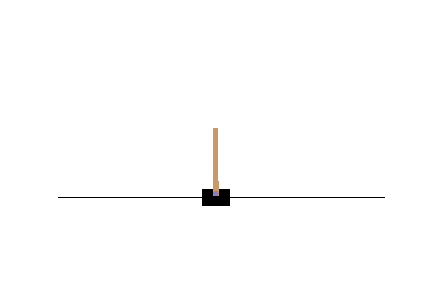
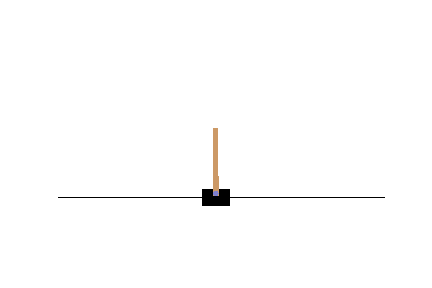
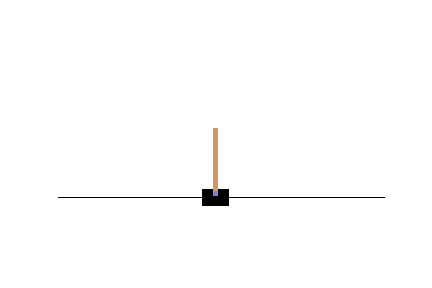
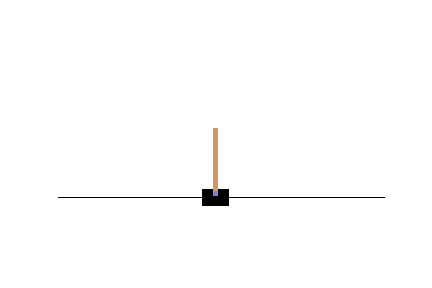
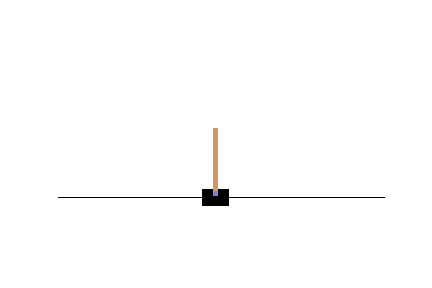
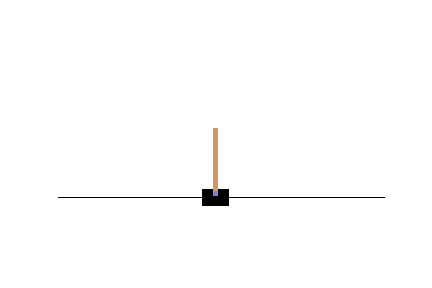
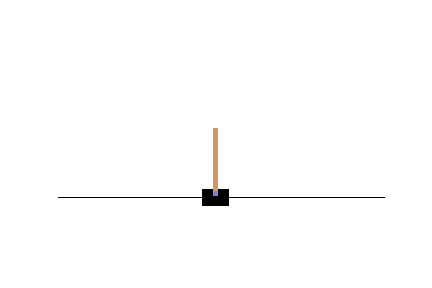
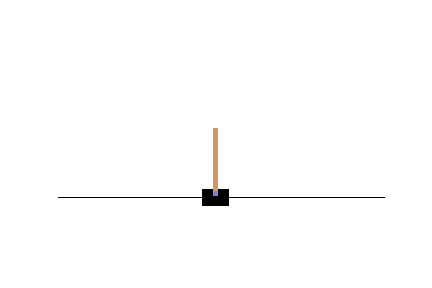
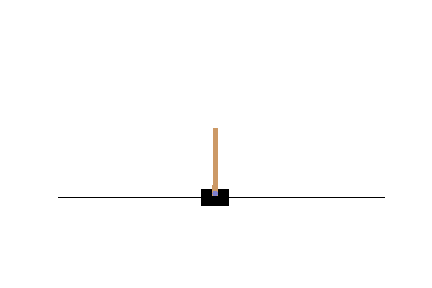
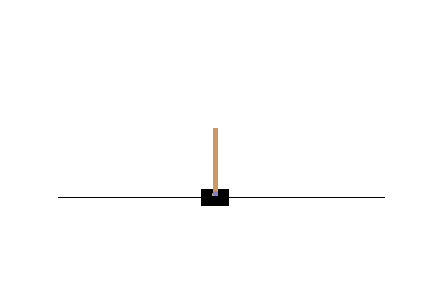
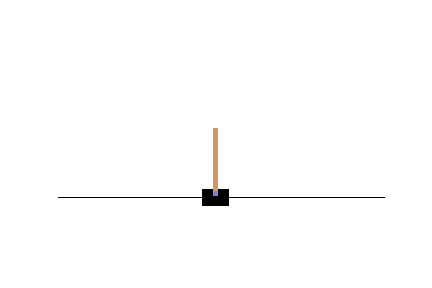
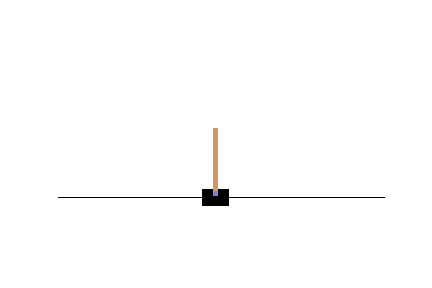
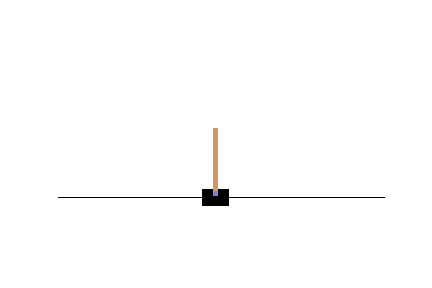
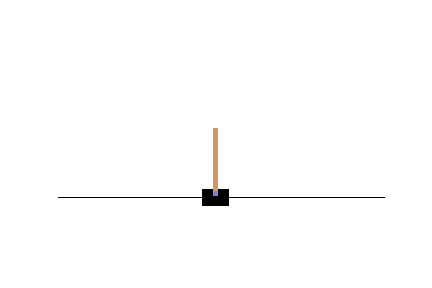
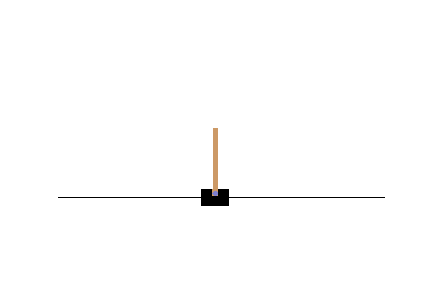
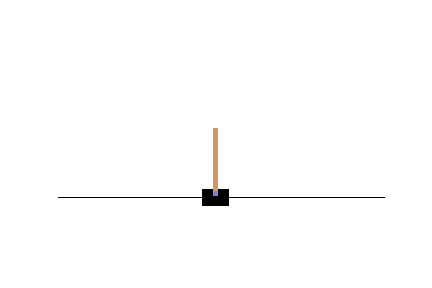
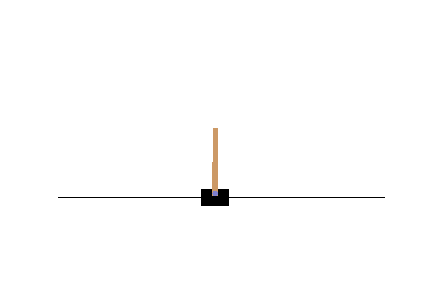
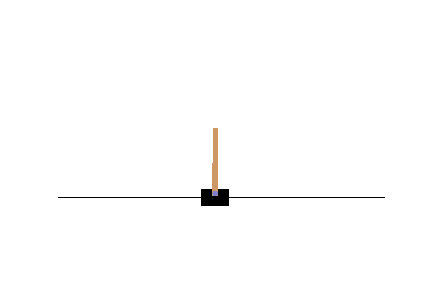
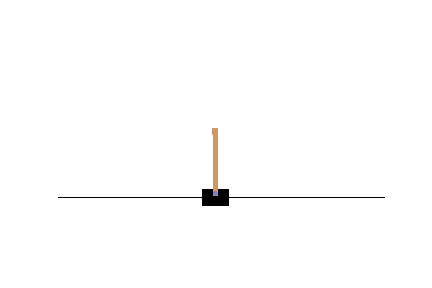
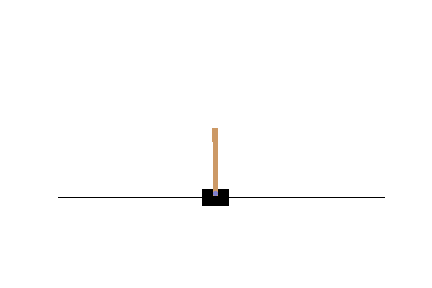
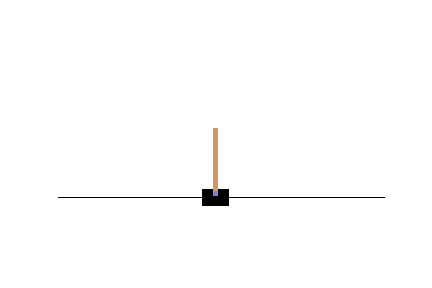
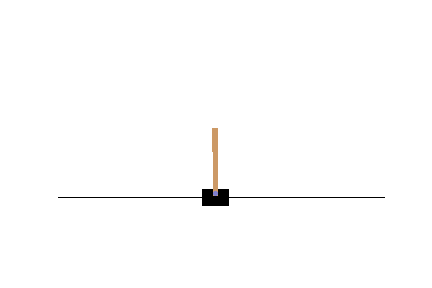
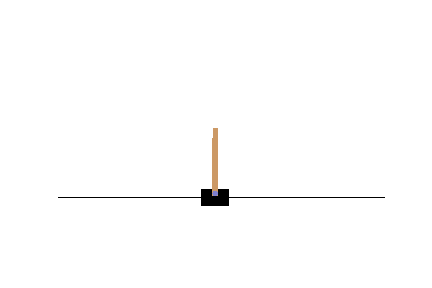
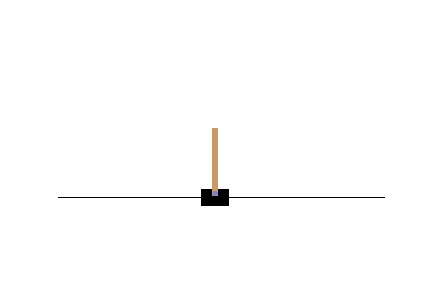
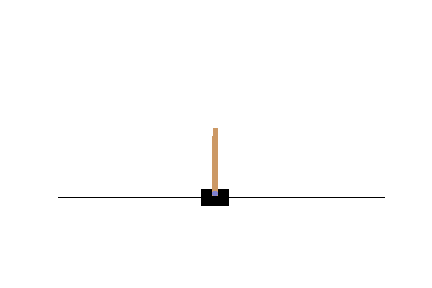
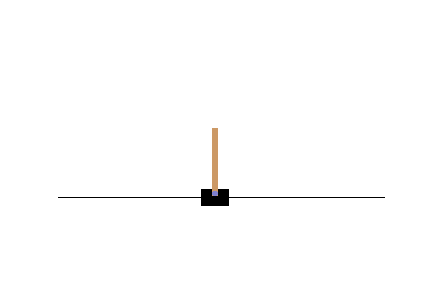
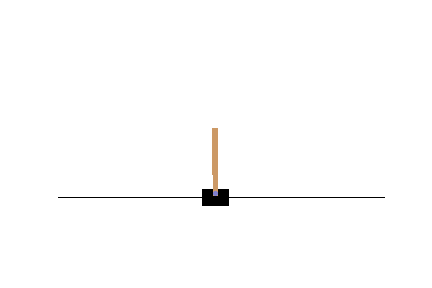
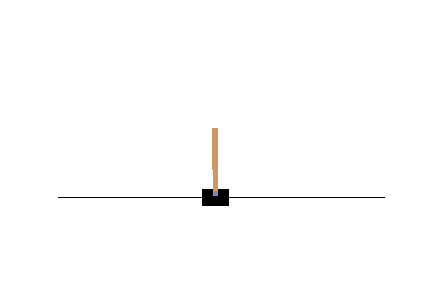
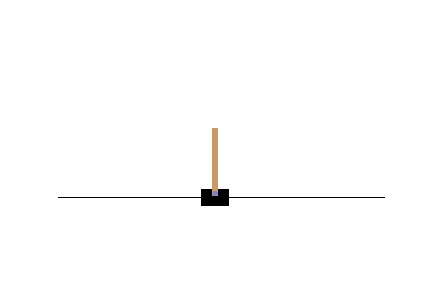
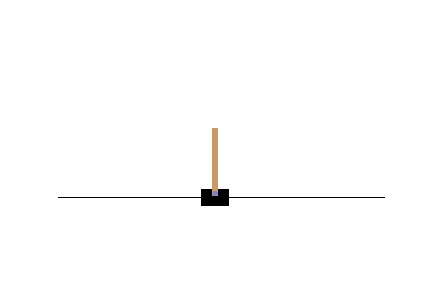
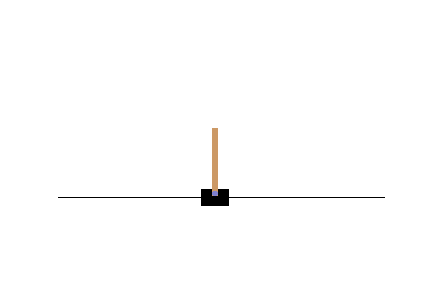
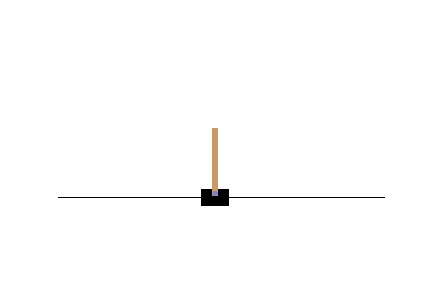
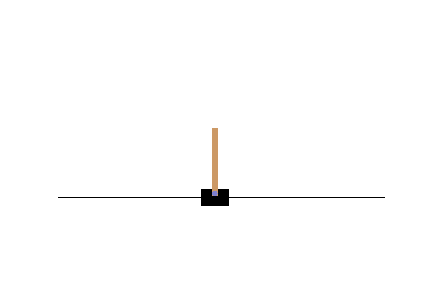
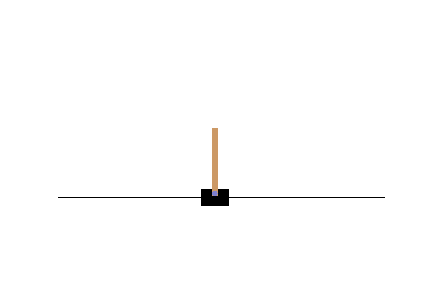
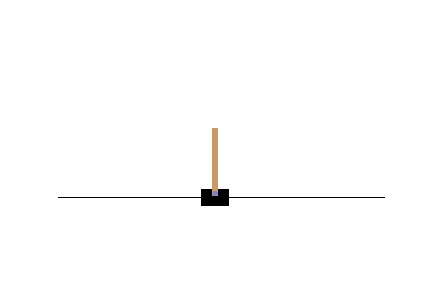
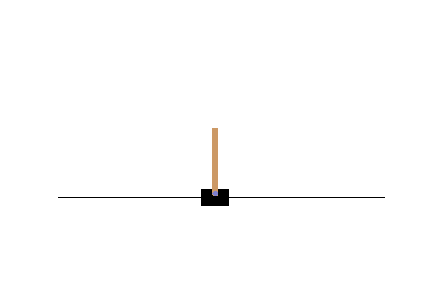
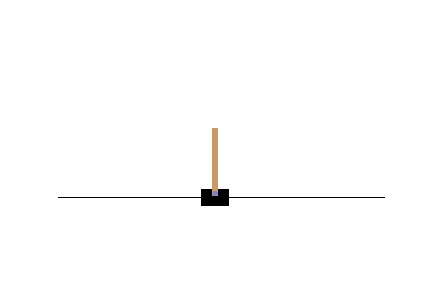
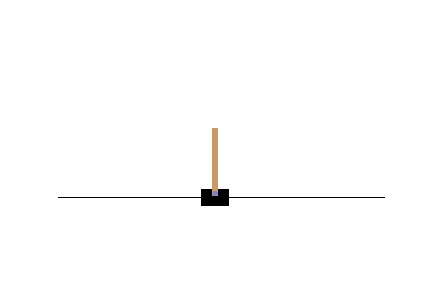
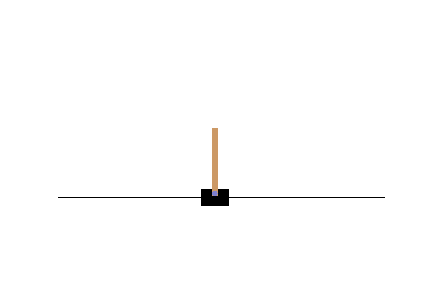
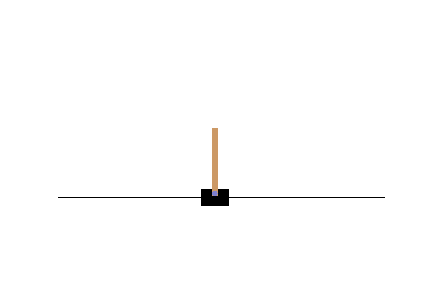
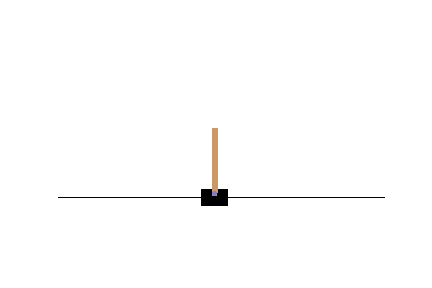
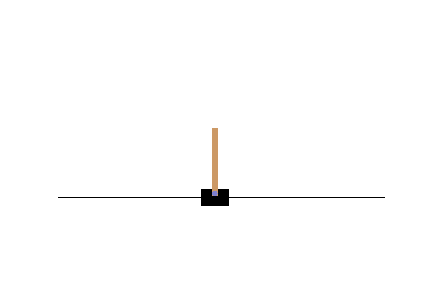
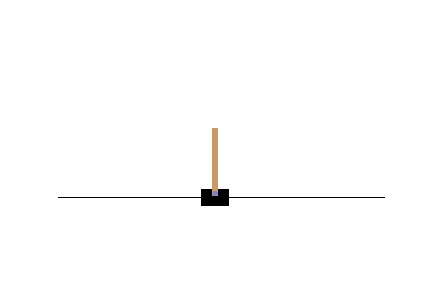
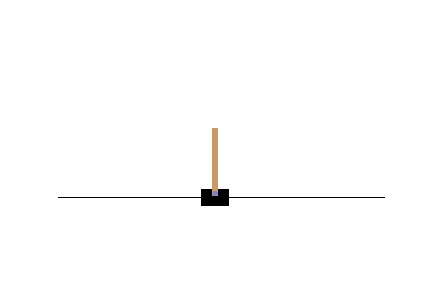
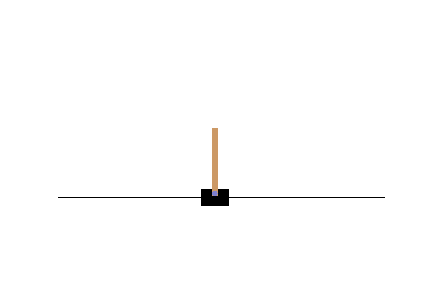
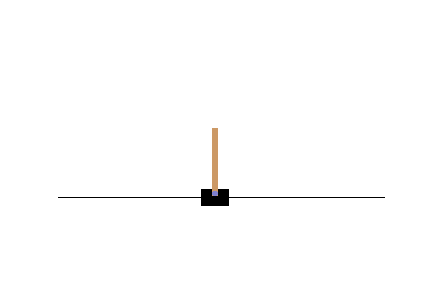
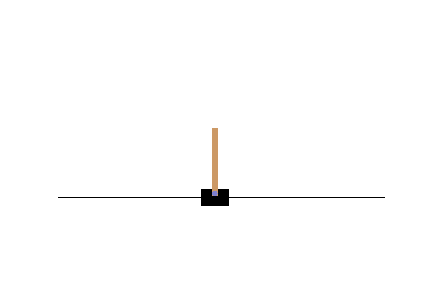
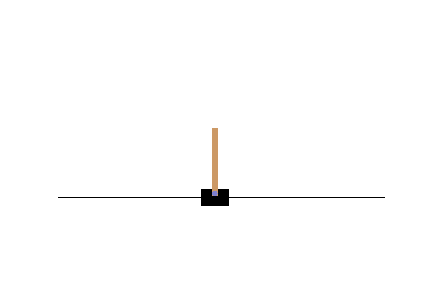
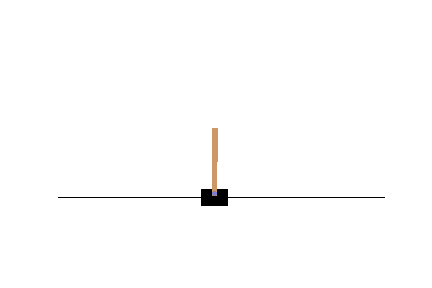
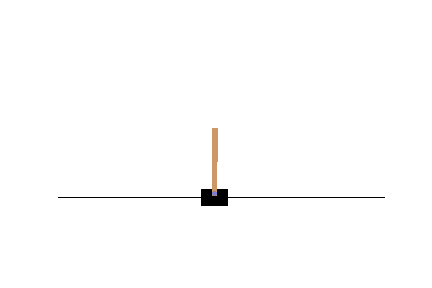
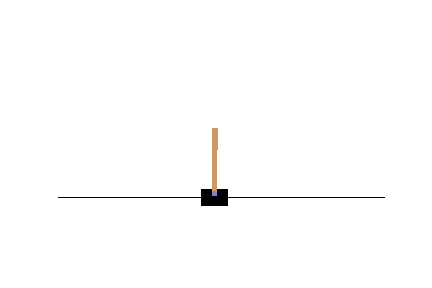
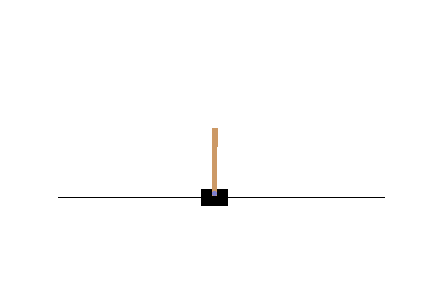
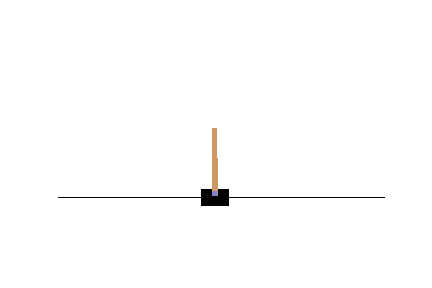
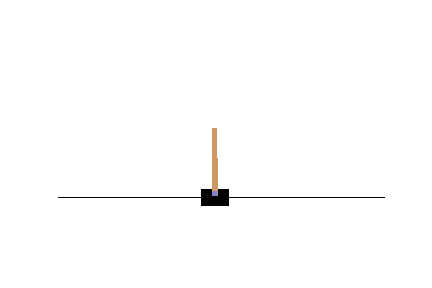
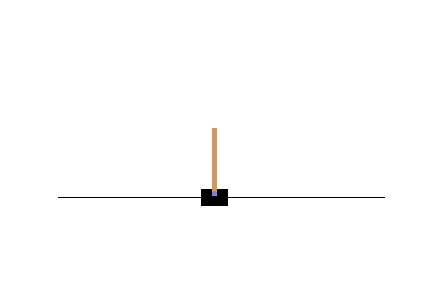
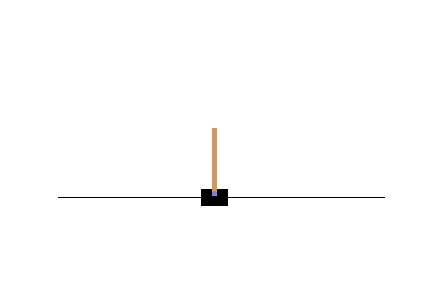
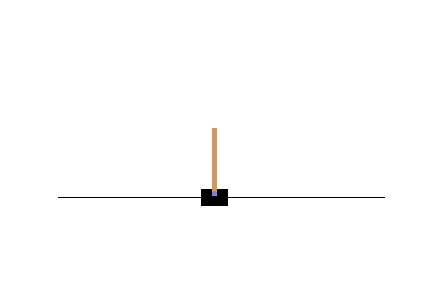
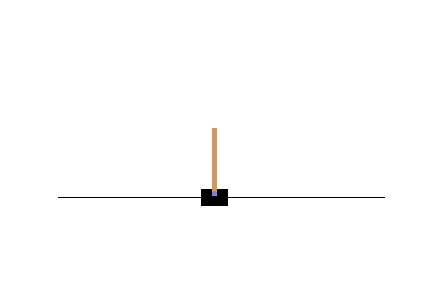
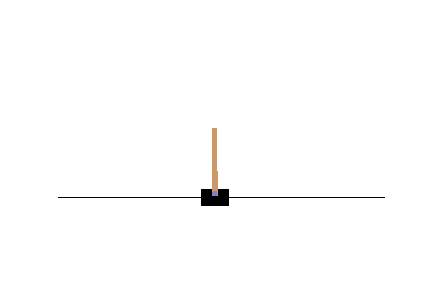
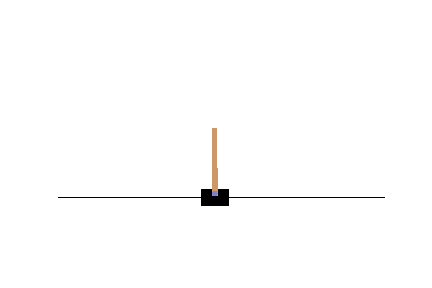
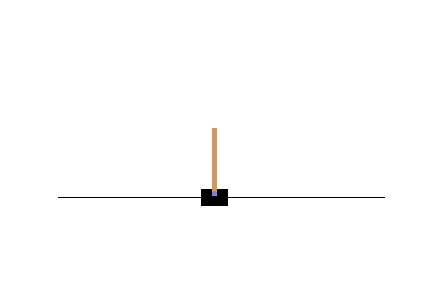
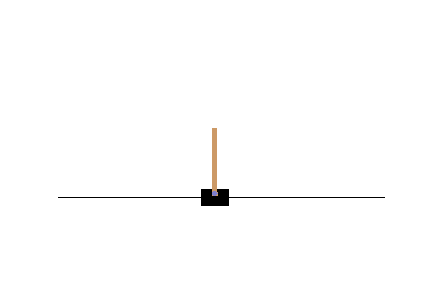
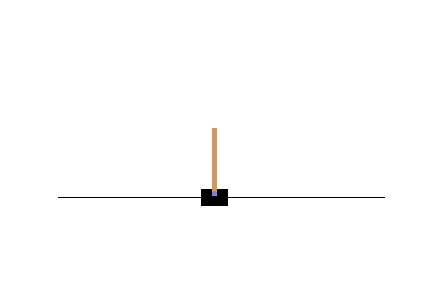
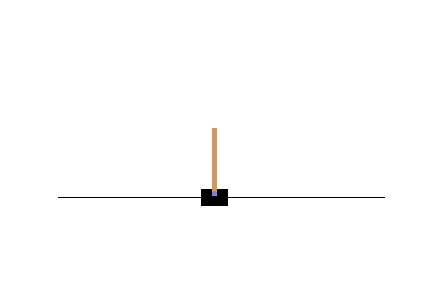
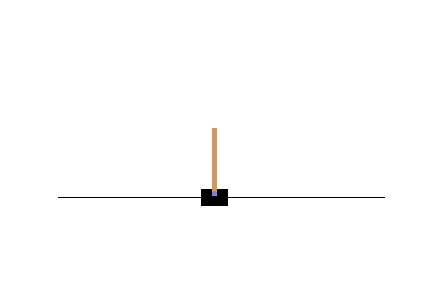
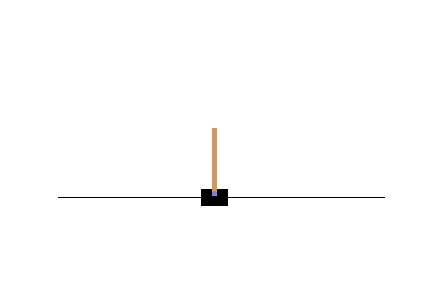
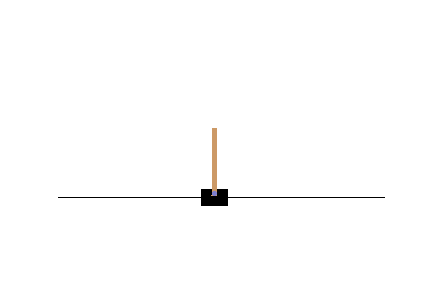
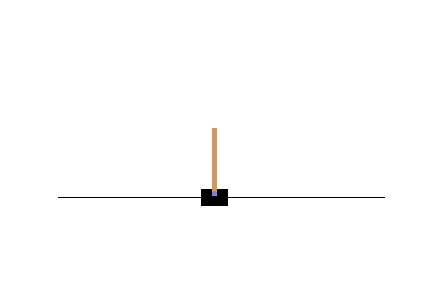
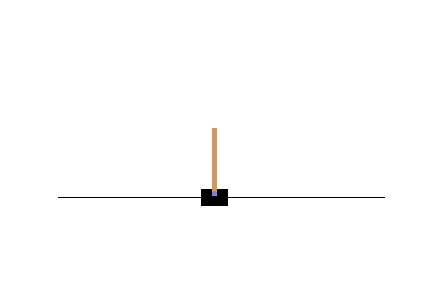
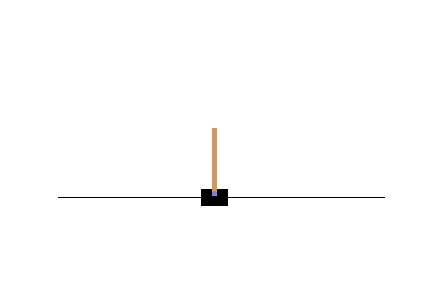
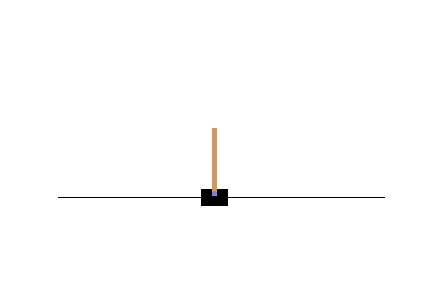
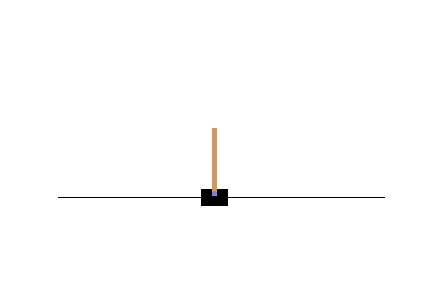
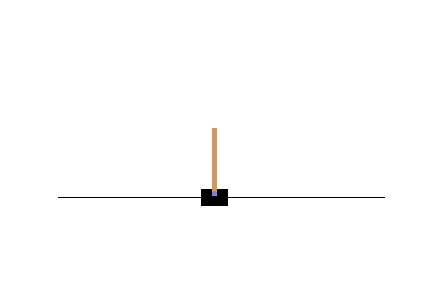
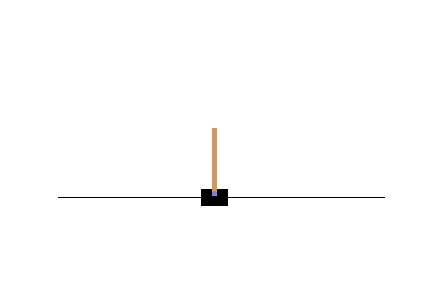
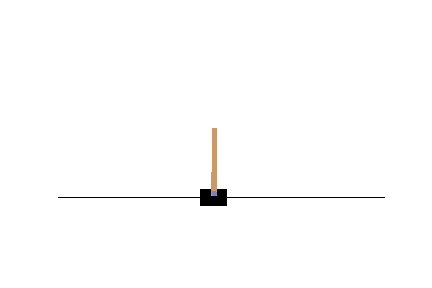
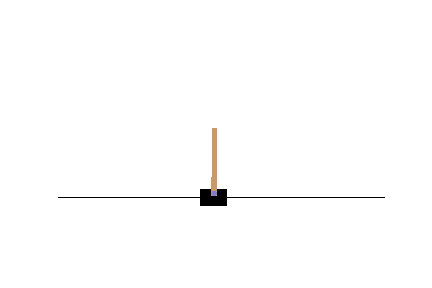
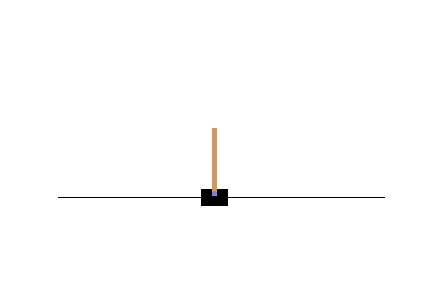
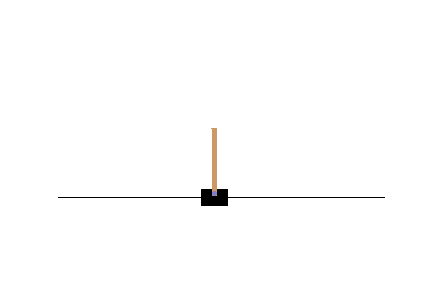
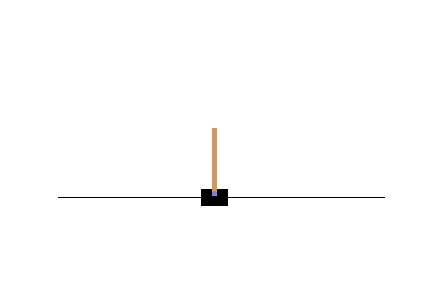
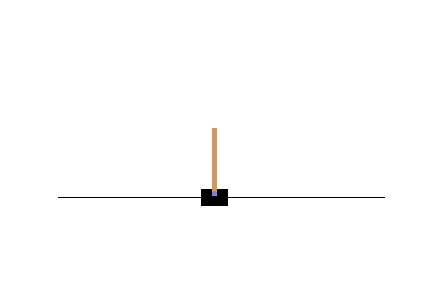
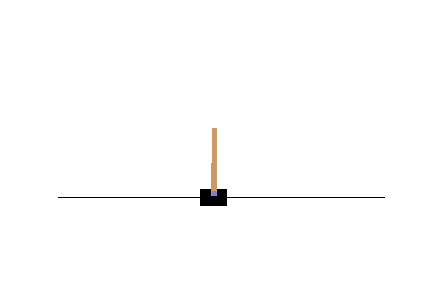
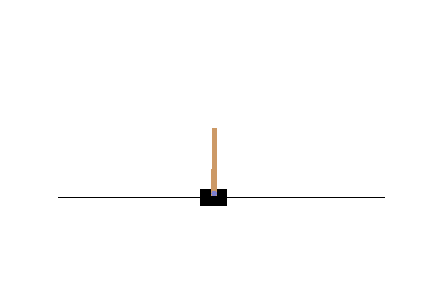
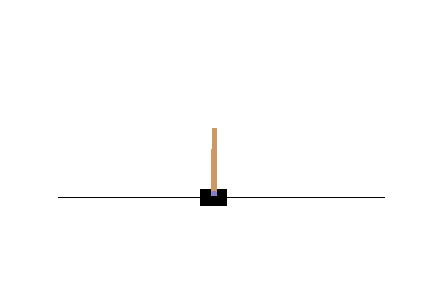
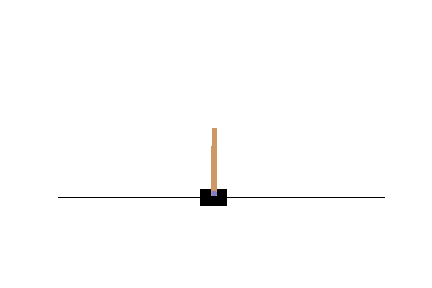
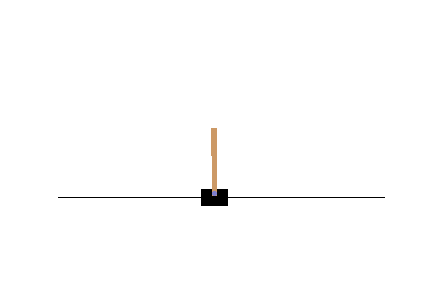
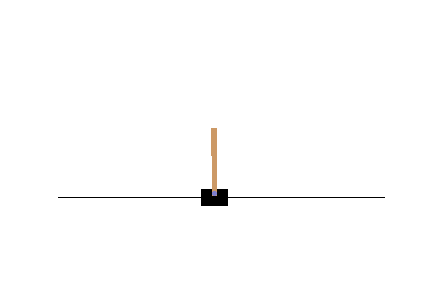
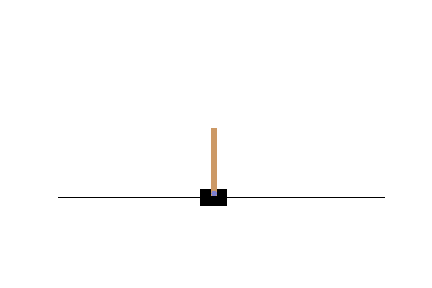
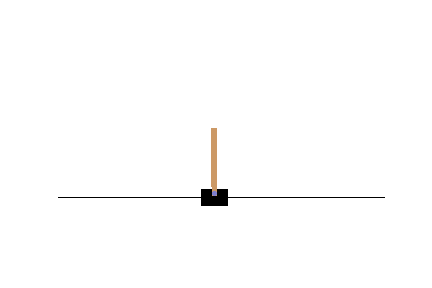
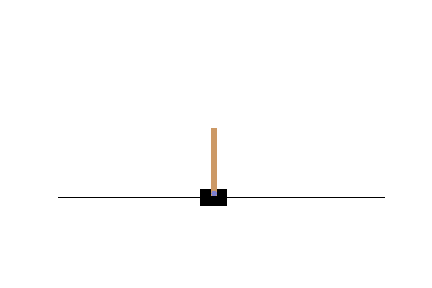
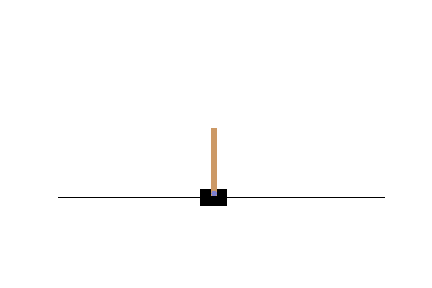
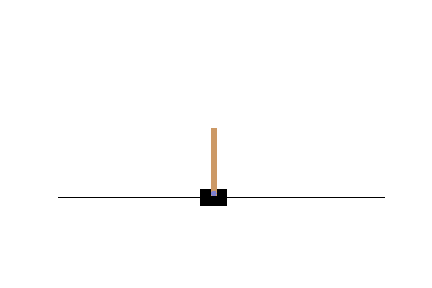
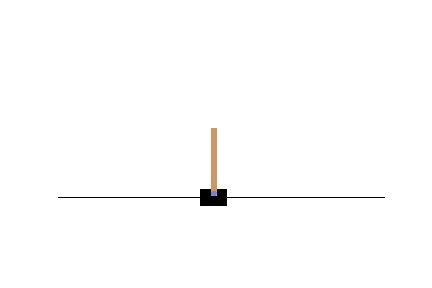
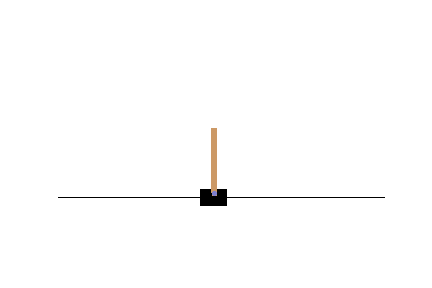
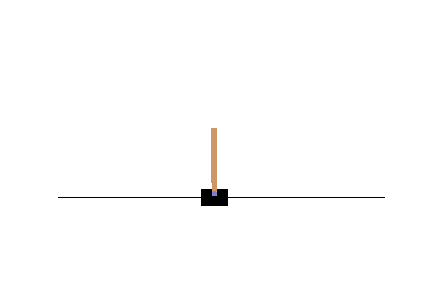
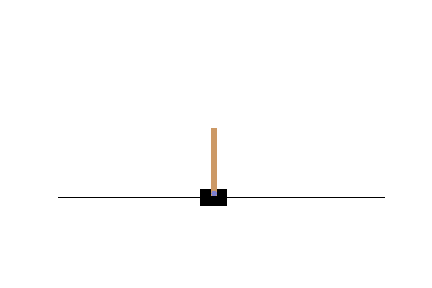
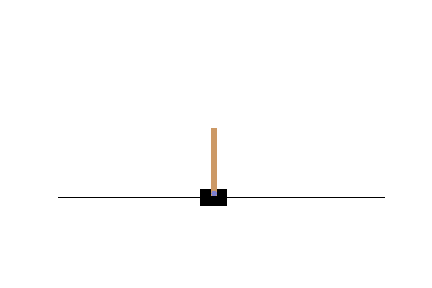
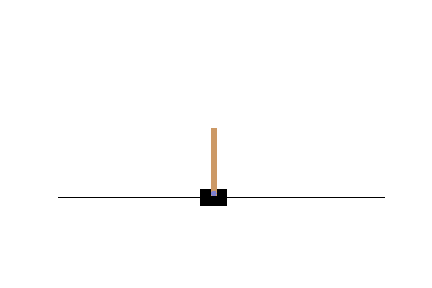
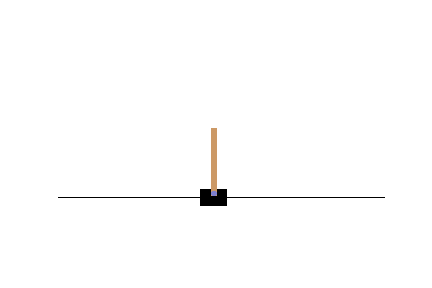
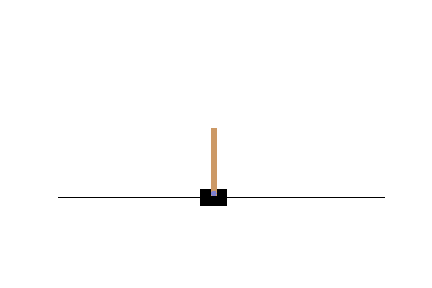
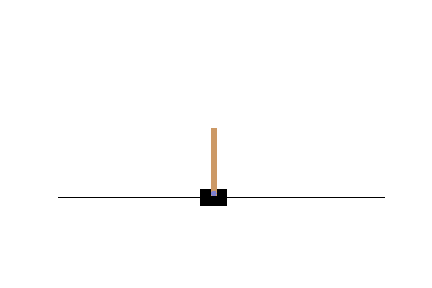
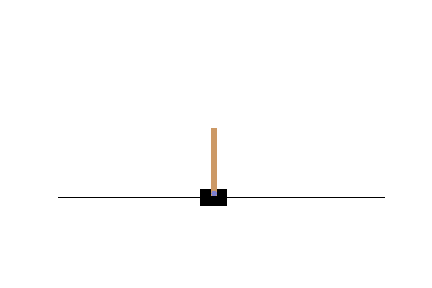
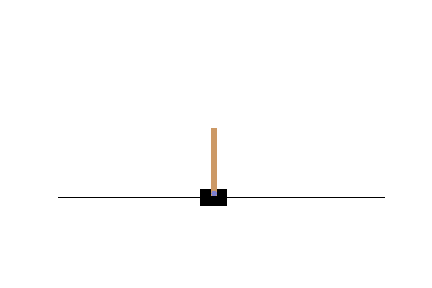
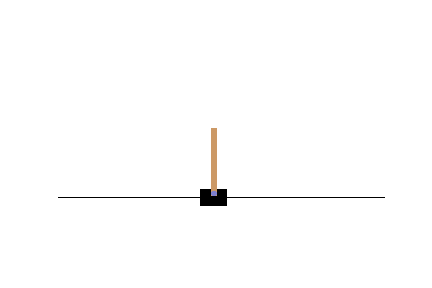
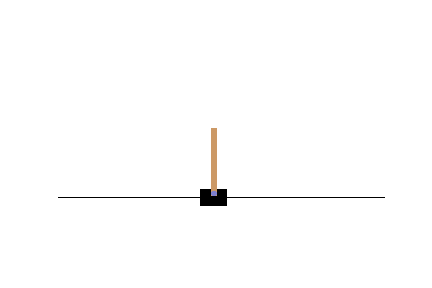
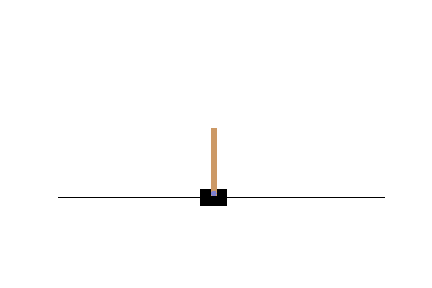
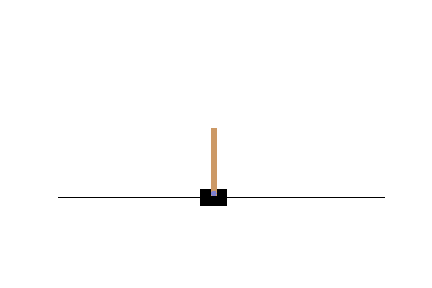
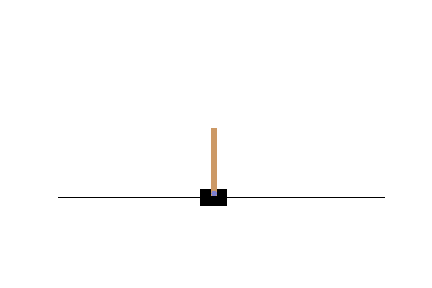
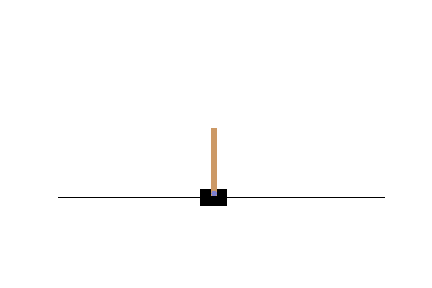
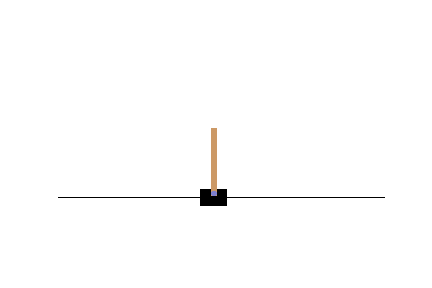
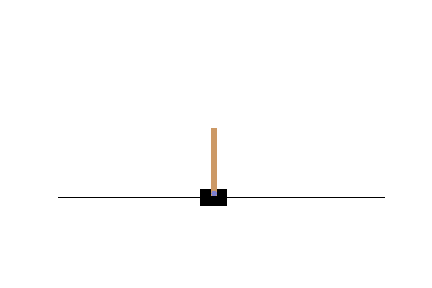
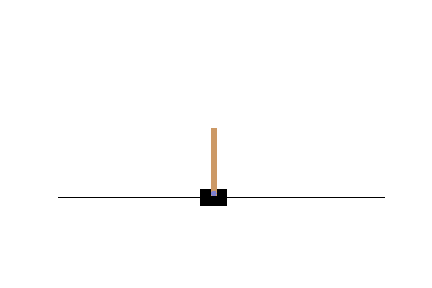
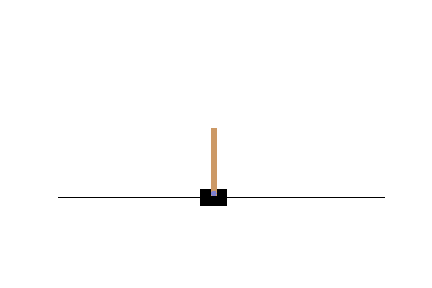
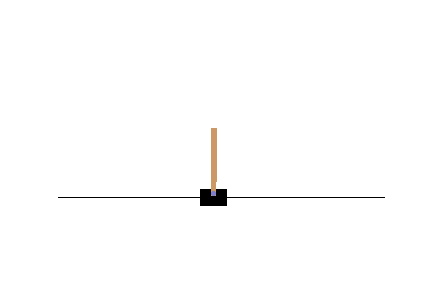
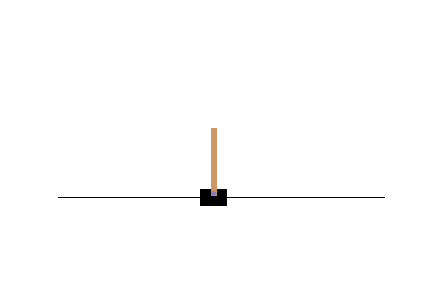
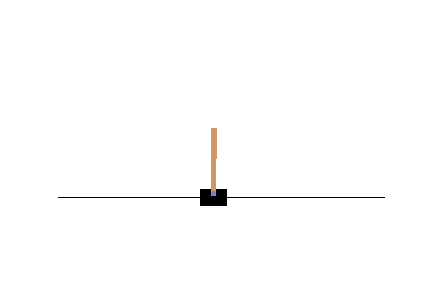
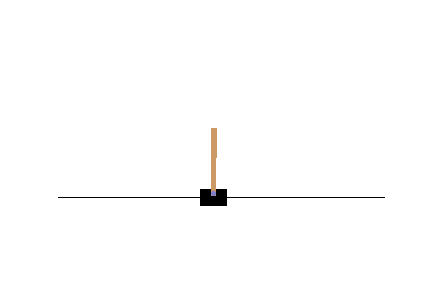
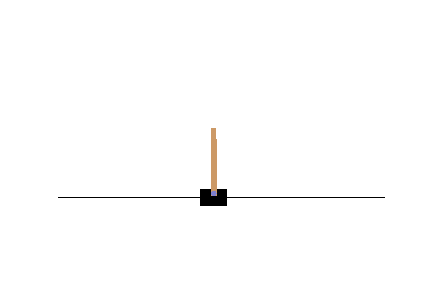
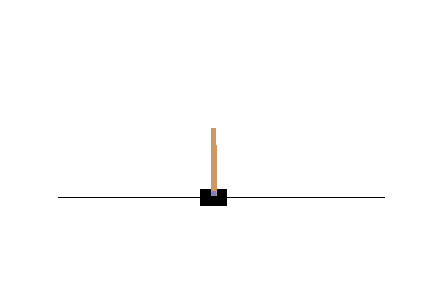
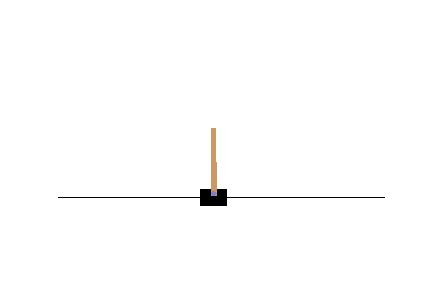
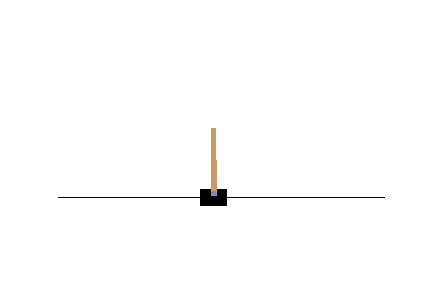
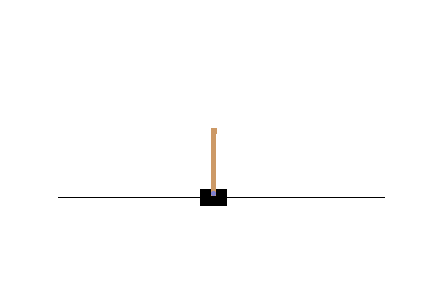
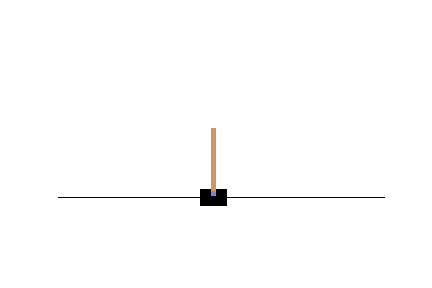
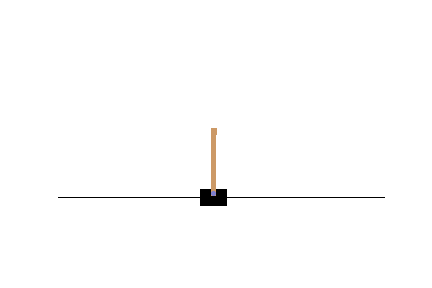
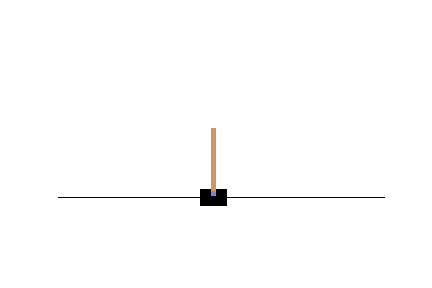
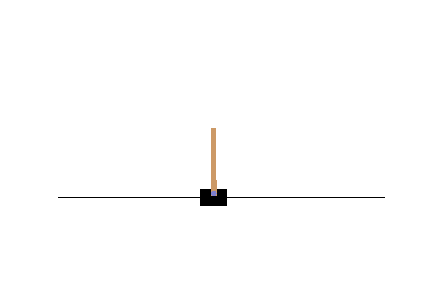
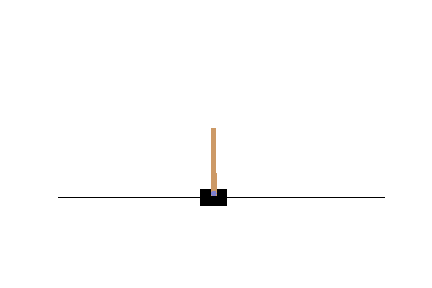
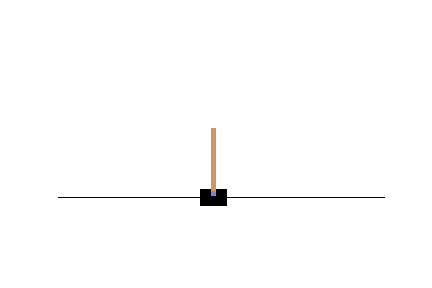
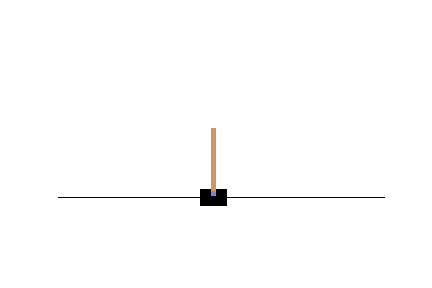
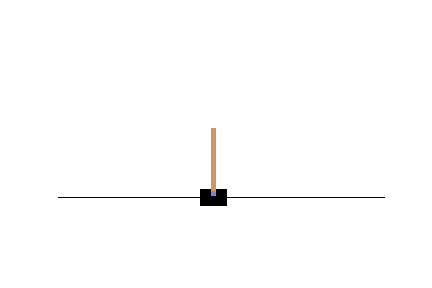
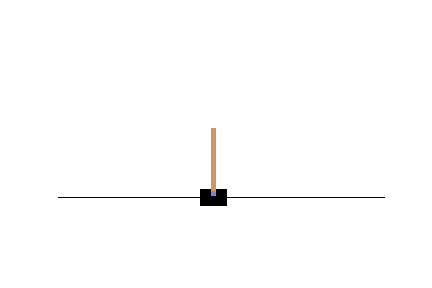
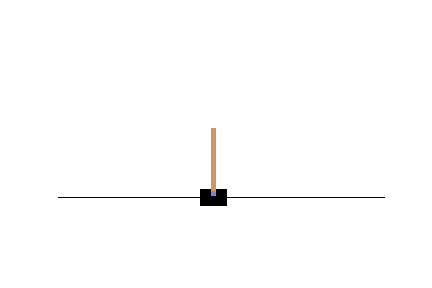
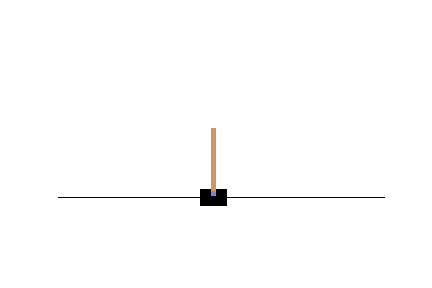
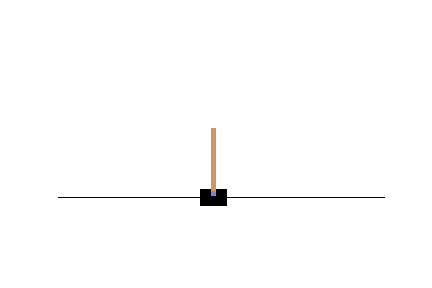
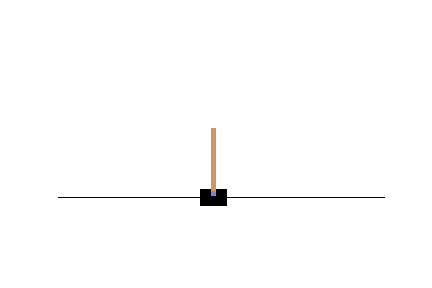
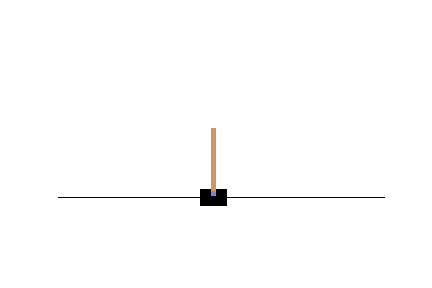
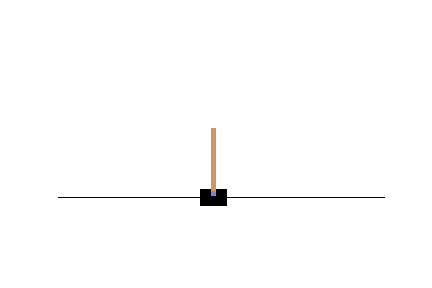
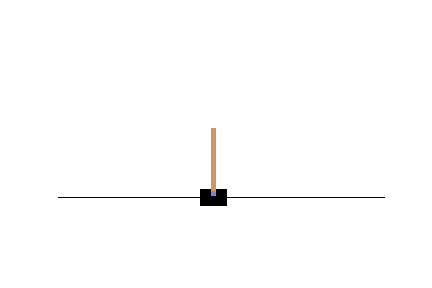
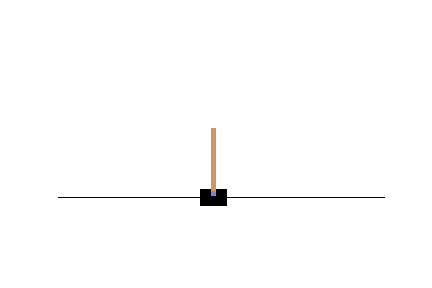
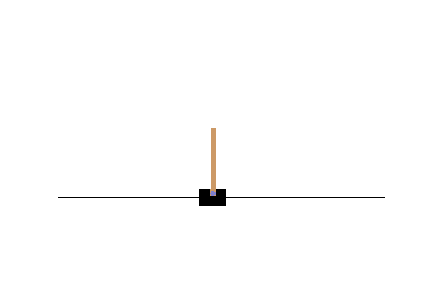
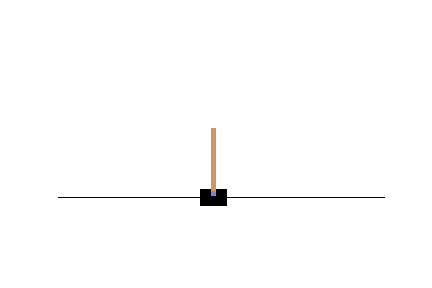
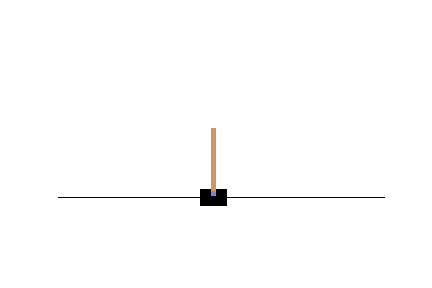
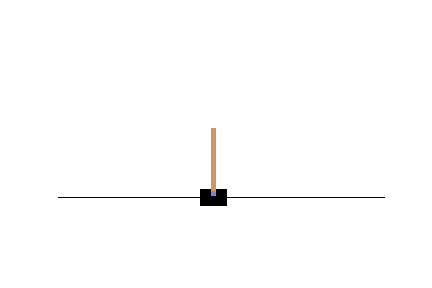
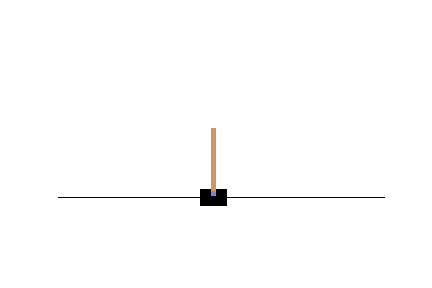
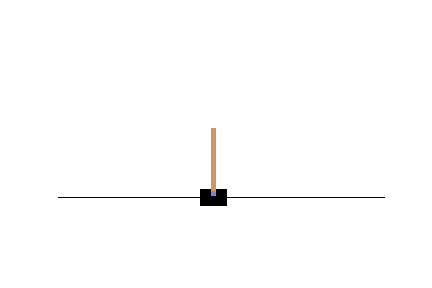
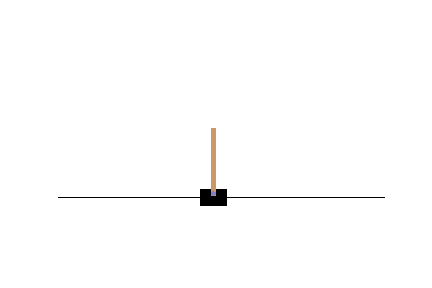
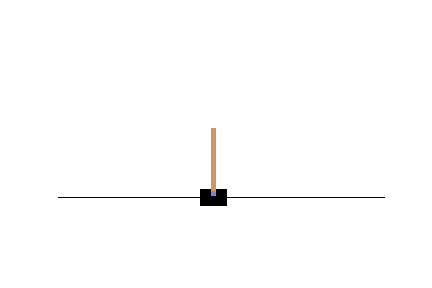
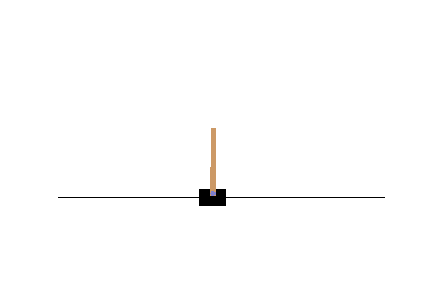
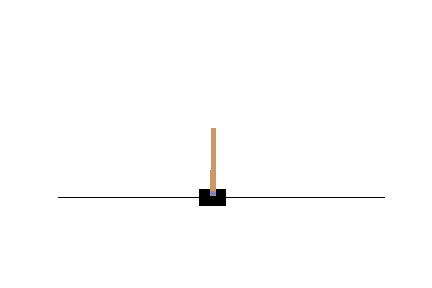
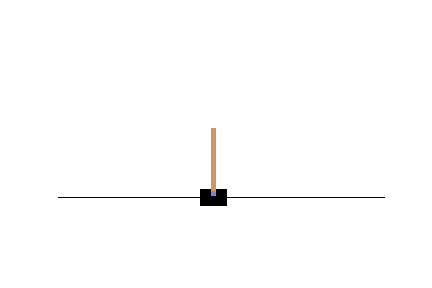
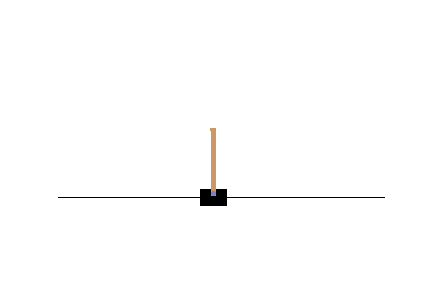
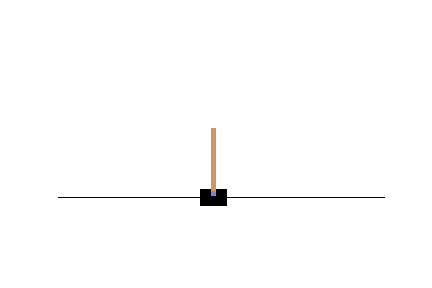
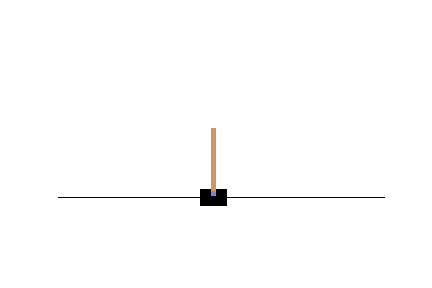
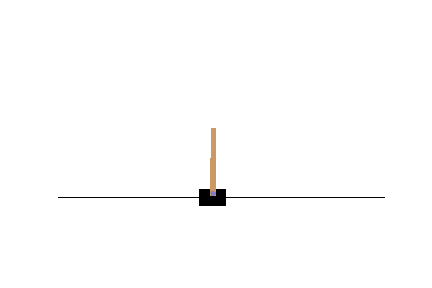
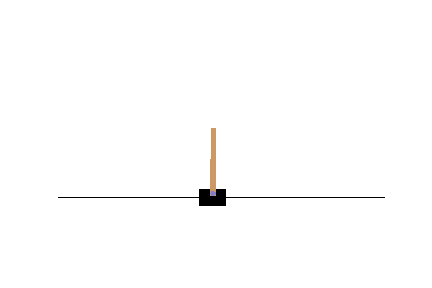
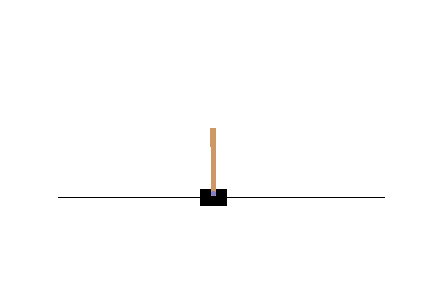
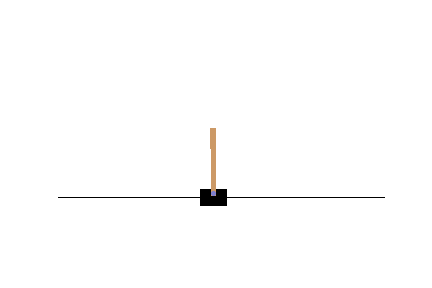
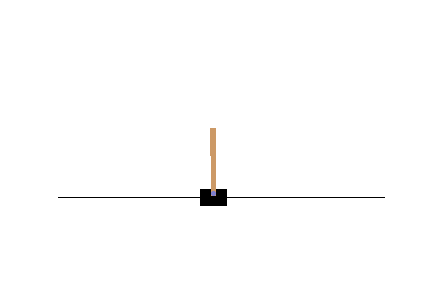
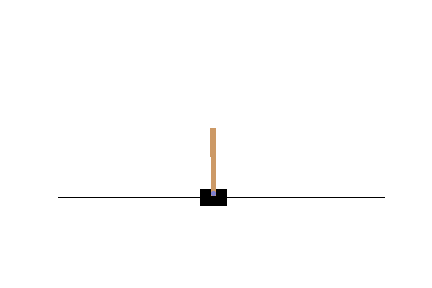
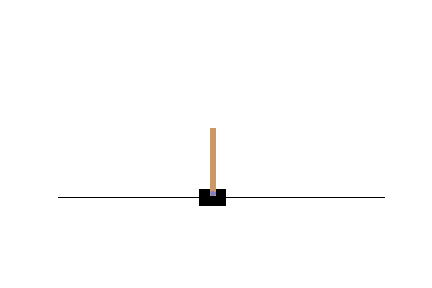
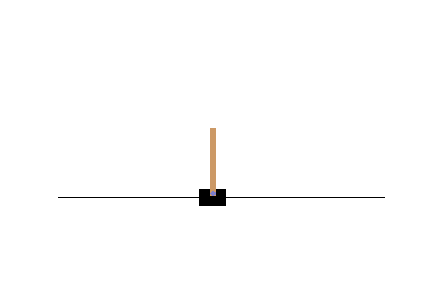
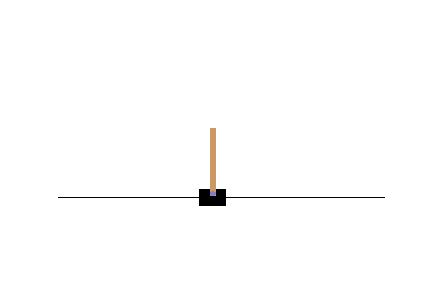
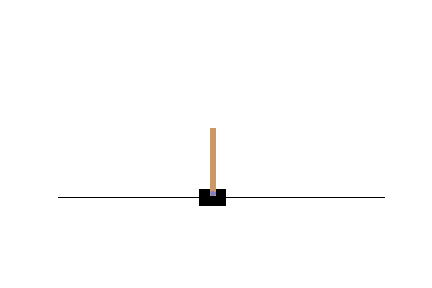
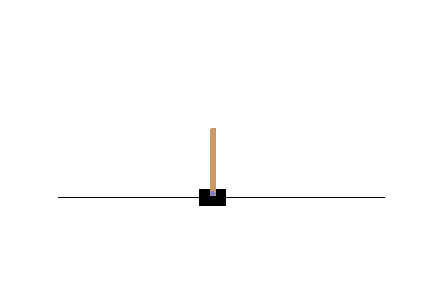
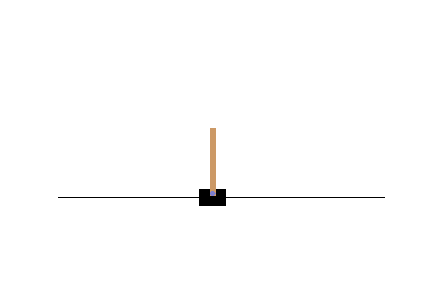

In [9]:
env = gym.make('CartPole-v1')
obs = env.reset()
total_reward = 0
frames = []
for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    action = agent.control(obs)
    obs, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        break
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)